## このノートブックの流れ

1.とにかく過学習を無くしたい

In [1]:
%matplotlib inline                      

import seaborn as sns                   # for beautiful plots
from scipy import stats                 # to calculate mode, skew and ANOVA, etc.
import numpy as np # linear algebra
np.set_printoptions(np.inf)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics
plt.rcParams['figure.figsize'] = (10, 8)
# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
np.set_printoptions(threshold=np.inf)
import xgboost as xgb
import lightgbm as lgb
import time
import pickle
import gc

## インポート～結合～前処理

In [2]:
train = pd.read_csv('../house price/train.csv')
test = pd.read_csv('../house price/test.csv')
Id = test.Id
target = train.SalePrice
train[train.SalePrice>300000]

nums = [f for f in train.columns if train.dtypes[f] != 'object']
nums.remove('SalePrice')
nums.remove('Id')
cats = [f for f in train.columns if train.dtypes[f] == 'object']

train['SalePrice'] = np.log(train['SalePrice'])

alldata = pd.concat([train, test], sort=False).reset_index()

alldata['LotFrontage'] = alldata.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
mode_fill_li = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual'
                 , 'Functional', 'SaleType']
None_fill_li = [ 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType'
                , 'GarageFinish','GarageQual', 'GarageCond']
fill_0_li = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']
for i in mode_fill_li:
    alldata[i].fillna(alldata[i].mode()[0], inplace=True)

for j in None_fill_li:
    alldata[j].fillna('None',inplace=True)

for k in fill_0_li:
    alldata[k].fillna(0, inplace=True)
    
alldata2 = alldata 

alldata.drop([523, 1298], inplace=True)

# 特徴量エンジニアリング

### 003 ~ 006

In [3]:
neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1
                    , "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1
                    , "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2
                    , "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2
                    , "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3
                    , "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4
                    , "NridgHt" : 4}

alldata['NeighborhoodBin'] = alldata2['Neighborhood'].map(neighborhood_map)

In [4]:
many_f = pd.read_pickle('../house price/alldata_many_cols.pkl').reset_index()
mean_f = pd.read_pickle('../house price/alldata_mean_cols.pkl').reset_index()
delta_f = pd.read_pickle('../house price/alldata_delta_col.pkl').reset_index()

In [5]:
many_f.drop([523, 1298], inplace=True)
mean_f.drop([523, 1298], inplace=True)
delta_f.drop([523, 1298], inplace=True)

In [6]:
alldata["SimplOverallQual"] = alldata2.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
alldata["SimplOverallCond"] = alldata2.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 2, 7 : 2, 8 : 2, 9 : 2, 10 : 2})

binning = nums

for f in nums: 
    alldata[f] = np.log1p(alldata[f])

def getbin(df, col, bins):
    df['binned_'+ col] = pd.cut(df[col], bins ,labels=False)
    return df

alldata = getbin(alldata, 'GrLivArea', 5)
alldata = getbin(alldata, '1stFlrSF', 5)
alldata = getbin(alldata, '2ndFlrSF', 5)
alldata = getbin(alldata, 'TotalBsmtSF', 5)
alldata = getbin(alldata, 'BsmtFinSF1', 5)
alldata = getbin(alldata, 'BsmtFinSF2', 5)
alldata = getbin(alldata, 'LotFrontage', 5)

In [7]:
alldata.to_pickle('alldata_008.pkl')

In [8]:
len(alldata)

2917

# 特徴量選択

In [9]:
alldata1 = pd.read_pickle('../house price/alldata_008.pkl')
np.array(alldata.columns)

array(['index', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'G

In [63]:
alldata1 = alldata[[ 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
       'BsmtFinType2', 
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'LowQualFinSF',  'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath',
       'KitchenAbvGr', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice',
       'NeighborhoodBin',
       'SimplOverallQual', 'SimplOverallCond', 'binned_GrLivArea',
       'binned_1stFlrSF', 'binned_2ndFlrSF', 'binned_TotalBsmtSF',
       'binned_BsmtFinSF1', 'binned_BsmtFinSF2', 'binned_LotFrontage']]

In [64]:
#alldata1 = alldata1.merge(delta_f[['Id','delta_mean_LandSlope_OverallQual','delta_mean_Utilities_OverallQual'
                                  #, 'delta_mean_Condition2_OverallQual']], on='Id', how='left')

In [65]:
alldata1 = pd.merge(alldata1, mean_f[['Id']], on='Id', how='left')

In [66]:
alldata1 = pd.merge(alldata1, many_f[['Id']], on='Id', how='left')

In [67]:
# alldata1 = pd.get_dummies(alldata1)

In [68]:
def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 80:
            overfit.append(i)
    overfit = list(overfit)
    return overfit
overfitted_features = overfit_reducer(alldata1)
print(overfitted_features)
alldata1.drop(overfitted_features, axis=1, inplace=True)

['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SaleType', 'SaleCondition', 'SimplOverallCond', 'binned_BsmtFinSF2']


In [69]:
alldata1.to_pickle('alldata_search_008.pkl')
alldata1.shape

(2917, 42)

# モデリング

In [70]:
data = pd.read_pickle('../house price/alldata_search_008.pkl')
data.drop('Id', axis=1, inplace=True)
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train = data[data['SalePrice'].notnull()]
test = data[data['SalePrice'].isnull()]
categorical_cols = list(data.select_dtypes(include=['object']).columns)

from sklearn import preprocessing
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, col_definition: dict):
    """
    col_definition: encode_col
    """
    n_train = len(train)
    train = data
    for f in col_definition['encode_col']:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

train, test = label_encoding(train, test, col_definition={'encode_col': categorical_cols})

X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test.drop('SalePrice', axis=1)

In [71]:
# ランダムシードを変える
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=3, shuffle=True, random_state=100000)

params = {'objective':'regression',
          'metric': 'rmse',
          'num_leaves':3,
          'learning_rate':0.05,
          'n_estimators':720,
          'max_bin' : 40, 
          'bagging_fraction' : 0.8,
          'bagging_freq' : 5, 
          'feature_fraction' : 0.2319,
          'feature_fraction_seed':9, 
          'bagging_seed':9,
          'min_data_in_leaf' :30, 
          'min_sum_hessian_in_leaf' : 11,
          'importance_type': 'gain'
}

feature_importance_df = pd.DataFrame()
col = list(X_train.columns)
i = 1
feat_df = pd.DataFrame()

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr,
                            y_tr,
                            categorical_feature=categorical_cols)

    lgb_eval = lgb.Dataset(X_val,
                           y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_cols)

    model = lgb.train(params,
                      lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=5)
   
    fold_feat_df = pd.DataFrame()
    fold_feat_df["Feature_fold{}".format(i)] = col
    fold_feat_df["Importance_fold{}".format(i)] = model.feature_importance()
    i += 1
    feat_df = pd.concat([feat_df, fold_feat_df], axis=1)

    oof_train[valid_index] = model.predict(X_val,
                                           num_iteration=model.best_iteration)
    y_pred = model.predict(X_test,
                           num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

    
print(f'CV: {np.sqrt(mean_squared_error(y_train, oof_train))}')

C:\Users\user\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 5 rounds
[10]	training's rmse: 0.328143	valid_1's rmse: 0.319013
[20]	training's rmse: 0.27756	valid_1's rmse: 0.27113
[30]	training's rmse: 0.242594	valid_1's rmse: 0.239591
[40]	training's rmse: 0.218943	valid_1's rmse: 0.217689
[50]	training's rmse: 0.202765	valid_1's rmse: 0.203965
[60]	training's rmse: 0.189917	valid_1's rmse: 0.193481
[70]	training's rmse: 0.180111	valid_1's rmse: 0.186019
[80]	training's rmse: 0.173611	valid_1's rmse: 0.181246
[90]	training's rmse: 0.168558	valid_1's rmse: 0.177975
[100]	training's rmse: 0.164585	valid_1's rmse: 0.175225
[110]	training's rmse: 0.16163	valid_1's rmse: 0.173734
[120]	training's rmse: 0.159116	valid_1's rmse: 0.172071
[130]	training's rmse: 0.157107	valid_1's rmse: 0.171196
[140]	training's rmse: 0.155183	valid_1's rmse: 0.169997
[150]	training's rmse: 0.153636	valid_1's rmse: 0.169245
[160]	training's rmse: 0.15218	valid_1's rmse: 0.168952
[170]	training's rmse: 0.150989	valid_1's

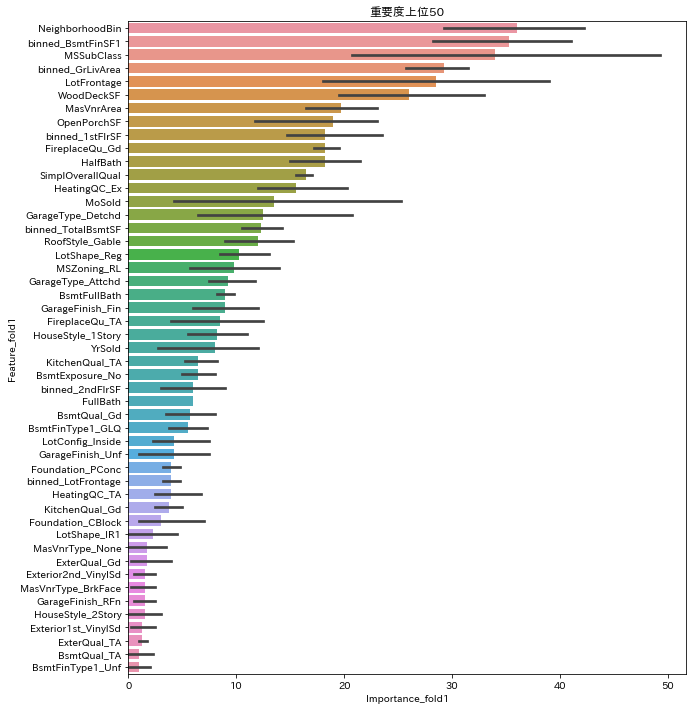

In [48]:
def feature_importance_plot(df):
    a = df[["Feature_fold1","Importance_fold1"]]
    b = df[["Feature_fold2","Importance_fold2"]].rename(columns={"Feature_fold2":"Feature_fold1", "Importance_fold2":"Importance_fold1"})
    c = df[["Feature_fold3","Importance_fold3"]].rename(columns={"Feature_fold3":"Feature_fold1", "Importance_fold3":"Importance_fold1"})
    d = df[["Feature_fold4","Importance_fold4"]].rename(columns={"Feature_fold4":"Feature_fold1", "Importance_fold4":"Importance_fold1"})
    #e = df[["Feature_fold5","Importance_fold5"]].rename(columns={"Feature_fold5":"Feature_fold1", "Importance_fold5":"Importance_fold1"})
    feat = pd.concat([a, b, c, d]).reset_index()
    indices = feat.groupby("Feature_fold1")["Importance_fold1"].agg("mean").reset_index().sort_values("Importance_fold1", ascending=False)["Feature_fold1"].values
    plt.figure(figsize=(10,12))
    plt.title("重要度上位50")
    sns.barplot(x="Importance_fold1", y="Feature_fold1", data=feat, order=indices[:50])
feature_importance_plot(feat_df)

In [34]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance.head(40)

,importance
GarageArea,33
GarageYrBlt,32
Fireplaces,31
BedroomAbvGr,30
LotFrontage,29
MSSubClass,27
MasVnrArea,25
GarageCars,24
WoodDeckSF,22
OpenPorchSF,21


In [48]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)

## Optuna使ってみた。

In [2428]:

import optuna
from sklearn.metrics import log_loss

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'num_leaves': trial.suggest_int('num_leaves', 2, 32),
        'learning_rate': 0.05,
        'max_bin': trial.suggest_int('max_bin', 80, 500),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 80)
    }
    
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=10,
                          num_boost_round=1000,
                          early_stopping_rounds=10)


        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
     
    score = np.sqrt(mean_squared_error(y_train, oof_train))
    return score   


In [2429]:
ts = time.time()
study = optuna.create_study(sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=200)
study.best_params

C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283751	valid_1's rmse: 0.263557
[20]	training's rmse: 0.214498	valid_1's rmse: 0.202839
[30]	training's rmse: 0.174316	valid_1's rmse: 0.170252
[40]	training's rmse: 0.151413	valid_1's rmse: 0.153266
[50]	training's rmse: 0.137633	valid_1's rmse: 0.14384
[60]	training's rmse: 0.129229	valid_1's rmse: 0.138427
[70]	training's rmse: 0.12393	valid_1's rmse: 0.135573
[80]	training's rmse: 0.120141	valid_1's rmse: 0.134585
[90]	training's rmse: 0.117349	valid_1's rmse: 0.133702
[100]	training's rmse: 0.115157	valid_1's rmse: 0.133187
[110]	training's rmse: 0.113068	valid_1's rmse: 0.132439
[120]	training's rmse: 0.111245	valid_1's rmse: 0.131986
[130]	training's rmse: 0.109509	valid_1's rmse: 0.131811
[140]	training's rmse: 0.108042	valid_1's rmse: 0.131555
[150]	training's rmse: 0.106614	valid_1's rmse: 0.131397
[160]	training's rmse: 0.105352	valid_1's rmse: 0.131254
[170]	training's rmse: 0.103917	valid_

[I 2020-07-15 20:20:37,716] Finished trial#0 with value: 0.13051907169522203 with parameters: {'max_depth': 12, 'num_leaves': 21, 'max_bin': 451, 'min_data_in_leaf': 69}. Best is trial#0 with value: 0.13051907169522203.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283026	valid_1's rmse: 0.255214
[20]	training's rmse: 0.211592	valid_1's rmse: 0.19516
[30]	training's rmse: 0.170158	valid_1's rmse: 0.161892
[40]	training's rmse: 0.146974	valid_1's rmse: 0.144047
[50]	training's rmse: 0.133788	valid_1's rmse: 0.133176
[60]	training's rmse: 0.125838	valid_1's rmse: 0.126112
[70]	training's rmse: 0.120548	valid_1's rmse: 0.122771
[80]	training's rmse: 0.11685	valid_1's rmse: 0.120906
[90]	training's rmse: 0.11394	valid_1's rmse: 0.119731
[100]	training's rmse: 0.111458	valid_1's rmse: 0.11904
[110]	training's rmse: 0.10941	valid_1's rmse: 0.119025
[120]	training's rmse: 0.10749	valid_1's rmse: 0.118822
Early stopping, best iteration is:
[114]	training's rmse: 0.108612	valid_1's rmse: 0.118711
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278165	valid_1's rmse: 0.285206
[20]	training's rmse: 0.208982	valid_1's rmse: 0.215324
[30]	

[I 2020-07-15 20:20:40,623] Finished trial#1 with value: 0.13146076237336302 with parameters: {'max_depth': 14, 'num_leaves': 24, 'max_bin': 488, 'min_data_in_leaf': 57}. Best is trial#0 with value: 0.13051907169522203.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.291302	valid_1's rmse: 0.264772
[20]	training's rmse: 0.2239	valid_1's rmse: 0.201582
[30]	training's rmse: 0.184116	valid_1's rmse: 0.166448
[40]	training's rmse: 0.160708	valid_1's rmse: 0.148047
[50]	training's rmse: 0.147157	valid_1's rmse: 0.138426
[60]	training's rmse: 0.139598	valid_1's rmse: 0.134094
[70]	training's rmse: 0.134724	valid_1's rmse: 0.131785
[80]	training's rmse: 0.131503	valid_1's rmse: 0.130594
[90]	training's rmse: 0.129334	valid_1's rmse: 0.129968
[100]	training's rmse: 0.127661	valid_1's rmse: 0.129414
[110]	training's rmse: 0.126269	valid_1's rmse: 0.128914
[120]	training's rmse: 0.12504	valid_1's rmse: 0.12875
[130]	training's rmse: 0.124063	valid_1's rmse: 0.128625
[140]	training's rmse: 0.123115	valid_1's rmse: 0.128585
[150]	training's rmse: 0.122221	valid_1's rmse: 0.128399
[160]	training's rmse: 0.121476	valid_1's rmse: 0.128323
[170]	training's rmse: 0.120652	valid_1'

[I 2020-07-15 20:20:43,478] Finished trial#2 with value: 0.132459619111628 with parameters: {'max_depth': 3, 'num_leaves': 23, 'max_bin': 494, 'min_data_in_leaf': 77}. Best is trial#0 with value: 0.13051907169522203.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275612	valid_1's rmse: 0.308306
[20]	training's rmse: 0.207973	valid_1's rmse: 0.240622
[30]	training's rmse: 0.167842	valid_1's rmse: 0.201206
[40]	training's rmse: 0.144394	valid_1's rmse: 0.179639
[50]	training's rmse: 0.130584	valid_1's rmse: 0.168039
[60]	training's rmse: 0.122165	valid_1's rmse: 0.161692
[70]	training's rmse: 0.117187	valid_1's rmse: 0.157847
[80]	training's rmse: 0.113744	valid_1's rmse: 0.155698
[90]	training's rmse: 0.111212	valid_1's rmse: 0.153912
[100]	training's rmse: 0.109038	valid_1's rmse: 0.152748
[110]	training's rmse: 0.107273	valid_1's rmse: 0.152099
[120]	training's rmse: 0.105641	valid_1's rmse: 0.15125
[130]	training's rmse: 0.104298	valid_1's rmse: 0.150607
[140]	training's rmse: 0.102918	valid_1's rmse: 0.150251
[150]	training's rmse: 0.101721	valid_1's rmse: 0.149712
[160]	training's rmse: 0.100349	valid_1's rmse: 0.149419
[170]	training's rmse: 0.0990836	vali

[I 2020-07-15 20:20:46,161] Finished trial#3 with value: 0.12990075715352065 with parameters: {'max_depth': 16, 'num_leaves': 10, 'max_bin': 345, 'min_data_in_leaf': 60}. Best is trial#3 with value: 0.12990075715352065.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284855	valid_1's rmse: 0.264708
[20]	training's rmse: 0.215584	valid_1's rmse: 0.200338
[30]	training's rmse: 0.17473	valid_1's rmse: 0.164459
[40]	training's rmse: 0.151342	valid_1's rmse: 0.146678
[50]	training's rmse: 0.138324	valid_1's rmse: 0.13839
[60]	training's rmse: 0.131021	valid_1's rmse: 0.134453
[70]	training's rmse: 0.126387	valid_1's rmse: 0.132115
[80]	training's rmse: 0.123245	valid_1's rmse: 0.13077
[90]	training's rmse: 0.120701	valid_1's rmse: 0.129715
[100]	training's rmse: 0.11858	valid_1's rmse: 0.129009
[110]	training's rmse: 0.116766	valid_1's rmse: 0.128401
[120]	training's rmse: 0.115088	valid_1's rmse: 0.128005
[130]	training's rmse: 0.113406	valid_1's rmse: 0.127542
[140]	training's rmse: 0.111935	valid_1's rmse: 0.127036
[150]	training's rmse: 0.11047	valid_1's rmse: 0.126428
[160]	training's rmse: 0.109194	valid_1's rmse: 0.126219
[170]	training's rmse: 0.107971	valid_1's

[I 2020-07-15 20:20:49,716] Finished trial#4 with value: 0.13208246128660933 with parameters: {'max_depth': 16, 'num_leaves': 15, 'max_bin': 414, 'min_data_in_leaf': 71}. Best is trial#3 with value: 0.12990075715352065.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.2675	valid_1's rmse: 0.31036
[20]	training's rmse: 0.197591	valid_1's rmse: 0.241993
[30]	training's rmse: 0.1557	valid_1's rmse: 0.201586
[40]	training's rmse: 0.13277	valid_1's rmse: 0.179452
[50]	training's rmse: 0.119171	valid_1's rmse: 0.166197
[60]	training's rmse: 0.111425	valid_1's rmse: 0.158623
[70]	training's rmse: 0.106509	valid_1's rmse: 0.153843
[80]	training's rmse: 0.102984	valid_1's rmse: 0.150934
[90]	training's rmse: 0.100116	valid_1's rmse: 0.148708
[100]	training's rmse: 0.0975334	valid_1's rmse: 0.147153
[110]	training's rmse: 0.0954432	valid_1's rmse: 0.146207
[120]	training's rmse: 0.0934216	valid_1's rmse: 0.145231
[130]	training's rmse: 0.0916973	valid_1's rmse: 0.144682
[140]	training's rmse: 0.0900858	valid_1's rmse: 0.144217
[150]	training's rmse: 0.0885446	valid_1's rmse: 0.143524
[160]	training's rmse: 0.0870454	valid_1's rmse: 0.143099
[170]	training's rmse: 0.0856509	va

[I 2020-07-15 20:20:52,719] Finished trial#5 with value: 0.12886522920616386 with parameters: {'max_depth': 16, 'num_leaves': 31, 'max_bin': 298, 'min_data_in_leaf': 47}. Best is trial#5 with value: 0.12886522920616386.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281683	valid_1's rmse: 0.264119
[20]	training's rmse: 0.211935	valid_1's rmse: 0.199052
[30]	training's rmse: 0.171207	valid_1's rmse: 0.162707
[40]	training's rmse: 0.147526	valid_1's rmse: 0.14236
[50]	training's rmse: 0.133148	valid_1's rmse: 0.130752
[60]	training's rmse: 0.12493	valid_1's rmse: 0.124587
[70]	training's rmse: 0.119779	valid_1's rmse: 0.121508
[80]	training's rmse: 0.116208	valid_1's rmse: 0.119692
[90]	training's rmse: 0.113481	valid_1's rmse: 0.118979
[100]	training's rmse: 0.111172	valid_1's rmse: 0.118526
[110]	training's rmse: 0.109095	valid_1's rmse: 0.118245
Early stopping, best iteration is:
[109]	training's rmse: 0.109302	valid_1's rmse: 0.11816
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278698	valid_1's rmse: 0.283041
[20]	training's rmse: 0.210413	valid_1's rmse: 0.210852
[30]	training's rmse: 0.17027	valid_1's rmse: 0.170252
[40]

[I 2020-07-15 20:20:55,419] Finished trial#6 with value: 0.12785319311231105 with parameters: {'max_depth': 15, 'num_leaves': 12, 'max_bin': 361, 'min_data_in_leaf': 53}. Best is trial#6 with value: 0.12785319311231105.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279632	valid_1's rmse: 0.328328
[20]	training's rmse: 0.215522	valid_1's rmse: 0.260294
[30]	training's rmse: 0.174994	valid_1's rmse: 0.218106
[40]	training's rmse: 0.150862	valid_1's rmse: 0.192072
[50]	training's rmse: 0.135779	valid_1's rmse: 0.176318
[60]	training's rmse: 0.126368	valid_1's rmse: 0.166093
[70]	training's rmse: 0.120176	valid_1's rmse: 0.159137
[80]	training's rmse: 0.115927	valid_1's rmse: 0.154747
[90]	training's rmse: 0.113116	valid_1's rmse: 0.151569
[100]	training's rmse: 0.111089	valid_1's rmse: 0.149448
[110]	training's rmse: 0.109516	valid_1's rmse: 0.147714
[120]	training's rmse: 0.108239	valid_1's rmse: 0.146524
[130]	training's rmse: 0.106991	valid_1's rmse: 0.145299
[140]	training's rmse: 0.10588	valid_1's rmse: 0.144203
[150]	training's rmse: 0.104909	valid_1's rmse: 0.143216
[160]	training's rmse: 0.104013	valid_1's rmse: 0.1422
[170]	training's rmse: 0.10324	valid_1'

[I 2020-07-15 20:20:58,297] Finished trial#7 with value: 0.12494103914768029 with parameters: {'max_depth': 13, 'num_leaves': 6, 'max_bin': 153, 'min_data_in_leaf': 29}. Best is trial#7 with value: 0.12494103914768029.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277093	valid_1's rmse: 0.283809
[20]	training's rmse: 0.207618	valid_1's rmse: 0.216762
[30]	training's rmse: 0.168012	valid_1's rmse: 0.179917
[40]	training's rmse: 0.144949	valid_1's rmse: 0.15887
[50]	training's rmse: 0.13146	valid_1's rmse: 0.147117
[60]	training's rmse: 0.123273	valid_1's rmse: 0.140568
[70]	training's rmse: 0.118384	valid_1's rmse: 0.137274
[80]	training's rmse: 0.114962	valid_1's rmse: 0.134953
[90]	training's rmse: 0.112183	valid_1's rmse: 0.133684
[100]	training's rmse: 0.109837	valid_1's rmse: 0.132408
[110]	training's rmse: 0.107768	valid_1's rmse: 0.131365
[120]	training's rmse: 0.105819	valid_1's rmse: 0.130839
[130]	training's rmse: 0.104086	valid_1's rmse: 0.130618
[140]	training's rmse: 0.102364	valid_1's rmse: 0.130037
[150]	training's rmse: 0.100517	valid_1's rmse: 0.130046
[160]	training's rmse: 0.0989818	valid_1's rmse: 0.129785
[170]	training's rmse: 0.0976503	vali

[I 2020-07-15 20:21:01,429] Finished trial#8 with value: 0.12945853467756832 with parameters: {'max_depth': 10, 'num_leaves': 27, 'max_bin': 169, 'min_data_in_leaf': 57}. Best is trial#7 with value: 0.12494103914768029.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.29865	valid_1's rmse: 0.305143
[20]	training's rmse: 0.238266	valid_1's rmse: 0.244226
[30]	training's rmse: 0.200172	valid_1's rmse: 0.205774
[40]	training's rmse: 0.176248	valid_1's rmse: 0.180104
[50]	training's rmse: 0.161117	valid_1's rmse: 0.163262
[60]	training's rmse: 0.151358	valid_1's rmse: 0.152441
[70]	training's rmse: 0.145204	valid_1's rmse: 0.145952
[80]	training's rmse: 0.140902	valid_1's rmse: 0.141622
[90]	training's rmse: 0.137641	valid_1's rmse: 0.138358
[100]	training's rmse: 0.135145	valid_1's rmse: 0.13583
[110]	training's rmse: 0.133196	valid_1's rmse: 0.133888
[120]	training's rmse: 0.131696	valid_1's rmse: 0.132375
[130]	training's rmse: 0.130477	valid_1's rmse: 0.131719
[140]	training's rmse: 0.129573	valid_1's rmse: 0.131022
[150]	training's rmse: 0.128604	valid_1's rmse: 0.130551
[160]	training's rmse: 0.127678	valid_1's rmse: 0.130214
[170]	training's rmse: 0.126759	valid_

[I 2020-07-15 20:21:04,288] Finished trial#9 with value: 0.13232030989320534 with parameters: {'max_depth': 2, 'num_leaves': 26, 'max_bin': 467, 'min_data_in_leaf': 80}. Best is trial#7 with value: 0.12494103914768029.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281161	valid_1's rmse: 0.270301
[20]	training's rmse: 0.212241	valid_1's rmse: 0.206078
[30]	training's rmse: 0.17223	valid_1's rmse: 0.170044
[40]	training's rmse: 0.149654	valid_1's rmse: 0.152926
[50]	training's rmse: 0.136573	valid_1's rmse: 0.142917
[60]	training's rmse: 0.129069	valid_1's rmse: 0.136467
[70]	training's rmse: 0.124275	valid_1's rmse: 0.133196
[80]	training's rmse: 0.120814	valid_1's rmse: 0.131543
[90]	training's rmse: 0.118204	valid_1's rmse: 0.130322
[100]	training's rmse: 0.115977	valid_1's rmse: 0.129388
[110]	training's rmse: 0.114103	valid_1's rmse: 0.128953
[120]	training's rmse: 0.112471	valid_1's rmse: 0.128568
[130]	training's rmse: 0.110834	valid_1's rmse: 0.128137
[140]	training's rmse: 0.109257	valid_1's rmse: 0.128157
Early stopping, best iteration is:
[131]	training's rmse: 0.110652	valid_1's rmse: 0.128075
Training until validation scores don't improve for 10 round

[I 2020-07-15 20:21:07,197] Finished trial#10 with value: 0.12938251281597918 with parameters: {'max_depth': 7, 'num_leaves': 29, 'max_bin': 379, 'min_data_in_leaf': 66}. Best is trial#7 with value: 0.12494103914768029.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282523	valid_1's rmse: 0.247836
[20]	training's rmse: 0.211093	valid_1's rmse: 0.183055
[30]	training's rmse: 0.170467	valid_1's rmse: 0.151239
[40]	training's rmse: 0.147057	valid_1's rmse: 0.137165
[50]	training's rmse: 0.133159	valid_1's rmse: 0.131018
[60]	training's rmse: 0.12447	valid_1's rmse: 0.127497
[70]	training's rmse: 0.119095	valid_1's rmse: 0.12608
[80]	training's rmse: 0.115305	valid_1's rmse: 0.125432
[90]	training's rmse: 0.112519	valid_1's rmse: 0.125033
[100]	training's rmse: 0.109966	valid_1's rmse: 0.124965
[110]	training's rmse: 0.107867	valid_1's rmse: 0.124841
Early stopping, best iteration is:
[107]	training's rmse: 0.108465	valid_1's rmse: 0.124741
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274872	valid_1's rmse: 0.29747
[20]	training's rmse: 0.207329	valid_1's rmse: 0.230262
[30]	training's rmse: 0.167963	valid_1's rmse: 0.18947
[40]

[I 2020-07-15 20:21:10,036] Finished trial#11 with value: 0.13026158191566073 with parameters: {'max_depth': 10, 'num_leaves': 22, 'max_bin': 137, 'min_data_in_leaf': 57}. Best is trial#7 with value: 0.12494103914768029.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.297074	valid_1's rmse: 0.310179
[20]	training's rmse: 0.235964	valid_1's rmse: 0.249761
[30]	training's rmse: 0.197712	valid_1's rmse: 0.210652
[40]	training's rmse: 0.172995	valid_1's rmse: 0.185342
[50]	training's rmse: 0.157049	valid_1's rmse: 0.169577
[60]	training's rmse: 0.145878	valid_1's rmse: 0.158603
[70]	training's rmse: 0.138292	valid_1's rmse: 0.151658
[80]	training's rmse: 0.13296	valid_1's rmse: 0.146647
[90]	training's rmse: 0.129297	valid_1's rmse: 0.142855
[100]	training's rmse: 0.126666	valid_1's rmse: 0.140144
[110]	training's rmse: 0.124666	valid_1's rmse: 0.138488
[120]	training's rmse: 0.123241	valid_1's rmse: 0.137476
[130]	training's rmse: 0.12201	valid_1's rmse: 0.136641
[140]	training's rmse: 0.120963	valid_1's rmse: 0.135925
[150]	training's rmse: 0.120032	valid_1's rmse: 0.135499
[160]	training's rmse: 0.119143	valid_1's rmse: 0.135092
[170]	training's rmse: 0.11832	valid_1

[I 2020-07-15 20:21:12,909] Finished trial#12 with value: 0.12879636364068023 with parameters: {'max_depth': 7, 'num_leaves': 4, 'max_bin': 159, 'min_data_in_leaf': 54}. Best is trial#7 with value: 0.12494103914768029.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.264766	valid_1's rmse: 0.29663
[20]	training's rmse: 0.190882	valid_1's rmse: 0.221168
[30]	training's rmse: 0.148156	valid_1's rmse: 0.17892
[40]	training's rmse: 0.123861	valid_1's rmse: 0.155946
[50]	training's rmse: 0.109464	valid_1's rmse: 0.143873
[60]	training's rmse: 0.100891	valid_1's rmse: 0.137958
[70]	training's rmse: 0.0952317	valid_1's rmse: 0.135648
[80]	training's rmse: 0.0913331	valid_1's rmse: 0.134155
[90]	training's rmse: 0.0882467	valid_1's rmse: 0.133853
[100]	training's rmse: 0.085833	valid_1's rmse: 0.133886
Early stopping, best iteration is:
[96]	training's rmse: 0.0868933	valid_1's rmse: 0.133669
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273661	valid_1's rmse: 0.252356
[20]	training's rmse: 0.197048	valid_1's rmse: 0.183836
[30]	training's rmse: 0.152753	valid_1's rmse: 0.148371
[40]	training's rmse: 0.128089	valid_1's rmse: 0.132017


[I 2020-07-15 20:21:15,409] Finished trial#13 with value: 0.12386136300217986 with parameters: {'max_depth': 9, 'num_leaves': 24, 'max_bin': 116, 'min_data_in_leaf': 26}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.288394	valid_1's rmse: 0.25808
[20]	training's rmse: 0.218924	valid_1's rmse: 0.191472
[30]	training's rmse: 0.17674	valid_1's rmse: 0.154582
[40]	training's rmse: 0.151679	valid_1's rmse: 0.136442
[50]	training's rmse: 0.136586	valid_1's rmse: 0.127255
[60]	training's rmse: 0.127155	valid_1's rmse: 0.123239
[70]	training's rmse: 0.121481	valid_1's rmse: 0.121644
[80]	training's rmse: 0.117837	valid_1's rmse: 0.121092
[90]	training's rmse: 0.115189	valid_1's rmse: 0.12071
[100]	training's rmse: 0.113032	valid_1's rmse: 0.120621
[110]	training's rmse: 0.111281	valid_1's rmse: 0.120514
Early stopping, best iteration is:
[106]	training's rmse: 0.111939	valid_1's rmse: 0.120338
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279199	valid_1's rmse: 0.305416
[20]	training's rmse: 0.211552	valid_1's rmse: 0.242601
[30]	training's rmse: 0.170669	valid_1's rmse: 0.20372
[40]

[I 2020-07-15 20:21:17,965] Finished trial#14 with value: 0.12597949443395742 with parameters: {'max_depth': 7, 'num_leaves': 8, 'max_bin': 184, 'min_data_in_leaf': 45}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279019	valid_1's rmse: 0.270202
[20]	training's rmse: 0.206882	valid_1's rmse: 0.201206
[30]	training's rmse: 0.164783	valid_1's rmse: 0.163626
[40]	training's rmse: 0.140684	valid_1's rmse: 0.145059
[50]	training's rmse: 0.126735	valid_1's rmse: 0.135212
[60]	training's rmse: 0.118268	valid_1's rmse: 0.130595
[70]	training's rmse: 0.113115	valid_1's rmse: 0.12867
[80]	training's rmse: 0.109613	valid_1's rmse: 0.127771
[90]	training's rmse: 0.107109	valid_1's rmse: 0.127546
[100]	training's rmse: 0.104817	valid_1's rmse: 0.12751
[110]	training's rmse: 0.102747	valid_1's rmse: 0.127306
[120]	training's rmse: 0.100878	valid_1's rmse: 0.127378
Early stopping, best iteration is:
[113]	training's rmse: 0.1022	valid_1's rmse: 0.127211
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27769	valid_1's rmse: 0.284534
[20]	training's rmse: 0.20835	valid_1's rmse: 0.212502
[30]	

[I 2020-07-15 20:21:20,623] Finished trial#15 with value: 0.1256272077070654 with parameters: {'max_depth': 14, 'num_leaves': 13, 'max_bin': 366, 'min_data_in_leaf': 46}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273623	valid_1's rmse: 0.280475
[20]	training's rmse: 0.201228	valid_1's rmse: 0.212007
[30]	training's rmse: 0.159749	valid_1's rmse: 0.174953
[40]	training's rmse: 0.135741	valid_1's rmse: 0.154077
[50]	training's rmse: 0.122222	valid_1's rmse: 0.143261
[60]	training's rmse: 0.114218	valid_1's rmse: 0.137297
[70]	training's rmse: 0.109032	valid_1's rmse: 0.133834
[80]	training's rmse: 0.105375	valid_1's rmse: 0.132002
[90]	training's rmse: 0.102326	valid_1's rmse: 0.130453
[100]	training's rmse: 0.0997691	valid_1's rmse: 0.129554
[110]	training's rmse: 0.0975619	valid_1's rmse: 0.129005
[120]	training's rmse: 0.095615	valid_1's rmse: 0.128838
[130]	training's rmse: 0.0938193	valid_1's rmse: 0.128386
[140]	training's rmse: 0.0918769	valid_1's rmse: 0.128121
[150]	training's rmse: 0.0900149	valid_1's rmse: 0.128064
Early stopping, best iteration is:
[145]	training's rmse: 0.0909001	valid_1's rmse: 0.12

[I 2020-07-15 20:21:23,366] Finished trial#16 with value: 0.12929740622717759 with parameters: {'max_depth': 13, 'num_leaves': 25, 'max_bin': 81, 'min_data_in_leaf': 43}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271652	valid_1's rmse: 0.285628
[20]	training's rmse: 0.199309	valid_1's rmse: 0.215771
[30]	training's rmse: 0.157465	valid_1's rmse: 0.178719
[40]	training's rmse: 0.134282	valid_1's rmse: 0.158948
[50]	training's rmse: 0.121282	valid_1's rmse: 0.147493
[60]	training's rmse: 0.113459	valid_1's rmse: 0.141305
[70]	training's rmse: 0.10827	valid_1's rmse: 0.1376
[80]	training's rmse: 0.104653	valid_1's rmse: 0.135305
[90]	training's rmse: 0.101752	valid_1's rmse: 0.133781
[100]	training's rmse: 0.0993637	valid_1's rmse: 0.132747
[110]	training's rmse: 0.096875	valid_1's rmse: 0.131969
[120]	training's rmse: 0.0948772	valid_1's rmse: 0.131387
[130]	training's rmse: 0.0927884	valid_1's rmse: 0.130975
[140]	training's rmse: 0.0908272	valid_1's rmse: 0.130262
[150]	training's rmse: 0.0888873	valid_1's rmse: 0.13002
[160]	training's rmse: 0.0868675	valid_1's rmse: 0.129401
[170]	training's rmse: 0.0852023	v

[I 2020-07-15 20:21:26,333] Finished trial#17 with value: 0.1263499753214541 with parameters: {'max_depth': 11, 'num_leaves': 25, 'max_bin': 279, 'min_data_in_leaf': 42}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275828	valid_1's rmse: 0.295332
[20]	training's rmse: 0.205717	valid_1's rmse: 0.229796
[30]	training's rmse: 0.164995	valid_1's rmse: 0.194082
[40]	training's rmse: 0.141996	valid_1's rmse: 0.174998
[50]	training's rmse: 0.129072	valid_1's rmse: 0.16405
[60]	training's rmse: 0.12101	valid_1's rmse: 0.15685
[70]	training's rmse: 0.116011	valid_1's rmse: 0.152291
[80]	training's rmse: 0.112794	valid_1's rmse: 0.149518
[90]	training's rmse: 0.109829	valid_1's rmse: 0.147365
[100]	training's rmse: 0.107386	valid_1's rmse: 0.146104
[110]	training's rmse: 0.105361	valid_1's rmse: 0.144998
[120]	training's rmse: 0.103508	valid_1's rmse: 0.144224
[130]	training's rmse: 0.101934	valid_1's rmse: 0.143341
[140]	training's rmse: 0.100339	valid_1's rmse: 0.143148
[150]	training's rmse: 0.0988378	valid_1's rmse: 0.14275
[160]	training's rmse: 0.0974918	valid_1's rmse: 0.142108
[170]	training's rmse: 0.0961864	valid

[I 2020-07-15 20:21:29,205] Finished trial#18 with value: 0.12952606187144255 with parameters: {'max_depth': 10, 'num_leaves': 16, 'max_bin': 249, 'min_data_in_leaf': 59}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.289562	valid_1's rmse: 0.26351
[20]	training's rmse: 0.222022	valid_1's rmse: 0.20258
[30]	training's rmse: 0.181065	valid_1's rmse: 0.167002
[40]	training's rmse: 0.156879	valid_1's rmse: 0.147129
[50]	training's rmse: 0.142833	valid_1's rmse: 0.137078
[60]	training's rmse: 0.134858	valid_1's rmse: 0.131935
[70]	training's rmse: 0.129837	valid_1's rmse: 0.128499
[80]	training's rmse: 0.126641	valid_1's rmse: 0.126702
[90]	training's rmse: 0.124545	valid_1's rmse: 0.12547
[100]	training's rmse: 0.123026	valid_1's rmse: 0.124802
[110]	training's rmse: 0.121825	valid_1's rmse: 0.124204
[120]	training's rmse: 0.120691	valid_1's rmse: 0.123603
[130]	training's rmse: 0.119735	valid_1's rmse: 0.123155
[140]	training's rmse: 0.118899	valid_1's rmse: 0.122777
[150]	training's rmse: 0.118189	valid_1's rmse: 0.122546
[160]	training's rmse: 0.117362	valid_1's rmse: 0.122149
[170]	training's rmse: 0.116764	valid_1

[I 2020-07-15 20:21:31,925] Finished trial#19 with value: 0.1305032266764264 with parameters: {'max_depth': 3, 'num_leaves': 20, 'max_bin': 222, 'min_data_in_leaf': 62}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281678	valid_1's rmse: 0.277604
[20]	training's rmse: 0.21452	valid_1's rmse: 0.212599
[30]	training's rmse: 0.175357	valid_1's rmse: 0.175199
[40]	training's rmse: 0.152953	valid_1's rmse: 0.154209
[50]	training's rmse: 0.139579	valid_1's rmse: 0.142681
[60]	training's rmse: 0.131361	valid_1's rmse: 0.135943
[70]	training's rmse: 0.126352	valid_1's rmse: 0.132194
[80]	training's rmse: 0.122854	valid_1's rmse: 0.130007
[90]	training's rmse: 0.120241	valid_1's rmse: 0.128022
[100]	training's rmse: 0.118071	valid_1's rmse: 0.12701
[110]	training's rmse: 0.116147	valid_1's rmse: 0.125888
[120]	training's rmse: 0.114425	valid_1's rmse: 0.125248
[130]	training's rmse: 0.112858	valid_1's rmse: 0.124692
[140]	training's rmse: 0.111291	valid_1's rmse: 0.124196
[150]	training's rmse: 0.109753	valid_1's rmse: 0.124017
[160]	training's rmse: 0.108515	valid_1's rmse: 0.12365
[170]	training's rmse: 0.107159	valid_1

[I 2020-07-15 20:21:34,714] Finished trial#20 with value: 0.13132588576565787 with parameters: {'max_depth': 16, 'num_leaves': 14, 'max_bin': 149, 'min_data_in_leaf': 71}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281368	valid_1's rmse: 0.286485
[20]	training's rmse: 0.213643	valid_1's rmse: 0.219652
[30]	training's rmse: 0.174145	valid_1's rmse: 0.183066
[40]	training's rmse: 0.151918	valid_1's rmse: 0.163252
[50]	training's rmse: 0.138846	valid_1's rmse: 0.154077
[60]	training's rmse: 0.131352	valid_1's rmse: 0.149116
[70]	training's rmse: 0.126597	valid_1's rmse: 0.1465
[80]	training's rmse: 0.123387	valid_1's rmse: 0.14492
[90]	training's rmse: 0.120724	valid_1's rmse: 0.14328
[100]	training's rmse: 0.118843	valid_1's rmse: 0.142018
[110]	training's rmse: 0.116967	valid_1's rmse: 0.141536
[120]	training's rmse: 0.115458	valid_1's rmse: 0.140544
[130]	training's rmse: 0.114054	valid_1's rmse: 0.140231
[140]	training's rmse: 0.112749	valid_1's rmse: 0.139938
[150]	training's rmse: 0.11152	valid_1's rmse: 0.139523
[160]	training's rmse: 0.110396	valid_1's rmse: 0.139199
[170]	training's rmse: 0.109341	valid_1's

[I 2020-07-15 20:21:38,017] Finished trial#21 with value: 0.13200047660422606 with parameters: {'max_depth': 6, 'num_leaves': 26, 'max_bin': 425, 'min_data_in_leaf': 79}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278603	valid_1's rmse: 0.256876
[20]	training's rmse: 0.206516	valid_1's rmse: 0.18906
[30]	training's rmse: 0.16506	valid_1's rmse: 0.151143
[40]	training's rmse: 0.141951	valid_1's rmse: 0.130978
[50]	training's rmse: 0.128197	valid_1's rmse: 0.120727
[60]	training's rmse: 0.120177	valid_1's rmse: 0.115597
[70]	training's rmse: 0.11501	valid_1's rmse: 0.112377
[80]	training's rmse: 0.111556	valid_1's rmse: 0.110526
[90]	training's rmse: 0.108801	valid_1's rmse: 0.109048
[100]	training's rmse: 0.106464	valid_1's rmse: 0.108407
[110]	training's rmse: 0.104244	valid_1's rmse: 0.107916
Early stopping, best iteration is:
[109]	training's rmse: 0.104441	valid_1's rmse: 0.107904
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27451	valid_1's rmse: 0.281337
[20]	training's rmse: 0.201588	valid_1's rmse: 0.217345
[30]	training's rmse: 0.158448	valid_1's rmse: 0.181784
[40]

[I 2020-07-15 20:21:40,667] Finished trial#22 with value: 0.1272439471778066 with parameters: {'max_depth': 13, 'num_leaves': 16, 'max_bin': 152, 'min_data_in_leaf': 44}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.265935	valid_1's rmse: 0.304241
[20]	training's rmse: 0.193526	valid_1's rmse: 0.233476
[30]	training's rmse: 0.152522	valid_1's rmse: 0.194988
[40]	training's rmse: 0.129519	valid_1's rmse: 0.174631
[50]	training's rmse: 0.116212	valid_1's rmse: 0.162767
[60]	training's rmse: 0.108729	valid_1's rmse: 0.156343
[70]	training's rmse: 0.104397	valid_1's rmse: 0.152627
[80]	training's rmse: 0.101627	valid_1's rmse: 0.15043
[90]	training's rmse: 0.099635	valid_1's rmse: 0.149176
[100]	training's rmse: 0.0980859	valid_1's rmse: 0.148149
[110]	training's rmse: 0.0963986	valid_1's rmse: 0.14727
[120]	training's rmse: 0.0946758	valid_1's rmse: 0.146468
[130]	training's rmse: 0.0931227	valid_1's rmse: 0.145666
[140]	training's rmse: 0.0918972	valid_1's rmse: 0.145304
[150]	training's rmse: 0.0902729	valid_1's rmse: 0.144597
[160]	training's rmse: 0.0885125	valid_1's rmse: 0.14409
[170]	training's rmse: 0.0872046

[I 2020-07-15 20:21:43,499] Finished trial#23 with value: 0.1263064196456582 with parameters: {'max_depth': 7, 'num_leaves': 30, 'max_bin': 461, 'min_data_in_leaf': 38}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275165	valid_1's rmse: 0.302418
[20]	training's rmse: 0.207898	valid_1's rmse: 0.238526
[30]	training's rmse: 0.168458	valid_1's rmse: 0.201661
[40]	training's rmse: 0.145758	valid_1's rmse: 0.181071
[50]	training's rmse: 0.132262	valid_1's rmse: 0.170095
[60]	training's rmse: 0.124155	valid_1's rmse: 0.163747
[70]	training's rmse: 0.119213	valid_1's rmse: 0.159772
[80]	training's rmse: 0.115667	valid_1's rmse: 0.156783
[90]	training's rmse: 0.112797	valid_1's rmse: 0.155247
[100]	training's rmse: 0.110671	valid_1's rmse: 0.153885
[110]	training's rmse: 0.108691	valid_1's rmse: 0.152434
[120]	training's rmse: 0.106853	valid_1's rmse: 0.15161
[130]	training's rmse: 0.105242	valid_1's rmse: 0.151202
[140]	training's rmse: 0.103837	valid_1's rmse: 0.150549
[150]	training's rmse: 0.102532	valid_1's rmse: 0.149789
[160]	training's rmse: 0.101293	valid_1's rmse: 0.149312
[170]	training's rmse: 0.100146	valid

[I 2020-07-15 20:21:46,570] Finished trial#24 with value: 0.13152847847066687 with parameters: {'max_depth': 11, 'num_leaves': 14, 'max_bin': 343, 'min_data_in_leaf': 69}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280465	valid_1's rmse: 0.297808
[20]	training's rmse: 0.213043	valid_1's rmse: 0.230563
[30]	training's rmse: 0.173403	valid_1's rmse: 0.189872
[40]	training's rmse: 0.150955	valid_1's rmse: 0.168123
[50]	training's rmse: 0.137622	valid_1's rmse: 0.156064
[60]	training's rmse: 0.130246	valid_1's rmse: 0.149668
[70]	training's rmse: 0.125446	valid_1's rmse: 0.145655
[80]	training's rmse: 0.122069	valid_1's rmse: 0.143054
[90]	training's rmse: 0.119464	valid_1's rmse: 0.141732
[100]	training's rmse: 0.117415	valid_1's rmse: 0.140403
[110]	training's rmse: 0.115505	valid_1's rmse: 0.139233
[120]	training's rmse: 0.113851	valid_1's rmse: 0.138442
[130]	training's rmse: 0.112459	valid_1's rmse: 0.13787
[140]	training's rmse: 0.111142	valid_1's rmse: 0.137318
[150]	training's rmse: 0.109753	valid_1's rmse: 0.136974
[160]	training's rmse: 0.108624	valid_1's rmse: 0.13647
[170]	training's rmse: 0.107565	valid_

[I 2020-07-15 20:21:49,232] Finished trial#25 with value: 0.13193888247248672 with parameters: {'max_depth': 13, 'num_leaves': 10, 'max_bin': 93, 'min_data_in_leaf': 68}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274109	valid_1's rmse: 0.270405
[20]	training's rmse: 0.199974	valid_1's rmse: 0.20391
[30]	training's rmse: 0.157615	valid_1's rmse: 0.167394
[40]	training's rmse: 0.133465	valid_1's rmse: 0.147876
[50]	training's rmse: 0.119803	valid_1's rmse: 0.137832
[60]	training's rmse: 0.111693	valid_1's rmse: 0.132733
[70]	training's rmse: 0.106395	valid_1's rmse: 0.129506
[80]	training's rmse: 0.102819	valid_1's rmse: 0.127615
[90]	training's rmse: 0.100008	valid_1's rmse: 0.127032
[100]	training's rmse: 0.0976344	valid_1's rmse: 0.126736
[110]	training's rmse: 0.0955818	valid_1's rmse: 0.126456
[120]	training's rmse: 0.0937504	valid_1's rmse: 0.125738
[130]	training's rmse: 0.0918948	valid_1's rmse: 0.12542
[140]	training's rmse: 0.0901432	valid_1's rmse: 0.124985
[150]	training's rmse: 0.0884463	valid_1's rmse: 0.124785
[160]	training's rmse: 0.0868476	valid_1's rmse: 0.124597
[170]	training's rmse: 0.085239

[I 2020-07-15 20:21:52,022] Finished trial#26 with value: 0.12446696836342712 with parameters: {'max_depth': 11, 'num_leaves': 17, 'max_bin': 206, 'min_data_in_leaf': 35}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275887	valid_1's rmse: 0.291185
[20]	training's rmse: 0.206742	valid_1's rmse: 0.226155
[30]	training's rmse: 0.166453	valid_1's rmse: 0.188245
[40]	training's rmse: 0.14355	valid_1's rmse: 0.165821
[50]	training's rmse: 0.130748	valid_1's rmse: 0.153063
[60]	training's rmse: 0.123573	valid_1's rmse: 0.144477
[70]	training's rmse: 0.119319	valid_1's rmse: 0.13907
[80]	training's rmse: 0.116721	valid_1's rmse: 0.135514
[90]	training's rmse: 0.114924	valid_1's rmse: 0.133136
[100]	training's rmse: 0.113492	valid_1's rmse: 0.131234
[110]	training's rmse: 0.112126	valid_1's rmse: 0.129811
[120]	training's rmse: 0.110887	valid_1's rmse: 0.12886
[130]	training's rmse: 0.10998	valid_1's rmse: 0.12822
[140]	training's rmse: 0.109069	valid_1's rmse: 0.127632
[150]	training's rmse: 0.108115	valid_1's rmse: 0.126894
[160]	training's rmse: 0.107152	valid_1's rmse: 0.126399
[170]	training's rmse: 0.106233	valid_1's

[I 2020-07-15 20:21:54,604] Finished trial#27 with value: 0.127699274274467 with parameters: {'max_depth': 4, 'num_leaves': 28, 'max_bin': 467, 'min_data_in_leaf': 48}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287721	valid_1's rmse: 0.270409
[20]	training's rmse: 0.218638	valid_1's rmse: 0.212814
[30]	training's rmse: 0.177196	valid_1's rmse: 0.181793
[40]	training's rmse: 0.152592	valid_1's rmse: 0.164487
[50]	training's rmse: 0.138589	valid_1's rmse: 0.156503
[60]	training's rmse: 0.129968	valid_1's rmse: 0.151913
[70]	training's rmse: 0.124758	valid_1's rmse: 0.148368
[80]	training's rmse: 0.121522	valid_1's rmse: 0.146445
[90]	training's rmse: 0.119337	valid_1's rmse: 0.14508
[100]	training's rmse: 0.117754	valid_1's rmse: 0.144303
[110]	training's rmse: 0.116387	valid_1's rmse: 0.143898
[120]	training's rmse: 0.115263	valid_1's rmse: 0.143489
[130]	training's rmse: 0.114215	valid_1's rmse: 0.143238
[140]	training's rmse: 0.113119	valid_1's rmse: 0.143003
[150]	training's rmse: 0.112264	valid_1's rmse: 0.143059
Early stopping, best iteration is:
[143]	training's rmse: 0.11293	valid_1's rmse: 0.142812
Tra

[I 2020-07-15 20:21:57,444] Finished trial#28 with value: 0.13124683051824618 with parameters: {'max_depth': 3, 'num_leaves': 20, 'max_bin': 360, 'min_data_in_leaf': 61}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269417	valid_1's rmse: 0.285993
[20]	training's rmse: 0.196765	valid_1's rmse: 0.214603
[30]	training's rmse: 0.155251	valid_1's rmse: 0.175588
[40]	training's rmse: 0.131915	valid_1's rmse: 0.154781
[50]	training's rmse: 0.118158	valid_1's rmse: 0.144347
[60]	training's rmse: 0.109998	valid_1's rmse: 0.139064
[70]	training's rmse: 0.104719	valid_1's rmse: 0.136525
[80]	training's rmse: 0.10073	valid_1's rmse: 0.135023
[90]	training's rmse: 0.0975061	valid_1's rmse: 0.134076
[100]	training's rmse: 0.0947329	valid_1's rmse: 0.133946
Early stopping, best iteration is:
[97]	training's rmse: 0.0955045	valid_1's rmse: 0.133654
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.266683	valid_1's rmse: 0.303679
[20]	training's rmse: 0.194874	valid_1's rmse: 0.23114
[30]	training's rmse: 0.152918	valid_1's rmse: 0.190211
[40]	training's rmse: 0.129458	valid_1's rmse: 0.168809
[

[I 2020-07-15 20:22:00,033] Finished trial#29 with value: 0.12752237660780913 with parameters: {'max_depth': 15, 'num_leaves': 20, 'max_bin': 395, 'min_data_in_leaf': 36}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.299317	valid_1's rmse: 0.295609
[20]	training's rmse: 0.238044	valid_1's rmse: 0.238102
[30]	training's rmse: 0.198327	valid_1's rmse: 0.201076
[40]	training's rmse: 0.172347	valid_1's rmse: 0.179481
[50]	training's rmse: 0.155688	valid_1's rmse: 0.165815
[60]	training's rmse: 0.144675	valid_1's rmse: 0.157684
[70]	training's rmse: 0.137087	valid_1's rmse: 0.152322
[80]	training's rmse: 0.131763	valid_1's rmse: 0.148475
[90]	training's rmse: 0.128075	valid_1's rmse: 0.145758
[100]	training's rmse: 0.125444	valid_1's rmse: 0.143962
[110]	training's rmse: 0.123482	valid_1's rmse: 0.14259
[120]	training's rmse: 0.121935	valid_1's rmse: 0.141553
[130]	training's rmse: 0.120701	valid_1's rmse: 0.140716
[140]	training's rmse: 0.119617	valid_1's rmse: 0.14016
[150]	training's rmse: 0.118645	valid_1's rmse: 0.139624
[160]	training's rmse: 0.117731	valid_1's rmse: 0.138925
[170]	training's rmse: 0.116982	valid_

[I 2020-07-15 20:22:03,208] Finished trial#30 with value: 0.12940382092135924 with parameters: {'max_depth': 8, 'num_leaves': 4, 'max_bin': 378, 'min_data_in_leaf': 54}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269962	valid_1's rmse: 0.285819
[20]	training's rmse: 0.196185	valid_1's rmse: 0.216817
[30]	training's rmse: 0.154205	valid_1's rmse: 0.17874
[40]	training's rmse: 0.130875	valid_1's rmse: 0.157552
[50]	training's rmse: 0.117732	valid_1's rmse: 0.145951
[60]	training's rmse: 0.110604	valid_1's rmse: 0.139784
[70]	training's rmse: 0.106325	valid_1's rmse: 0.136167
[80]	training's rmse: 0.103841	valid_1's rmse: 0.133894
[90]	training's rmse: 0.101821	valid_1's rmse: 0.132346
[100]	training's rmse: 0.100168	valid_1's rmse: 0.131135
[110]	training's rmse: 0.0986308	valid_1's rmse: 0.13018
[120]	training's rmse: 0.0974366	valid_1's rmse: 0.129543
[130]	training's rmse: 0.0961736	valid_1's rmse: 0.128618
[140]	training's rmse: 0.0948664	valid_1's rmse: 0.128221
[150]	training's rmse: 0.0937586	valid_1's rmse: 0.127878
[160]	training's rmse: 0.0926905	valid_1's rmse: 0.127578
[170]	training's rmse: 0.0915119

[I 2020-07-15 20:22:05,653] Finished trial#31 with value: 0.12540628202824797 with parameters: {'max_depth': 5, 'num_leaves': 31, 'max_bin': 317, 'min_data_in_leaf': 32}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277318	valid_1's rmse: 0.279878
[20]	training's rmse: 0.205237	valid_1's rmse: 0.218012
[30]	training's rmse: 0.164127	valid_1's rmse: 0.182006
[40]	training's rmse: 0.140345	valid_1's rmse: 0.162581
[50]	training's rmse: 0.126319	valid_1's rmse: 0.151779
[60]	training's rmse: 0.118071	valid_1's rmse: 0.144886
[70]	training's rmse: 0.11269	valid_1's rmse: 0.141612
[80]	training's rmse: 0.109058	valid_1's rmse: 0.139888
[90]	training's rmse: 0.106255	valid_1's rmse: 0.138745
[100]	training's rmse: 0.103877	valid_1's rmse: 0.137919
[110]	training's rmse: 0.101618	valid_1's rmse: 0.13706
[120]	training's rmse: 0.0997623	valid_1's rmse: 0.136414
[130]	training's rmse: 0.0979611	valid_1's rmse: 0.135891
[140]	training's rmse: 0.0962951	valid_1's rmse: 0.135506
[150]	training's rmse: 0.0946985	valid_1's rmse: 0.135321
[160]	training's rmse: 0.09322	valid_1's rmse: 0.135209
[170]	training's rmse: 0.0918315	va

[I 2020-07-15 20:22:08,836] Finished trial#32 with value: 0.1282820003077671 with parameters: {'max_depth': 16, 'num_leaves': 21, 'max_bin': 458, 'min_data_in_leaf': 55}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279371	valid_1's rmse: 0.269983
[20]	training's rmse: 0.20993	valid_1's rmse: 0.205421
[30]	training's rmse: 0.169036	valid_1's rmse: 0.168538
[40]	training's rmse: 0.145673	valid_1's rmse: 0.147937
[50]	training's rmse: 0.131734	valid_1's rmse: 0.136729
[60]	training's rmse: 0.123512	valid_1's rmse: 0.130479
[70]	training's rmse: 0.11835	valid_1's rmse: 0.127161
[80]	training's rmse: 0.114816	valid_1's rmse: 0.124831
[90]	training's rmse: 0.111933	valid_1's rmse: 0.123021
[100]	training's rmse: 0.109724	valid_1's rmse: 0.121781
[110]	training's rmse: 0.107685	valid_1's rmse: 0.121053
[120]	training's rmse: 0.105735	valid_1's rmse: 0.120212
[130]	training's rmse: 0.10406	valid_1's rmse: 0.119674
[140]	training's rmse: 0.102598	valid_1's rmse: 0.119052
[150]	training's rmse: 0.101056	valid_1's rmse: 0.118677
[160]	training's rmse: 0.0997026	valid_1's rmse: 0.118233
[170]	training's rmse: 0.0984231	valid

[I 2020-07-15 20:22:11,532] Finished trial#33 with value: 0.12727325906546624 with parameters: {'max_depth': 16, 'num_leaves': 13, 'max_bin': 452, 'min_data_in_leaf': 49}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276393	valid_1's rmse: 0.251614
[20]	training's rmse: 0.202458	valid_1's rmse: 0.183344
[30]	training's rmse: 0.159212	valid_1's rmse: 0.148095
[40]	training's rmse: 0.135332	valid_1's rmse: 0.131556
[50]	training's rmse: 0.122014	valid_1's rmse: 0.123758
[60]	training's rmse: 0.113823	valid_1's rmse: 0.119732
[70]	training's rmse: 0.108664	valid_1's rmse: 0.117905
[80]	training's rmse: 0.104996	valid_1's rmse: 0.116424
[90]	training's rmse: 0.102036	valid_1's rmse: 0.115375
[100]	training's rmse: 0.0993336	valid_1's rmse: 0.114852
[110]	training's rmse: 0.0969973	valid_1's rmse: 0.114415
[120]	training's rmse: 0.0948865	valid_1's rmse: 0.113292
[130]	training's rmse: 0.0927881	valid_1's rmse: 0.113059
[140]	training's rmse: 0.0909755	valid_1's rmse: 0.112837
[150]	training's rmse: 0.0890823	valid_1's rmse: 0.112723
[160]	training's rmse: 0.0873557	valid_1's rmse: 0.112488
[170]	training's rmse: 0.0856

[I 2020-07-15 20:22:14,340] Finished trial#34 with value: 0.1281686225293756 with parameters: {'max_depth': 16, 'num_leaves': 20, 'max_bin': 112, 'min_data_in_leaf': 38}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281942	valid_1's rmse: 0.257543
[20]	training's rmse: 0.21138	valid_1's rmse: 0.191475
[30]	training's rmse: 0.170846	valid_1's rmse: 0.157587
[40]	training's rmse: 0.147281	valid_1's rmse: 0.139416
[50]	training's rmse: 0.133667	valid_1's rmse: 0.131552
[60]	training's rmse: 0.125438	valid_1's rmse: 0.127493
[70]	training's rmse: 0.120611	valid_1's rmse: 0.125238
[80]	training's rmse: 0.11693	valid_1's rmse: 0.124137
[90]	training's rmse: 0.114014	valid_1's rmse: 0.122974
[100]	training's rmse: 0.111624	valid_1's rmse: 0.122527
[110]	training's rmse: 0.109438	valid_1's rmse: 0.122529
[120]	training's rmse: 0.107558	valid_1's rmse: 0.12217
[130]	training's rmse: 0.105734	valid_1's rmse: 0.122006
[140]	training's rmse: 0.103927	valid_1's rmse: 0.121614
[150]	training's rmse: 0.102217	valid_1's rmse: 0.121716
Early stopping, best iteration is:
[140]	training's rmse: 0.103927	valid_1's rmse: 0.121614
Trai

[I 2020-07-15 20:22:17,428] Finished trial#35 with value: 0.128203066313555 with parameters: {'max_depth': 16, 'num_leaves': 30, 'max_bin': 237, 'min_data_in_leaf': 56}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270028	valid_1's rmse: 0.327884
[20]	training's rmse: 0.201421	valid_1's rmse: 0.255502
[30]	training's rmse: 0.161119	valid_1's rmse: 0.212804
[40]	training's rmse: 0.137795	valid_1's rmse: 0.187823
[50]	training's rmse: 0.124523	valid_1's rmse: 0.172276
[60]	training's rmse: 0.116235	valid_1's rmse: 0.163432
[70]	training's rmse: 0.111122	valid_1's rmse: 0.157691
[80]	training's rmse: 0.107619	valid_1's rmse: 0.15433
[90]	training's rmse: 0.104788	valid_1's rmse: 0.152029
[100]	training's rmse: 0.102565	valid_1's rmse: 0.1507
[110]	training's rmse: 0.100668	valid_1's rmse: 0.149736
[120]	training's rmse: 0.0990031	valid_1's rmse: 0.148835
[130]	training's rmse: 0.09753	valid_1's rmse: 0.148293
[140]	training's rmse: 0.0960557	valid_1's rmse: 0.147611
[150]	training's rmse: 0.0946659	valid_1's rmse: 0.147058
[160]	training's rmse: 0.0932597	valid_1's rmse: 0.146257
[170]	training's rmse: 0.0920997	val

[I 2020-07-15 20:22:19,889] Finished trial#36 with value: 0.12887897348636193 with parameters: {'max_depth': 9, 'num_leaves': 12, 'max_bin': 359, 'min_data_in_leaf': 44}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.32872	valid_1's rmse: 0.335818
[20]	training's rmse: 0.284993	valid_1's rmse: 0.290971
[30]	training's rmse: 0.252596	valid_1's rmse: 0.25782
[40]	training's rmse: 0.227954	valid_1's rmse: 0.232322
[50]	training's rmse: 0.208994	valid_1's rmse: 0.213183
[60]	training's rmse: 0.194082	valid_1's rmse: 0.199408
[70]	training's rmse: 0.181881	valid_1's rmse: 0.187528
[80]	training's rmse: 0.172046	valid_1's rmse: 0.178028
[90]	training's rmse: 0.164006	valid_1's rmse: 0.170377
[100]	training's rmse: 0.157423	valid_1's rmse: 0.164702
[110]	training's rmse: 0.151972	valid_1's rmse: 0.160228
[120]	training's rmse: 0.147411	valid_1's rmse: 0.156469
[130]	training's rmse: 0.143607	valid_1's rmse: 0.153065
[140]	training's rmse: 0.14039	valid_1's rmse: 0.15106
[150]	training's rmse: 0.137617	valid_1's rmse: 0.149097
[160]	training's rmse: 0.135222	valid_1's rmse: 0.14747
[170]	training's rmse: 0.133141	valid_1's

[380]	training's rmse: 0.126097	valid_1's rmse: 0.10795
[390]	training's rmse: 0.125838	valid_1's rmse: 0.107841
[400]	training's rmse: 0.12559	valid_1's rmse: 0.107709
[410]	training's rmse: 0.125352	valid_1's rmse: 0.107547
[420]	training's rmse: 0.125125	valid_1's rmse: 0.107397
[430]	training's rmse: 0.12491	valid_1's rmse: 0.10726
[440]	training's rmse: 0.124704	valid_1's rmse: 0.107031
[450]	training's rmse: 0.124507	valid_1's rmse: 0.107039
[460]	training's rmse: 0.124319	valid_1's rmse: 0.106991
[470]	training's rmse: 0.124139	valid_1's rmse: 0.106859
[480]	training's rmse: 0.123968	valid_1's rmse: 0.106805
[490]	training's rmse: 0.123804	valid_1's rmse: 0.106712
[500]	training's rmse: 0.123648	valid_1's rmse: 0.106657
[510]	training's rmse: 0.123498	valid_1's rmse: 0.106512
[520]	training's rmse: 0.123354	valid_1's rmse: 0.106454
[530]	training's rmse: 0.123216	valid_1's rmse: 0.10639
[540]	training's rmse: 0.123082	valid_1's rmse: 0.106361
[550]	training's rmse: 0.122953	vali

[I 2020-07-15 20:22:23,112] Finished trial#37 with value: 0.12854047546504907 with parameters: {'max_depth': 9, 'num_leaves': 2, 'max_bin': 105, 'min_data_in_leaf': 20}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272946	valid_1's rmse: 0.290865
[20]	training's rmse: 0.199581	valid_1's rmse: 0.226387
[30]	training's rmse: 0.156966	valid_1's rmse: 0.192152
[40]	training's rmse: 0.133126	valid_1's rmse: 0.173715
[50]	training's rmse: 0.119709	valid_1's rmse: 0.163245
[60]	training's rmse: 0.11174	valid_1's rmse: 0.157179
[70]	training's rmse: 0.10663	valid_1's rmse: 0.153805
[80]	training's rmse: 0.10313	valid_1's rmse: 0.151337
[90]	training's rmse: 0.10041	valid_1's rmse: 0.149859
[100]	training's rmse: 0.0980764	valid_1's rmse: 0.148755
[110]	training's rmse: 0.096003	valid_1's rmse: 0.148062
[120]	training's rmse: 0.0941419	valid_1's rmse: 0.147404
[130]	training's rmse: 0.0923789	valid_1's rmse: 0.147662
Early stopping, best iteration is:
[120]	training's rmse: 0.0941419	valid_1's rmse: 0.147404
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27951	valid_1's rmse: 0.26041


[I 2020-07-15 20:22:25,732] Finished trial#38 with value: 0.1303617873433119 with parameters: {'max_depth': 16, 'num_leaves': 26, 'max_bin': 190, 'min_data_in_leaf': 47}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.292227	valid_1's rmse: 0.332296
[20]	training's rmse: 0.233251	valid_1's rmse: 0.269531
[30]	training's rmse: 0.195531	valid_1's rmse: 0.227567
[40]	training's rmse: 0.171255	valid_1's rmse: 0.199478
[50]	training's rmse: 0.155384	valid_1's rmse: 0.181032
[60]	training's rmse: 0.145069	valid_1's rmse: 0.169121
[70]	training's rmse: 0.137424	valid_1's rmse: 0.160821
[80]	training's rmse: 0.132148	valid_1's rmse: 0.155163
[90]	training's rmse: 0.128335	valid_1's rmse: 0.151404
[100]	training's rmse: 0.125713	valid_1's rmse: 0.148723
[110]	training's rmse: 0.123728	valid_1's rmse: 0.146576
[120]	training's rmse: 0.122274	valid_1's rmse: 0.14494
[130]	training's rmse: 0.121087	valid_1's rmse: 0.144147
[140]	training's rmse: 0.120029	valid_1's rmse: 0.143025
[150]	training's rmse: 0.119145	valid_1's rmse: 0.142113
[160]	training's rmse: 0.118339	valid_1's rmse: 0.141599
[170]	training's rmse: 0.11756	valid_

[I 2020-07-15 20:22:28,712] Finished trial#39 with value: 0.12915464639719595 with parameters: {'max_depth': 11, 'num_leaves': 4, 'max_bin': 401, 'min_data_in_leaf': 60}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280102	valid_1's rmse: 0.282932
[20]	training's rmse: 0.212144	valid_1's rmse: 0.214498
[30]	training's rmse: 0.172148	valid_1's rmse: 0.1756
[40]	training's rmse: 0.149203	valid_1's rmse: 0.155574
[50]	training's rmse: 0.136141	valid_1's rmse: 0.145861
[60]	training's rmse: 0.128386	valid_1's rmse: 0.140276
[70]	training's rmse: 0.123755	valid_1's rmse: 0.137448
[80]	training's rmse: 0.120855	valid_1's rmse: 0.13615
[90]	training's rmse: 0.118856	valid_1's rmse: 0.135227
[100]	training's rmse: 0.1173	valid_1's rmse: 0.134653
[110]	training's rmse: 0.11591	valid_1's rmse: 0.134104
[120]	training's rmse: 0.114705	valid_1's rmse: 0.134014
[130]	training's rmse: 0.113588	valid_1's rmse: 0.133754
[140]	training's rmse: 0.112512	valid_1's rmse: 0.133499
[150]	training's rmse: 0.111538	valid_1's rmse: 0.13315
[160]	training's rmse: 0.110504	valid_1's rmse: 0.133334
Early stopping, best iteration is:
[151]	tr

[I 2020-07-15 20:22:31,135] Finished trial#40 with value: 0.13137168396976215 with parameters: {'max_depth': 4, 'num_leaves': 23, 'max_bin': 267, 'min_data_in_leaf': 62}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.286494	valid_1's rmse: 0.247556
[20]	training's rmse: 0.215806	valid_1's rmse: 0.18969
[30]	training's rmse: 0.17466	valid_1's rmse: 0.160035
[40]	training's rmse: 0.151596	valid_1's rmse: 0.146034
[50]	training's rmse: 0.138279	valid_1's rmse: 0.138847
[60]	training's rmse: 0.130236	valid_1's rmse: 0.134801
[70]	training's rmse: 0.12502	valid_1's rmse: 0.132147
[80]	training's rmse: 0.121416	valid_1's rmse: 0.130849
[90]	training's rmse: 0.118599	valid_1's rmse: 0.130041
[100]	training's rmse: 0.11629	valid_1's rmse: 0.129695
[110]	training's rmse: 0.114223	valid_1's rmse: 0.129374
[120]	training's rmse: 0.112483	valid_1's rmse: 0.129399
[130]	training's rmse: 0.110837	valid_1's rmse: 0.129285
[140]	training's rmse: 0.109416	valid_1's rmse: 0.12901
[150]	training's rmse: 0.107896	valid_1's rmse: 0.128601
[160]	training's rmse: 0.106576	valid_1's rmse: 0.12872
Early stopping, best iteration is:
[151]	t

[I 2020-07-15 20:22:34,046] Finished trial#41 with value: 0.1322985298631753 with parameters: {'max_depth': 12, 'num_leaves': 25, 'max_bin': 203, 'min_data_in_leaf': 70}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273647	valid_1's rmse: 0.278874
[20]	training's rmse: 0.201943	valid_1's rmse: 0.206968
[30]	training's rmse: 0.160707	valid_1's rmse: 0.166267
[40]	training's rmse: 0.137699	valid_1's rmse: 0.146403
[50]	training's rmse: 0.124607	valid_1's rmse: 0.136679
[60]	training's rmse: 0.116781	valid_1's rmse: 0.132286
[70]	training's rmse: 0.111553	valid_1's rmse: 0.129153
[80]	training's rmse: 0.107885	valid_1's rmse: 0.1271
[90]	training's rmse: 0.104782	valid_1's rmse: 0.125893
[100]	training's rmse: 0.102227	valid_1's rmse: 0.125439
[110]	training's rmse: 0.0999627	valid_1's rmse: 0.124691
[120]	training's rmse: 0.0979777	valid_1's rmse: 0.124447
[130]	training's rmse: 0.0960818	valid_1's rmse: 0.124274
[140]	training's rmse: 0.0942595	valid_1's rmse: 0.124228
[150]	training's rmse: 0.092755	valid_1's rmse: 0.124015
[160]	training's rmse: 0.0911483	valid_1's rmse: 0.123906
[170]	training's rmse: 0.0895985	

[I 2020-07-15 20:22:37,030] Finished trial#42 with value: 0.12615487788803495 with parameters: {'max_depth': 15, 'num_leaves': 24, 'max_bin': 237, 'min_data_in_leaf': 45}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283424	valid_1's rmse: 0.283875
[20]	training's rmse: 0.215915	valid_1's rmse: 0.214367
[30]	training's rmse: 0.176637	valid_1's rmse: 0.174977
[40]	training's rmse: 0.15405	valid_1's rmse: 0.15346
[50]	training's rmse: 0.141379	valid_1's rmse: 0.141788
[60]	training's rmse: 0.133535	valid_1's rmse: 0.134828
[70]	training's rmse: 0.128637	valid_1's rmse: 0.130805
[80]	training's rmse: 0.125127	valid_1's rmse: 0.128637
[90]	training's rmse: 0.122235	valid_1's rmse: 0.12731
[100]	training's rmse: 0.119961	valid_1's rmse: 0.126192
[110]	training's rmse: 0.117952	valid_1's rmse: 0.12526
[120]	training's rmse: 0.116057	valid_1's rmse: 0.124407
[130]	training's rmse: 0.114504	valid_1's rmse: 0.123938
[140]	training's rmse: 0.112951	valid_1's rmse: 0.123893
[150]	training's rmse: 0.111596	valid_1's rmse: 0.123723
[160]	training's rmse: 0.110234	valid_1's rmse: 0.123728
Early stopping, best iteration is:
[157]

[I 2020-07-15 20:22:39,968] Finished trial#43 with value: 0.13257821530484717 with parameters: {'max_depth': 12, 'num_leaves': 17, 'max_bin': 360, 'min_data_in_leaf': 77}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283442	valid_1's rmse: 0.281754
[20]	training's rmse: 0.214388	valid_1's rmse: 0.220169
[30]	training's rmse: 0.172077	valid_1's rmse: 0.184715
[40]	training's rmse: 0.147033	valid_1's rmse: 0.16494
[50]	training's rmse: 0.132622	valid_1's rmse: 0.155306
[60]	training's rmse: 0.123846	valid_1's rmse: 0.149497
[70]	training's rmse: 0.118269	valid_1's rmse: 0.145953
[80]	training's rmse: 0.114732	valid_1's rmse: 0.144081
[90]	training's rmse: 0.112442	valid_1's rmse: 0.142874
[100]	training's rmse: 0.110852	valid_1's rmse: 0.141936
[110]	training's rmse: 0.109575	valid_1's rmse: 0.141353
[120]	training's rmse: 0.10856	valid_1's rmse: 0.140861
[130]	training's rmse: 0.107468	valid_1's rmse: 0.140333
[140]	training's rmse: 0.106665	valid_1's rmse: 0.139882
[150]	training's rmse: 0.105805	valid_1's rmse: 0.13976
[160]	training's rmse: 0.104909	valid_1's rmse: 0.139479
[170]	training's rmse: 0.104216	valid_1

[I 2020-07-15 20:22:42,202] Finished trial#44 with value: 0.12671837707686665 with parameters: {'max_depth': 3, 'num_leaves': 16, 'max_bin': 324, 'min_data_in_leaf': 37}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276762	valid_1's rmse: 0.287908
[20]	training's rmse: 0.207152	valid_1's rmse: 0.218471
[30]	training's rmse: 0.167121	valid_1's rmse: 0.177158
[40]	training's rmse: 0.144075	valid_1's rmse: 0.153672
[50]	training's rmse: 0.130149	valid_1's rmse: 0.14122
[60]	training's rmse: 0.12187	valid_1's rmse: 0.135024
[70]	training's rmse: 0.11688	valid_1's rmse: 0.130916
[80]	training's rmse: 0.113347	valid_1's rmse: 0.128517
[90]	training's rmse: 0.110732	valid_1's rmse: 0.127293
[100]	training's rmse: 0.10843	valid_1's rmse: 0.126196
[110]	training's rmse: 0.106636	valid_1's rmse: 0.125569
[120]	training's rmse: 0.104977	valid_1's rmse: 0.125051
[130]	training's rmse: 0.103401	valid_1's rmse: 0.124719
[140]	training's rmse: 0.101906	valid_1's rmse: 0.124332
[150]	training's rmse: 0.100607	valid_1's rmse: 0.124095
[160]	training's rmse: 0.0991827	valid_1's rmse: 0.123714
[170]	training's rmse: 0.0978184	valid_

[I 2020-07-15 20:22:45,227] Finished trial#45 with value: 0.12729185537570115 with parameters: {'max_depth': 9, 'num_leaves': 13, 'max_bin': 368, 'min_data_in_leaf': 49}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280574	valid_1's rmse: 0.268146
[20]	training's rmse: 0.211049	valid_1's rmse: 0.200636
[30]	training's rmse: 0.170253	valid_1's rmse: 0.1643
[40]	training's rmse: 0.147717	valid_1's rmse: 0.145765
[50]	training's rmse: 0.134265	valid_1's rmse: 0.13605
[60]	training's rmse: 0.126263	valid_1's rmse: 0.130805
[70]	training's rmse: 0.12122	valid_1's rmse: 0.127966
[80]	training's rmse: 0.117627	valid_1's rmse: 0.126586
[90]	training's rmse: 0.114683	valid_1's rmse: 0.125523
[100]	training's rmse: 0.112315	valid_1's rmse: 0.124866
[110]	training's rmse: 0.110295	valid_1's rmse: 0.124559
[120]	training's rmse: 0.108494	valid_1's rmse: 0.124147
[130]	training's rmse: 0.106938	valid_1's rmse: 0.123908
[140]	training's rmse: 0.10557	valid_1's rmse: 0.123616
[150]	training's rmse: 0.10422	valid_1's rmse: 0.123205
[160]	training's rmse: 0.102967	valid_1's rmse: 0.123276
[170]	training's rmse: 0.101798	valid_1's 

[I 2020-07-15 20:22:47,759] Finished trial#46 with value: 0.13082604159118633 with parameters: {'max_depth': 16, 'num_leaves': 14, 'max_bin': 122, 'min_data_in_leaf': 62}. Best is trial#13 with value: 0.12386136300217986.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283119	valid_1's rmse: 0.316613
[20]	training's rmse: 0.219172	valid_1's rmse: 0.24683
[30]	training's rmse: 0.179387	valid_1's rmse: 0.203505
[40]	training's rmse: 0.154929	valid_1's rmse: 0.176739
[50]	training's rmse: 0.139707	valid_1's rmse: 0.160331
[60]	training's rmse: 0.129741	valid_1's rmse: 0.150176
[70]	training's rmse: 0.123211	valid_1's rmse: 0.143653
[80]	training's rmse: 0.118871	valid_1's rmse: 0.139126
[90]	training's rmse: 0.115926	valid_1's rmse: 0.136217
[100]	training's rmse: 0.113773	valid_1's rmse: 0.134692
[110]	training's rmse: 0.112226	valid_1's rmse: 0.133507
[120]	training's rmse: 0.110798	valid_1's rmse: 0.132026
[130]	training's rmse: 0.10967	valid_1's rmse: 0.131507
[140]	training's rmse: 0.108712	valid_1's rmse: 0.130849
[150]	training's rmse: 0.10784	valid_1's rmse: 0.130265
[160]	training's rmse: 0.106988	valid_1's rmse: 0.129637
[170]	training's rmse: 0.106297	valid_1

[I 2020-07-15 20:22:50,359] Finished trial#47 with value: 0.12353928719437254 with parameters: {'max_depth': 3, 'num_leaves': 6, 'max_bin': 94, 'min_data_in_leaf': 28}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284558	valid_1's rmse: 0.285389
[20]	training's rmse: 0.216731	valid_1's rmse: 0.224154
[30]	training's rmse: 0.176367	valid_1's rmse: 0.187524
[40]	training's rmse: 0.151871	valid_1's rmse: 0.165863
[50]	training's rmse: 0.137767	valid_1's rmse: 0.154057
[60]	training's rmse: 0.12879	valid_1's rmse: 0.145697
[70]	training's rmse: 0.123652	valid_1's rmse: 0.141306
[80]	training's rmse: 0.120119	valid_1's rmse: 0.137806
[90]	training's rmse: 0.117904	valid_1's rmse: 0.136072
[100]	training's rmse: 0.116368	valid_1's rmse: 0.134861
[110]	training's rmse: 0.115192	valid_1's rmse: 0.133884
[120]	training's rmse: 0.114074	valid_1's rmse: 0.133091
[130]	training's rmse: 0.113138	valid_1's rmse: 0.132348
[140]	training's rmse: 0.112297	valid_1's rmse: 0.131861
[150]	training's rmse: 0.111262	valid_1's rmse: 0.131264
[160]	training's rmse: 0.110437	valid_1's rmse: 0.130578
[170]	training's rmse: 0.10969	valid_

[I 2020-07-15 20:22:53,004] Finished trial#48 with value: 0.12726144449037768 with parameters: {'max_depth': 3, 'num_leaves': 11, 'max_bin': 233, 'min_data_in_leaf': 48}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274306	valid_1's rmse: 0.297453
[20]	training's rmse: 0.205825	valid_1's rmse: 0.22755
[30]	training's rmse: 0.165987	valid_1's rmse: 0.185783
[40]	training's rmse: 0.144122	valid_1's rmse: 0.163545
[50]	training's rmse: 0.131376	valid_1's rmse: 0.151075
[60]	training's rmse: 0.12376	valid_1's rmse: 0.143457
[70]	training's rmse: 0.118858	valid_1's rmse: 0.13912
[80]	training's rmse: 0.115632	valid_1's rmse: 0.136366
[90]	training's rmse: 0.113044	valid_1's rmse: 0.134553
[100]	training's rmse: 0.110993	valid_1's rmse: 0.133162
[110]	training's rmse: 0.109074	valid_1's rmse: 0.132267
[120]	training's rmse: 0.107224	valid_1's rmse: 0.131637
[130]	training's rmse: 0.105543	valid_1's rmse: 0.130887
[140]	training's rmse: 0.104219	valid_1's rmse: 0.130259
[150]	training's rmse: 0.10288	valid_1's rmse: 0.129542
[160]	training's rmse: 0.10163	valid_1's rmse: 0.129202
[170]	training's rmse: 0.100464	valid_1's

[I 2020-07-15 20:22:55,875] Finished trial#49 with value: 0.1316628819036049 with parameters: {'max_depth': 8, 'num_leaves': 27, 'max_bin': 386, 'min_data_in_leaf': 59}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.267485	valid_1's rmse: 0.291333
[20]	training's rmse: 0.194693	valid_1's rmse: 0.219059
[30]	training's rmse: 0.152894	valid_1's rmse: 0.18047
[40]	training's rmse: 0.12885	valid_1's rmse: 0.159274
[50]	training's rmse: 0.115187	valid_1's rmse: 0.148767
[60]	training's rmse: 0.107416	valid_1's rmse: 0.142854
[70]	training's rmse: 0.101771	valid_1's rmse: 0.140369
[80]	training's rmse: 0.0977154	valid_1's rmse: 0.139325
[90]	training's rmse: 0.0946074	valid_1's rmse: 0.138757
[100]	training's rmse: 0.0918345	valid_1's rmse: 0.13823
[110]	training's rmse: 0.0894181	valid_1's rmse: 0.137735
[120]	training's rmse: 0.0871756	valid_1's rmse: 0.137765
[130]	training's rmse: 0.0849774	valid_1's rmse: 0.137597
[140]	training's rmse: 0.0830211	valid_1's rmse: 0.13679
[150]	training's rmse: 0.0810939	valid_1's rmse: 0.136235
[160]	training's rmse: 0.079291	valid_1's rmse: 0.135906
[170]	training's rmse: 0.0775517

[I 2020-07-15 20:22:58,821] Finished trial#50 with value: 0.12622805163625248 with parameters: {'max_depth': 15, 'num_leaves': 21, 'max_bin': 92, 'min_data_in_leaf': 30}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27192	valid_1's rmse: 0.270636
[20]	training's rmse: 0.197688	valid_1's rmse: 0.203862
[30]	training's rmse: 0.15458	valid_1's rmse: 0.167434
[40]	training's rmse: 0.130976	valid_1's rmse: 0.148791
[50]	training's rmse: 0.11733	valid_1's rmse: 0.138281
[60]	training's rmse: 0.10988	valid_1's rmse: 0.132593
[70]	training's rmse: 0.105388	valid_1's rmse: 0.129303
[80]	training's rmse: 0.102474	valid_1's rmse: 0.127096
[90]	training's rmse: 0.100452	valid_1's rmse: 0.125986
[100]	training's rmse: 0.0986261	valid_1's rmse: 0.12517
[110]	training's rmse: 0.0969307	valid_1's rmse: 0.124397
[120]	training's rmse: 0.0957233	valid_1's rmse: 0.124251
[130]	training's rmse: 0.0944358	valid_1's rmse: 0.124039
[140]	training's rmse: 0.0930929	valid_1's rmse: 0.123621
[150]	training's rmse: 0.0922196	valid_1's rmse: 0.123581
[160]	training's rmse: 0.0911144	valid_1's rmse: 0.123311
[170]	training's rmse: 0.0899482	v

[I 2020-07-15 20:23:01,512] Finished trial#51 with value: 0.12683821262646475 with parameters: {'max_depth': 6, 'num_leaves': 20, 'max_bin': 405, 'min_data_in_leaf': 33}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.298575	valid_1's rmse: 0.301355
[20]	training's rmse: 0.238525	valid_1's rmse: 0.242839
[30]	training's rmse: 0.200821	valid_1's rmse: 0.203335
[40]	training's rmse: 0.177101	valid_1's rmse: 0.178227
[50]	training's rmse: 0.161998	valid_1's rmse: 0.161944
[60]	training's rmse: 0.152488	valid_1's rmse: 0.152151
[70]	training's rmse: 0.145981	valid_1's rmse: 0.146651
[80]	training's rmse: 0.141459	valid_1's rmse: 0.142631
[90]	training's rmse: 0.138237	valid_1's rmse: 0.139884
[100]	training's rmse: 0.13573	valid_1's rmse: 0.13802
[110]	training's rmse: 0.13394	valid_1's rmse: 0.136611
[120]	training's rmse: 0.13253	valid_1's rmse: 0.135616
[130]	training's rmse: 0.131495	valid_1's rmse: 0.134956
[140]	training's rmse: 0.130519	valid_1's rmse: 0.134487
[150]	training's rmse: 0.129647	valid_1's rmse: 0.133872
[160]	training's rmse: 0.128777	valid_1's rmse: 0.133219
[170]	training's rmse: 0.127929	valid_1'

[I 2020-07-15 20:23:04,913] Finished trial#52 with value: 0.13092562737237062 with parameters: {'max_depth': 2, 'num_leaves': 8, 'max_bin': 258, 'min_data_in_leaf': 78}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274269	valid_1's rmse: 0.289246
[20]	training's rmse: 0.203274	valid_1's rmse: 0.216926
[30]	training's rmse: 0.162194	valid_1's rmse: 0.175397
[40]	training's rmse: 0.138604	valid_1's rmse: 0.152394
[50]	training's rmse: 0.124686	valid_1's rmse: 0.139829
[60]	training's rmse: 0.116721	valid_1's rmse: 0.132904
[70]	training's rmse: 0.111731	valid_1's rmse: 0.128758
[80]	training's rmse: 0.108394	valid_1's rmse: 0.126642
[90]	training's rmse: 0.105621	valid_1's rmse: 0.125445
[100]	training's rmse: 0.103215	valid_1's rmse: 0.124867
[110]	training's rmse: 0.101115	valid_1's rmse: 0.124273
[120]	training's rmse: 0.0993327	valid_1's rmse: 0.124016
Early stopping, best iteration is:
[119]	training's rmse: 0.0995029	valid_1's rmse: 0.123992
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281034	valid_1's rmse: 0.24349
[20]	training's rmse: 0.206265	valid_1's rmse: 0.18349

[I 2020-07-15 20:23:07,319] Finished trial#53 with value: 0.12734673097480778 with parameters: {'max_depth': 9, 'num_leaves': 14, 'max_bin': 94, 'min_data_in_leaf': 40}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274812	valid_1's rmse: 0.319227
[20]	training's rmse: 0.20797	valid_1's rmse: 0.252861
[30]	training's rmse: 0.169597	valid_1's rmse: 0.213066
[40]	training's rmse: 0.148032	valid_1's rmse: 0.190422
[50]	training's rmse: 0.135454	valid_1's rmse: 0.177901
[60]	training's rmse: 0.127433	valid_1's rmse: 0.170127
[70]	training's rmse: 0.122818	valid_1's rmse: 0.165197
[80]	training's rmse: 0.11939	valid_1's rmse: 0.161723
[90]	training's rmse: 0.116709	valid_1's rmse: 0.159084
[100]	training's rmse: 0.114719	valid_1's rmse: 0.15742
[110]	training's rmse: 0.112929	valid_1's rmse: 0.156192
[120]	training's rmse: 0.111326	valid_1's rmse: 0.155195
[130]	training's rmse: 0.109807	valid_1's rmse: 0.154316
[140]	training's rmse: 0.10849	valid_1's rmse: 0.15355
[150]	training's rmse: 0.107273	valid_1's rmse: 0.152859
[160]	training's rmse: 0.106147	valid_1's rmse: 0.152232
[170]	training's rmse: 0.105081	valid_1's

[I 2020-07-15 20:23:10,460] Finished trial#54 with value: 0.1326575887913447 with parameters: {'max_depth': 13, 'num_leaves': 20, 'max_bin': 437, 'min_data_in_leaf': 78}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277375	valid_1's rmse: 0.278903
[20]	training's rmse: 0.205086	valid_1's rmse: 0.214475
[30]	training's rmse: 0.162196	valid_1's rmse: 0.176164
[40]	training's rmse: 0.13762	valid_1's rmse: 0.155557
[50]	training's rmse: 0.123833	valid_1's rmse: 0.143962
[60]	training's rmse: 0.115306	valid_1's rmse: 0.138488
[70]	training's rmse: 0.110127	valid_1's rmse: 0.135686
[80]	training's rmse: 0.106568	valid_1's rmse: 0.133746
[90]	training's rmse: 0.103812	valid_1's rmse: 0.132402
[100]	training's rmse: 0.101463	valid_1's rmse: 0.131848
[110]	training's rmse: 0.0994957	valid_1's rmse: 0.131342
[120]	training's rmse: 0.0976257	valid_1's rmse: 0.130514
[130]	training's rmse: 0.0960175	valid_1's rmse: 0.130265
[140]	training's rmse: 0.0944733	valid_1's rmse: 0.130106
[150]	training's rmse: 0.0930029	valid_1's rmse: 0.13015
Early stopping, best iteration is:
[148]	training's rmse: 0.0933309	valid_1's rmse: 0.1300

[I 2020-07-15 20:23:13,146] Finished trial#55 with value: 0.1261161554491581 with parameters: {'max_depth': 14, 'num_leaves': 13, 'max_bin': 140, 'min_data_in_leaf': 40}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275195	valid_1's rmse: 0.287987
[20]	training's rmse: 0.204835	valid_1's rmse: 0.221679
[30]	training's rmse: 0.163479	valid_1's rmse: 0.181988
[40]	training's rmse: 0.139398	valid_1's rmse: 0.159146
[50]	training's rmse: 0.124726	valid_1's rmse: 0.14598
[60]	training's rmse: 0.115889	valid_1's rmse: 0.139947
[70]	training's rmse: 0.110435	valid_1's rmse: 0.13687
[80]	training's rmse: 0.106849	valid_1's rmse: 0.134689
[90]	training's rmse: 0.104067	valid_1's rmse: 0.133298
[100]	training's rmse: 0.101631	valid_1's rmse: 0.132581
[110]	training's rmse: 0.0995506	valid_1's rmse: 0.132093
[120]	training's rmse: 0.0979156	valid_1's rmse: 0.131449
[130]	training's rmse: 0.0962128	valid_1's rmse: 0.130751
[140]	training's rmse: 0.0945842	valid_1's rmse: 0.130636
[150]	training's rmse: 0.0930295	valid_1's rmse: 0.130205
[160]	training's rmse: 0.091656	valid_1's rmse: 0.129935
Early stopping, best iteration is

[I 2020-07-15 20:23:15,706] Finished trial#56 with value: 0.12552511570621186 with parameters: {'max_depth': 15, 'num_leaves': 12, 'max_bin': 425, 'min_data_in_leaf': 36}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.290253	valid_1's rmse: 0.280807
[20]	training's rmse: 0.223484	valid_1's rmse: 0.219753
[30]	training's rmse: 0.181553	valid_1's rmse: 0.181257
[40]	training's rmse: 0.156164	valid_1's rmse: 0.159441
[50]	training's rmse: 0.140702	valid_1's rmse: 0.145184
[60]	training's rmse: 0.131242	valid_1's rmse: 0.137592
[70]	training's rmse: 0.124635	valid_1's rmse: 0.133095
[80]	training's rmse: 0.120393	valid_1's rmse: 0.129907
[90]	training's rmse: 0.117579	valid_1's rmse: 0.128069
[100]	training's rmse: 0.115624	valid_1's rmse: 0.126773
[110]	training's rmse: 0.114064	valid_1's rmse: 0.125787
[120]	training's rmse: 0.112602	valid_1's rmse: 0.125111
[130]	training's rmse: 0.111361	valid_1's rmse: 0.124513
[140]	training's rmse: 0.110189	valid_1's rmse: 0.124158
[150]	training's rmse: 0.109051	valid_1's rmse: 0.123684
[160]	training's rmse: 0.108135	valid_1's rmse: 0.123472
Early stopping, best iteration is:
[

[I 2020-07-15 20:23:18,061] Finished trial#57 with value: 0.12681442010810287 with parameters: {'max_depth': 8, 'num_leaves': 6, 'max_bin': 361, 'min_data_in_leaf': 39}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272733	valid_1's rmse: 0.288251
[20]	training's rmse: 0.202539	valid_1's rmse: 0.218935
[30]	training's rmse: 0.161505	valid_1's rmse: 0.178756
[40]	training's rmse: 0.138986	valid_1's rmse: 0.157518
[50]	training's rmse: 0.12585	valid_1's rmse: 0.144948
[60]	training's rmse: 0.118192	valid_1's rmse: 0.137833
[70]	training's rmse: 0.113245	valid_1's rmse: 0.133072
[80]	training's rmse: 0.109763	valid_1's rmse: 0.130669
[90]	training's rmse: 0.106801	valid_1's rmse: 0.129045
[100]	training's rmse: 0.104466	valid_1's rmse: 0.127888
[110]	training's rmse: 0.102065	valid_1's rmse: 0.126972
[120]	training's rmse: 0.100145	valid_1's rmse: 0.126355
[130]	training's rmse: 0.0983324	valid_1's rmse: 0.125793
[140]	training's rmse: 0.0966018	valid_1's rmse: 0.125201
[150]	training's rmse: 0.0947725	valid_1's rmse: 0.125072
Early stopping, best iteration is:
[142]	training's rmse: 0.0962309	valid_1's rmse: 0.12502

[I 2020-07-15 20:23:20,820] Finished trial#58 with value: 0.12900413053351217 with parameters: {'max_depth': 11, 'num_leaves': 31, 'max_bin': 459, 'min_data_in_leaf': 47}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280559	valid_1's rmse: 0.27441
[20]	training's rmse: 0.212016	valid_1's rmse: 0.209651
[30]	training's rmse: 0.172458	valid_1's rmse: 0.171168
[40]	training's rmse: 0.149956	valid_1's rmse: 0.151238
[50]	training's rmse: 0.137419	valid_1's rmse: 0.139998
[60]	training's rmse: 0.129609	valid_1's rmse: 0.132481
[70]	training's rmse: 0.124891	valid_1's rmse: 0.127773
[80]	training's rmse: 0.121505	valid_1's rmse: 0.124737
[90]	training's rmse: 0.118674	valid_1's rmse: 0.122597
[100]	training's rmse: 0.116045	valid_1's rmse: 0.12083
[110]	training's rmse: 0.11404	valid_1's rmse: 0.119718
[120]	training's rmse: 0.112101	valid_1's rmse: 0.118785
[130]	training's rmse: 0.110365	valid_1's rmse: 0.118359
[140]	training's rmse: 0.108768	valid_1's rmse: 0.118195
[150]	training's rmse: 0.107238	valid_1's rmse: 0.117828
[160]	training's rmse: 0.105777	valid_1's rmse: 0.117682
[170]	training's rmse: 0.104486	valid_1

[I 2020-07-15 20:23:23,412] Finished trial#59 with value: 0.13259356311601594 with parameters: {'max_depth': 12, 'num_leaves': 23, 'max_bin': 219, 'min_data_in_leaf': 63}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283029	valid_1's rmse: 0.293374
[20]	training's rmse: 0.216339	valid_1's rmse: 0.231114
[30]	training's rmse: 0.175831	valid_1's rmse: 0.194238
[40]	training's rmse: 0.151731	valid_1's rmse: 0.173669
[50]	training's rmse: 0.13746	valid_1's rmse: 0.162571
[60]	training's rmse: 0.129263	valid_1's rmse: 0.156807
[70]	training's rmse: 0.12431	valid_1's rmse: 0.153123
[80]	training's rmse: 0.121039	valid_1's rmse: 0.150245
[90]	training's rmse: 0.118861	valid_1's rmse: 0.148681
[100]	training's rmse: 0.117228	valid_1's rmse: 0.147327
[110]	training's rmse: 0.115871	valid_1's rmse: 0.146472
[120]	training's rmse: 0.114573	valid_1's rmse: 0.145479
[130]	training's rmse: 0.113509	valid_1's rmse: 0.145067
[140]	training's rmse: 0.112585	valid_1's rmse: 0.14454
[150]	training's rmse: 0.111745	valid_1's rmse: 0.144104
[160]	training's rmse: 0.11101	valid_1's rmse: 0.143539
[170]	training's rmse: 0.110242	valid_1'

[I 2020-07-15 20:23:26,104] Finished trial#60 with value: 0.1289716555683063 with parameters: {'max_depth': 3, 'num_leaves': 17, 'max_bin': 363, 'min_data_in_leaf': 61}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272508	valid_1's rmse: 0.289628
[20]	training's rmse: 0.200577	valid_1's rmse: 0.21889
[30]	training's rmse: 0.157747	valid_1's rmse: 0.178768
[40]	training's rmse: 0.132304	valid_1's rmse: 0.157589
[50]	training's rmse: 0.117436	valid_1's rmse: 0.146702
[60]	training's rmse: 0.108505	valid_1's rmse: 0.140813
[70]	training's rmse: 0.102653	valid_1's rmse: 0.13699
[80]	training's rmse: 0.0986814	valid_1's rmse: 0.135277
[90]	training's rmse: 0.095713	valid_1's rmse: 0.134536
[100]	training's rmse: 0.0933072	valid_1's rmse: 0.134017
[110]	training's rmse: 0.0910806	valid_1's rmse: 0.133755
[120]	training's rmse: 0.0890351	valid_1's rmse: 0.133414
[130]	training's rmse: 0.0872471	valid_1's rmse: 0.133304
[140]	training's rmse: 0.0857032	valid_1's rmse: 0.13321
[150]	training's rmse: 0.0842645	valid_1's rmse: 0.133116
Early stopping, best iteration is:
[146]	training's rmse: 0.0848528	valid_1's rmse: 0.132

[I 2020-07-15 20:23:28,426] Finished trial#61 with value: 0.12530601775876332 with parameters: {'max_depth': 16, 'num_leaves': 13, 'max_bin': 82, 'min_data_in_leaf': 20}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278899	valid_1's rmse: 0.325728
[20]	training's rmse: 0.214764	valid_1's rmse: 0.263169
[30]	training's rmse: 0.176359	valid_1's rmse: 0.224768
[40]	training's rmse: 0.154182	valid_1's rmse: 0.200725
[50]	training's rmse: 0.140044	valid_1's rmse: 0.184205
[60]	training's rmse: 0.131121	valid_1's rmse: 0.173583
[70]	training's rmse: 0.125786	valid_1's rmse: 0.167029
[80]	training's rmse: 0.122371	valid_1's rmse: 0.16244
[90]	training's rmse: 0.119874	valid_1's rmse: 0.15964
[100]	training's rmse: 0.11803	valid_1's rmse: 0.157567
[110]	training's rmse: 0.116373	valid_1's rmse: 0.15581
[120]	training's rmse: 0.114971	valid_1's rmse: 0.154514
[130]	training's rmse: 0.113711	valid_1's rmse: 0.153273
[140]	training's rmse: 0.112582	valid_1's rmse: 0.152258
[150]	training's rmse: 0.111398	valid_1's rmse: 0.151264
[160]	training's rmse: 0.110334	valid_1's rmse: 0.150467
[170]	training's rmse: 0.109345	valid_1'

[I 2020-07-15 20:23:31,403] Finished trial#62 with value: 0.13087848081258974 with parameters: {'max_depth': 13, 'num_leaves': 7, 'max_bin': 353, 'min_data_in_leaf': 68}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.286483	valid_1's rmse: 0.285062
[20]	training's rmse: 0.220338	valid_1's rmse: 0.218077
[30]	training's rmse: 0.180182	valid_1's rmse: 0.177887
[40]	training's rmse: 0.157098	valid_1's rmse: 0.155772
[50]	training's rmse: 0.143637	valid_1's rmse: 0.141917
[60]	training's rmse: 0.135625	valid_1's rmse: 0.134426
[70]	training's rmse: 0.130684	valid_1's rmse: 0.129803
[80]	training's rmse: 0.127472	valid_1's rmse: 0.12702
[90]	training's rmse: 0.125338	valid_1's rmse: 0.125137
[100]	training's rmse: 0.123794	valid_1's rmse: 0.123907
[110]	training's rmse: 0.122564	valid_1's rmse: 0.123122
[120]	training's rmse: 0.121542	valid_1's rmse: 0.122619
[130]	training's rmse: 0.120421	valid_1's rmse: 0.122233
[140]	training's rmse: 0.119508	valid_1's rmse: 0.122103
[150]	training's rmse: 0.118654	valid_1's rmse: 0.121758
[160]	training's rmse: 0.117759	valid_1's rmse: 0.121564
[170]	training's rmse: 0.11712	valid_

[I 2020-07-15 20:23:33,954] Finished trial#63 with value: 0.1309897752303419 with parameters: {'max_depth': 3, 'num_leaves': 26, 'max_bin': 265, 'min_data_in_leaf': 66}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272233	valid_1's rmse: 0.27963
[20]	training's rmse: 0.197533	valid_1's rmse: 0.21472
[30]	training's rmse: 0.15413	valid_1's rmse: 0.178979
[40]	training's rmse: 0.128824	valid_1's rmse: 0.158781
[50]	training's rmse: 0.11405	valid_1's rmse: 0.146995
[60]	training's rmse: 0.105313	valid_1's rmse: 0.140013
[70]	training's rmse: 0.0998064	valid_1's rmse: 0.135738
[80]	training's rmse: 0.0960611	valid_1's rmse: 0.132549
[90]	training's rmse: 0.0929725	valid_1's rmse: 0.130826
[100]	training's rmse: 0.0906702	valid_1's rmse: 0.12936
[110]	training's rmse: 0.0884931	valid_1's rmse: 0.128189
[120]	training's rmse: 0.0864334	valid_1's rmse: 0.127103
[130]	training's rmse: 0.0846194	valid_1's rmse: 0.126267
[140]	training's rmse: 0.0829049	valid_1's rmse: 0.125649
[150]	training's rmse: 0.0812568	valid_1's rmse: 0.125162
[160]	training's rmse: 0.0795962	valid_1's rmse: 0.124648
[170]	training's rmse: 0.078045

[I 2020-07-15 20:23:36,339] Finished trial#64 with value: 0.12479094188775798 with parameters: {'max_depth': 10, 'num_leaves': 16, 'max_bin': 186, 'min_data_in_leaf': 20}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274693	valid_1's rmse: 0.311279
[20]	training's rmse: 0.20685	valid_1's rmse: 0.244903
[30]	training's rmse: 0.167287	valid_1's rmse: 0.205584
[40]	training's rmse: 0.145691	valid_1's rmse: 0.183611
[50]	training's rmse: 0.133561	valid_1's rmse: 0.170857
[60]	training's rmse: 0.126365	valid_1's rmse: 0.162912
[70]	training's rmse: 0.121895	valid_1's rmse: 0.158467
[80]	training's rmse: 0.118689	valid_1's rmse: 0.155325
[90]	training's rmse: 0.116051	valid_1's rmse: 0.153035
[100]	training's rmse: 0.11367	valid_1's rmse: 0.151292
[110]	training's rmse: 0.111874	valid_1's rmse: 0.150019
[120]	training's rmse: 0.110116	valid_1's rmse: 0.148828
[130]	training's rmse: 0.10867	valid_1's rmse: 0.147987
[140]	training's rmse: 0.10708	valid_1's rmse: 0.147038
[150]	training's rmse: 0.10578	valid_1's rmse: 0.146397
[160]	training's rmse: 0.104428	valid_1's rmse: 0.145623
[170]	training's rmse: 0.10332	valid_1's 

[I 2020-07-15 20:23:39,214] Finished trial#65 with value: 0.13097685733587056 with parameters: {'max_depth': 14, 'num_leaves': 21, 'max_bin': 98, 'min_data_in_leaf': 66}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283951	valid_1's rmse: 0.273193
[20]	training's rmse: 0.215386	valid_1's rmse: 0.209462
[30]	training's rmse: 0.175671	valid_1's rmse: 0.173616
[40]	training's rmse: 0.153143	valid_1's rmse: 0.154049
[50]	training's rmse: 0.140042	valid_1's rmse: 0.143173
[60]	training's rmse: 0.132375	valid_1's rmse: 0.1376
[70]	training's rmse: 0.127826	valid_1's rmse: 0.134474
[80]	training's rmse: 0.124514	valid_1's rmse: 0.132546
[90]	training's rmse: 0.121988	valid_1's rmse: 0.131152
[100]	training's rmse: 0.119776	valid_1's rmse: 0.130291
[110]	training's rmse: 0.117899	valid_1's rmse: 0.129796
[120]	training's rmse: 0.116245	valid_1's rmse: 0.129282
[130]	training's rmse: 0.114619	valid_1's rmse: 0.128917
[140]	training's rmse: 0.113242	valid_1's rmse: 0.128609
[150]	training's rmse: 0.111972	valid_1's rmse: 0.128367
[160]	training's rmse: 0.110887	valid_1's rmse: 0.128342
[170]	training's rmse: 0.109768	valid_

[I 2020-07-15 20:23:41,889] Finished trial#66 with value: 0.13199367916531454 with parameters: {'max_depth': 6, 'num_leaves': 21, 'max_bin': 367, 'min_data_in_leaf': 74}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300383	valid_1's rmse: 0.292448
[20]	training's rmse: 0.240647	valid_1's rmse: 0.228867
[30]	training's rmse: 0.201886	valid_1's rmse: 0.187298
[40]	training's rmse: 0.176822	valid_1's rmse: 0.160947
[50]	training's rmse: 0.161057	valid_1's rmse: 0.146125
[60]	training's rmse: 0.151126	valid_1's rmse: 0.137406
[70]	training's rmse: 0.145087	valid_1's rmse: 0.132231
[80]	training's rmse: 0.140531	valid_1's rmse: 0.128962
[90]	training's rmse: 0.137303	valid_1's rmse: 0.127197
[100]	training's rmse: 0.134792	valid_1's rmse: 0.125231
[110]	training's rmse: 0.132772	valid_1's rmse: 0.124218
[120]	training's rmse: 0.131177	valid_1's rmse: 0.123523
[130]	training's rmse: 0.129895	valid_1's rmse: 0.123117
[140]	training's rmse: 0.12896	valid_1's rmse: 0.122964
[150]	training's rmse: 0.127981	valid_1's rmse: 0.122371
[160]	training's rmse: 0.127114	valid_1's rmse: 0.121807
[170]	training's rmse: 0.126436	valid

[I 2020-07-15 20:23:44,976] Finished trial#67 with value: 0.13182616427726862 with parameters: {'max_depth': 2, 'num_leaves': 17, 'max_bin': 448, 'min_data_in_leaf': 71}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28134	valid_1's rmse: 0.2906
[20]	training's rmse: 0.213599	valid_1's rmse: 0.227181
[30]	training's rmse: 0.173754	valid_1's rmse: 0.189858
[40]	training's rmse: 0.150775	valid_1's rmse: 0.168491
[50]	training's rmse: 0.137502	valid_1's rmse: 0.156411
[60]	training's rmse: 0.129249	valid_1's rmse: 0.148625
[70]	training's rmse: 0.124056	valid_1's rmse: 0.142832
[80]	training's rmse: 0.120848	valid_1's rmse: 0.138956
[90]	training's rmse: 0.118525	valid_1's rmse: 0.136307
[100]	training's rmse: 0.116642	valid_1's rmse: 0.13426
[110]	training's rmse: 0.115008	valid_1's rmse: 0.133339
[120]	training's rmse: 0.113572	valid_1's rmse: 0.132394
[130]	training's rmse: 0.112219	valid_1's rmse: 0.131716
[140]	training's rmse: 0.1111	valid_1's rmse: 0.131708
[150]	training's rmse: 0.109931	valid_1's rmse: 0.131076
[160]	training's rmse: 0.108924	valid_1's rmse: 0.13077
[170]	training's rmse: 0.10786	valid_1's rm

[I 2020-07-15 20:23:47,510] Finished trial#68 with value: 0.13062669507176297 with parameters: {'max_depth': 6, 'num_leaves': 9, 'max_bin': 252, 'min_data_in_leaf': 63}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269569	valid_1's rmse: 0.28431
[20]	training's rmse: 0.196639	valid_1's rmse: 0.214957
[30]	training's rmse: 0.154282	valid_1's rmse: 0.176208
[40]	training's rmse: 0.130394	valid_1's rmse: 0.156001
[50]	training's rmse: 0.117187	valid_1's rmse: 0.145597
[60]	training's rmse: 0.109286	valid_1's rmse: 0.139906
[70]	training's rmse: 0.104946	valid_1's rmse: 0.136758
[80]	training's rmse: 0.102281	valid_1's rmse: 0.134241
[90]	training's rmse: 0.100298	valid_1's rmse: 0.133195
[100]	training's rmse: 0.0985332	valid_1's rmse: 0.132321
[110]	training's rmse: 0.0967078	valid_1's rmse: 0.131543
[120]	training's rmse: 0.0949404	valid_1's rmse: 0.131106
[130]	training's rmse: 0.0932639	valid_1's rmse: 0.130479
[140]	training's rmse: 0.091543	valid_1's rmse: 0.130006
[150]	training's rmse: 0.0899671	valid_1's rmse: 0.129529
[160]	training's rmse: 0.0886244	valid_1's rmse: 0.129287
[170]	training's rmse: 0.087226

[I 2020-07-15 20:23:50,126] Finished trial#69 with value: 0.12746563480398765 with parameters: {'max_depth': 7, 'num_leaves': 24, 'max_bin': 375, 'min_data_in_leaf': 37}. Best is trial#47 with value: 0.12353928719437254.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.304998	valid_1's rmse: 0.267507
[20]	training's rmse: 0.242847	valid_1's rmse: 0.208094
[30]	training's rmse: 0.202961	valid_1's rmse: 0.168064
[40]	training's rmse: 0.176938	valid_1's rmse: 0.143715
[50]	training's rmse: 0.159563	valid_1's rmse: 0.128292
[60]	training's rmse: 0.147793	valid_1's rmse: 0.118725
[70]	training's rmse: 0.13983	valid_1's rmse: 0.113555
[80]	training's rmse: 0.134212	valid_1's rmse: 0.110077
[90]	training's rmse: 0.130177	valid_1's rmse: 0.107232
[100]	training's rmse: 0.127263	valid_1's rmse: 0.105473
[110]	training's rmse: 0.125007	valid_1's rmse: 0.104147
[120]	training's rmse: 0.123278	valid_1's rmse: 0.102926
[130]	training's rmse: 0.121816	valid_1's rmse: 0.102134
[140]	training's rmse: 0.120761	valid_1's rmse: 0.101502
[150]	training's rmse: 0.119768	valid_1's rmse: 0.100922
[160]	training's rmse: 0.118886	valid_1's rmse: 0.100651
[170]	training's rmse: 0.118052	valid

[I 2020-07-15 20:23:53,112] Finished trial#70 with value: 0.12196750244613354 with parameters: {'max_depth': 2, 'num_leaves': 4, 'max_bin': 320, 'min_data_in_leaf': 21}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281804	valid_1's rmse: 0.292748
[20]	training's rmse: 0.213549	valid_1's rmse: 0.226854
[30]	training's rmse: 0.172064	valid_1's rmse: 0.186986
[40]	training's rmse: 0.146956	valid_1's rmse: 0.163813
[50]	training's rmse: 0.132372	valid_1's rmse: 0.149937
[60]	training's rmse: 0.123533	valid_1's rmse: 0.141542
[70]	training's rmse: 0.117949	valid_1's rmse: 0.135751
[80]	training's rmse: 0.114544	valid_1's rmse: 0.132469
[90]	training's rmse: 0.112081	valid_1's rmse: 0.130297
[100]	training's rmse: 0.110499	valid_1's rmse: 0.128846
[110]	training's rmse: 0.109154	valid_1's rmse: 0.127516
[120]	training's rmse: 0.107979	valid_1's rmse: 0.126548
[130]	training's rmse: 0.106794	valid_1's rmse: 0.125744
[140]	training's rmse: 0.105764	valid_1's rmse: 0.125098
[150]	training's rmse: 0.104826	valid_1's rmse: 0.124648
[160]	training's rmse: 0.10384	valid_1's rmse: 0.124403
[170]	training's rmse: 0.102971	valid

[I 2020-07-15 20:23:55,664] Finished trial#71 with value: 0.12563424917396884 with parameters: {'max_depth': 3, 'num_leaves': 28, 'max_bin': 387, 'min_data_in_leaf': 25}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.2797	valid_1's rmse: 0.273517
[20]	training's rmse: 0.207442	valid_1's rmse: 0.212733
[30]	training's rmse: 0.164589	valid_1's rmse: 0.178689
[40]	training's rmse: 0.139637	valid_1's rmse: 0.158448
[50]	training's rmse: 0.124647	valid_1's rmse: 0.148158
[60]	training's rmse: 0.115892	valid_1's rmse: 0.141985
[70]	training's rmse: 0.110745	valid_1's rmse: 0.139366
[80]	training's rmse: 0.107833	valid_1's rmse: 0.137939
[90]	training's rmse: 0.105912	valid_1's rmse: 0.137051
[100]	training's rmse: 0.104201	valid_1's rmse: 0.136101
[110]	training's rmse: 0.102791	valid_1's rmse: 0.13557
[120]	training's rmse: 0.101637	valid_1's rmse: 0.135283
[130]	training's rmse: 0.100437	valid_1's rmse: 0.134895
[140]	training's rmse: 0.0992566	valid_1's rmse: 0.134187
[150]	training's rmse: 0.0981108	valid_1's rmse: 0.133593
[160]	training's rmse: 0.0969471	valid_1's rmse: 0.133398
[170]	training's rmse: 0.0960381	val

[I 2020-07-15 20:23:58,172] Finished trial#72 with value: 0.12561299384269792 with parameters: {'max_depth': 5, 'num_leaves': 11, 'max_bin': 356, 'min_data_in_leaf': 35}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273813	valid_1's rmse: 0.283302
[20]	training's rmse: 0.201117	valid_1's rmse: 0.215399
[30]	training's rmse: 0.159422	valid_1's rmse: 0.176977
[40]	training's rmse: 0.135343	valid_1's rmse: 0.15547
[50]	training's rmse: 0.121119	valid_1's rmse: 0.143127
[60]	training's rmse: 0.112905	valid_1's rmse: 0.136021
[70]	training's rmse: 0.107923	valid_1's rmse: 0.13139
[80]	training's rmse: 0.104989	valid_1's rmse: 0.129314
[90]	training's rmse: 0.102937	valid_1's rmse: 0.127747
[100]	training's rmse: 0.101296	valid_1's rmse: 0.126822
[110]	training's rmse: 0.099725	valid_1's rmse: 0.125914
[120]	training's rmse: 0.0982748	valid_1's rmse: 0.125472
[130]	training's rmse: 0.0971612	valid_1's rmse: 0.124914
[140]	training's rmse: 0.096266	valid_1's rmse: 0.124794
[150]	training's rmse: 0.0951823	valid_1's rmse: 0.124741
[160]	training's rmse: 0.0942857	valid_1's rmse: 0.124385
[170]	training's rmse: 0.0933751	v

[I 2020-07-15 20:24:00,554] Finished trial#73 with value: 0.1258017852603179 with parameters: {'max_depth': 4, 'num_leaves': 27, 'max_bin': 383, 'min_data_in_leaf': 26}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28235	valid_1's rmse: 0.277277
[20]	training's rmse: 0.212454	valid_1's rmse: 0.219396
[30]	training's rmse: 0.16927	valid_1's rmse: 0.184899
[40]	training's rmse: 0.144193	valid_1's rmse: 0.164535
[50]	training's rmse: 0.128962	valid_1's rmse: 0.15359
[60]	training's rmse: 0.119829	valid_1's rmse: 0.147163
[70]	training's rmse: 0.113843	valid_1's rmse: 0.142809
[80]	training's rmse: 0.109898	valid_1's rmse: 0.140676
[90]	training's rmse: 0.107242	valid_1's rmse: 0.139029
[100]	training's rmse: 0.105106	valid_1's rmse: 0.138375
[110]	training's rmse: 0.103384	valid_1's rmse: 0.137533
[120]	training's rmse: 0.101866	valid_1's rmse: 0.136568
[130]	training's rmse: 0.100435	valid_1's rmse: 0.135852
[140]	training's rmse: 0.0992563	valid_1's rmse: 0.135053
[150]	training's rmse: 0.0980736	valid_1's rmse: 0.134759
[160]	training's rmse: 0.0970017	valid_1's rmse: 0.134445
[170]	training's rmse: 0.0958737	val

[I 2020-07-15 20:24:03,229] Finished trial#74 with value: 0.123136061403629 with parameters: {'max_depth': 13, 'num_leaves': 8, 'max_bin': 342, 'min_data_in_leaf': 26}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28797	valid_1's rmse: 0.270239
[20]	training's rmse: 0.219937	valid_1's rmse: 0.210231
[30]	training's rmse: 0.179248	valid_1's rmse: 0.174794
[40]	training's rmse: 0.15523	valid_1's rmse: 0.154908
[50]	training's rmse: 0.141487	valid_1's rmse: 0.144702
[60]	training's rmse: 0.132513	valid_1's rmse: 0.138082
[70]	training's rmse: 0.127398	valid_1's rmse: 0.134053
[80]	training's rmse: 0.123943	valid_1's rmse: 0.131876
[90]	training's rmse: 0.121351	valid_1's rmse: 0.130467
[100]	training's rmse: 0.119344	valid_1's rmse: 0.129657
[110]	training's rmse: 0.117537	valid_1's rmse: 0.129004
[120]	training's rmse: 0.116106	valid_1's rmse: 0.128769
[130]	training's rmse: 0.114758	valid_1's rmse: 0.12852
[140]	training's rmse: 0.113502	valid_1's rmse: 0.128225
[150]	training's rmse: 0.112344	valid_1's rmse: 0.128149
[160]	training's rmse: 0.111226	valid_1's rmse: 0.128059
[170]	training's rmse: 0.110296	valid_1

[I 2020-07-15 20:24:06,086] Finished trial#75 with value: 0.129877570630466 with parameters: {'max_depth': 16, 'num_leaves': 8, 'max_bin': 361, 'min_data_in_leaf': 71}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28181	valid_1's rmse: 0.287034
[20]	training's rmse: 0.213662	valid_1's rmse: 0.220896
[30]	training's rmse: 0.174946	valid_1's rmse: 0.183604
[40]	training's rmse: 0.153251	valid_1's rmse: 0.162431
[50]	training's rmse: 0.140645	valid_1's rmse: 0.150079
[60]	training's rmse: 0.13362	valid_1's rmse: 0.143201
[70]	training's rmse: 0.128907	valid_1's rmse: 0.138685
[80]	training's rmse: 0.125435	valid_1's rmse: 0.135418
[90]	training's rmse: 0.122922	valid_1's rmse: 0.132954
[100]	training's rmse: 0.120844	valid_1's rmse: 0.130973
[110]	training's rmse: 0.119082	valid_1's rmse: 0.12964
[120]	training's rmse: 0.117326	valid_1's rmse: 0.128397
[130]	training's rmse: 0.115653	valid_1's rmse: 0.127295
[140]	training's rmse: 0.114114	valid_1's rmse: 0.126809
[150]	training's rmse: 0.112803	valid_1's rmse: 0.126332
[160]	training's rmse: 0.111441	valid_1's rmse: 0.125744
[170]	training's rmse: 0.110302	valid_1

[I 2020-07-15 20:24:09,309] Finished trial#76 with value: 0.1317119114853322 with parameters: {'max_depth': 14, 'num_leaves': 22, 'max_bin': 427, 'min_data_in_leaf': 76}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.301515	valid_1's rmse: 0.286576
[20]	training's rmse: 0.240839	valid_1's rmse: 0.223791
[30]	training's rmse: 0.20222	valid_1's rmse: 0.183428
[40]	training's rmse: 0.177381	valid_1's rmse: 0.157198
[50]	training's rmse: 0.16122	valid_1's rmse: 0.142663
[60]	training's rmse: 0.150726	valid_1's rmse: 0.134353
[70]	training's rmse: 0.143533	valid_1's rmse: 0.129325
[80]	training's rmse: 0.138488	valid_1's rmse: 0.125729
[90]	training's rmse: 0.134855	valid_1's rmse: 0.123501
[100]	training's rmse: 0.132027	valid_1's rmse: 0.121638
[110]	training's rmse: 0.12993	valid_1's rmse: 0.120927
[120]	training's rmse: 0.128275	valid_1's rmse: 0.120519
[130]	training's rmse: 0.126983	valid_1's rmse: 0.120241
[140]	training's rmse: 0.125958	valid_1's rmse: 0.120231
Early stopping, best iteration is:
[133]	training's rmse: 0.126677	valid_1's rmse: 0.120087
Training until validation scores don't improve for 10 rounds


[I 2020-07-15 20:24:12,118] Finished trial#77 with value: 0.12897677906802957 with parameters: {'max_depth': 2, 'num_leaves': 9, 'max_bin': 378, 'min_data_in_leaf': 51}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28548	valid_1's rmse: 0.268108
[20]	training's rmse: 0.218606	valid_1's rmse: 0.20947
[30]	training's rmse: 0.179331	valid_1's rmse: 0.175597
[40]	training's rmse: 0.156108	valid_1's rmse: 0.157511
[50]	training's rmse: 0.143309	valid_1's rmse: 0.148631
[60]	training's rmse: 0.136326	valid_1's rmse: 0.144207
[70]	training's rmse: 0.131842	valid_1's rmse: 0.14116
[80]	training's rmse: 0.128984	valid_1's rmse: 0.139616
[90]	training's rmse: 0.126958	valid_1's rmse: 0.138894
[100]	training's rmse: 0.125143	valid_1's rmse: 0.138017
[110]	training's rmse: 0.123354	valid_1's rmse: 0.137424
[120]	training's rmse: 0.121838	valid_1's rmse: 0.136876
[130]	training's rmse: 0.120705	valid_1's rmse: 0.136338
[140]	training's rmse: 0.119466	valid_1's rmse: 0.136054
[150]	training's rmse: 0.118366	valid_1's rmse: 0.135555
[160]	training's rmse: 0.117262	valid_1's rmse: 0.135129
[170]	training's rmse: 0.116376	valid_1

[I 2020-07-15 20:24:15,184] Finished trial#78 with value: 0.1337661984992683 with parameters: {'max_depth': 4, 'num_leaves': 13, 'max_bin': 468, 'min_data_in_leaf': 80}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281429	valid_1's rmse: 0.276821
[20]	training's rmse: 0.21179	valid_1's rmse: 0.214277
[30]	training's rmse: 0.171221	valid_1's rmse: 0.179849
[40]	training's rmse: 0.147787	valid_1's rmse: 0.160566
[50]	training's rmse: 0.134046	valid_1's rmse: 0.150051
[60]	training's rmse: 0.125737	valid_1's rmse: 0.14366
[70]	training's rmse: 0.120406	valid_1's rmse: 0.140058
[80]	training's rmse: 0.116604	valid_1's rmse: 0.138093
[90]	training's rmse: 0.113818	valid_1's rmse: 0.137235
[100]	training's rmse: 0.111437	valid_1's rmse: 0.136357
[110]	training's rmse: 0.109431	valid_1's rmse: 0.135708
[120]	training's rmse: 0.10777	valid_1's rmse: 0.13494
[130]	training's rmse: 0.106286	valid_1's rmse: 0.134737
[140]	training's rmse: 0.1048	valid_1's rmse: 0.134555
[150]	training's rmse: 0.103504	valid_1's rmse: 0.134311
[160]	training's rmse: 0.102234	valid_1's rmse: 0.134212
[170]	training's rmse: 0.101014	valid_1's 

[I 2020-07-15 20:24:17,986] Finished trial#79 with value: 0.1285870234793141 with parameters: {'max_depth': 11, 'num_leaves': 11, 'max_bin': 358, 'min_data_in_leaf': 59}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281531	valid_1's rmse: 0.284525
[20]	training's rmse: 0.21491	valid_1's rmse: 0.221283
[30]	training's rmse: 0.175769	valid_1's rmse: 0.184249
[40]	training's rmse: 0.153253	valid_1's rmse: 0.164356
[50]	training's rmse: 0.140017	valid_1's rmse: 0.152802
[60]	training's rmse: 0.132354	valid_1's rmse: 0.145698
[70]	training's rmse: 0.127552	valid_1's rmse: 0.141108
[80]	training's rmse: 0.12439	valid_1's rmse: 0.138421
[90]	training's rmse: 0.121933	valid_1's rmse: 0.136494
[100]	training's rmse: 0.119914	valid_1's rmse: 0.135382
[110]	training's rmse: 0.11812	valid_1's rmse: 0.134634
[120]	training's rmse: 0.116468	valid_1's rmse: 0.133996
[130]	training's rmse: 0.114997	valid_1's rmse: 0.13306
[140]	training's rmse: 0.113694	valid_1's rmse: 0.132705
[150]	training's rmse: 0.112495	valid_1's rmse: 0.132406
[160]	training's rmse: 0.111451	valid_1's rmse: 0.131923
[170]	training's rmse: 0.110494	valid_1'

[I 2020-07-15 20:24:20,442] Finished trial#80 with value: 0.13152481650805387 with parameters: {'max_depth': 13, 'num_leaves': 9, 'max_bin': 491, 'min_data_in_leaf': 69}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277939	valid_1's rmse: 0.256852
[20]	training's rmse: 0.204724	valid_1's rmse: 0.192696
[30]	training's rmse: 0.161776	valid_1's rmse: 0.159191
[40]	training's rmse: 0.1376	valid_1's rmse: 0.142165
[50]	training's rmse: 0.123708	valid_1's rmse: 0.135036
[60]	training's rmse: 0.115108	valid_1's rmse: 0.131654
[70]	training's rmse: 0.109957	valid_1's rmse: 0.130094
[80]	training's rmse: 0.106323	valid_1's rmse: 0.12929
[90]	training's rmse: 0.103303	valid_1's rmse: 0.128491
[100]	training's rmse: 0.100819	valid_1's rmse: 0.127616
[110]	training's rmse: 0.0985409	valid_1's rmse: 0.127341
[120]	training's rmse: 0.096615	valid_1's rmse: 0.127222
[130]	training's rmse: 0.0947477	valid_1's rmse: 0.127182
[140]	training's rmse: 0.0931207	valid_1's rmse: 0.127145
[150]	training's rmse: 0.0915297	valid_1's rmse: 0.127238
Early stopping, best iteration is:
[146]	training's rmse: 0.092192	valid_1's rmse: 0.127021


[I 2020-07-15 20:24:23,253] Finished trial#81 with value: 0.1270238602338708 with parameters: {'max_depth': 12, 'num_leaves': 17, 'max_bin': 227, 'min_data_in_leaf': 46}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275543	valid_1's rmse: 0.289265
[20]	training's rmse: 0.206221	valid_1's rmse: 0.223443
[30]	training's rmse: 0.16548	valid_1's rmse: 0.184583
[40]	training's rmse: 0.142863	valid_1's rmse: 0.163206
[50]	training's rmse: 0.12935	valid_1's rmse: 0.15055
[60]	training's rmse: 0.1213	valid_1's rmse: 0.143498
[70]	training's rmse: 0.11629	valid_1's rmse: 0.140137
[80]	training's rmse: 0.112797	valid_1's rmse: 0.138178
[90]	training's rmse: 0.109893	valid_1's rmse: 0.136845
[100]	training's rmse: 0.107585	valid_1's rmse: 0.136034
[110]	training's rmse: 0.105567	valid_1's rmse: 0.135404
[120]	training's rmse: 0.103797	valid_1's rmse: 0.135107
[130]	training's rmse: 0.102197	valid_1's rmse: 0.134869
[140]	training's rmse: 0.100639	valid_1's rmse: 0.134561
[150]	training's rmse: 0.0990117	valid_1's rmse: 0.134151
[160]	training's rmse: 0.0976486	valid_1's rmse: 0.134113
Early stopping, best iteration is:
[159]

[I 2020-07-15 20:24:26,120] Finished trial#82 with value: 0.12973420741052127 with parameters: {'max_depth': 10, 'num_leaves': 25, 'max_bin': 441, 'min_data_in_leaf': 57}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278778	valid_1's rmse: 0.297651
[20]	training's rmse: 0.210669	valid_1's rmse: 0.235487
[30]	training's rmse: 0.171449	valid_1's rmse: 0.202134
[40]	training's rmse: 0.149124	valid_1's rmse: 0.182455
[50]	training's rmse: 0.136498	valid_1's rmse: 0.170411
[60]	training's rmse: 0.129222	valid_1's rmse: 0.162896
[70]	training's rmse: 0.124562	valid_1's rmse: 0.158632
[80]	training's rmse: 0.121337	valid_1's rmse: 0.155688
[90]	training's rmse: 0.118895	valid_1's rmse: 0.153463
[100]	training's rmse: 0.116944	valid_1's rmse: 0.151677
[110]	training's rmse: 0.11522	valid_1's rmse: 0.150299
[120]	training's rmse: 0.11364	valid_1's rmse: 0.149535
[130]	training's rmse: 0.112284	valid_1's rmse: 0.148736
[140]	training's rmse: 0.110909	valid_1's rmse: 0.148108
[150]	training's rmse: 0.109541	valid_1's rmse: 0.147736
[160]	training's rmse: 0.108322	valid_1's rmse: 0.147461
[170]	training's rmse: 0.107173	valid_

[I 2020-07-15 20:24:29,068] Finished trial#83 with value: 0.13169724864689134 with parameters: {'max_depth': 8, 'num_leaves': 11, 'max_bin': 500, 'min_data_in_leaf': 79}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284993	valid_1's rmse: 0.274376
[20]	training's rmse: 0.215974	valid_1's rmse: 0.216184
[30]	training's rmse: 0.175044	valid_1's rmse: 0.181727
[40]	training's rmse: 0.150909	valid_1's rmse: 0.16384
[50]	training's rmse: 0.136752	valid_1's rmse: 0.152891
[60]	training's rmse: 0.12801	valid_1's rmse: 0.146918
[70]	training's rmse: 0.12289	valid_1's rmse: 0.144084
[80]	training's rmse: 0.119528	valid_1's rmse: 0.142529
[90]	training's rmse: 0.117021	valid_1's rmse: 0.141429
[100]	training's rmse: 0.114943	valid_1's rmse: 0.140564
[110]	training's rmse: 0.113072	valid_1's rmse: 0.139889
[120]	training's rmse: 0.111516	valid_1's rmse: 0.139434
[130]	training's rmse: 0.110033	valid_1's rmse: 0.138758
[140]	training's rmse: 0.108648	valid_1's rmse: 0.138343
[150]	training's rmse: 0.107468	valid_1's rmse: 0.138101
[160]	training's rmse: 0.106352	valid_1's rmse: 0.137892
[170]	training's rmse: 0.105355	valid_1

[I 2020-07-15 20:24:31,930] Finished trial#84 with value: 0.13130074396851163 with parameters: {'max_depth': 16, 'num_leaves': 9, 'max_bin': 315, 'min_data_in_leaf': 65}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284302	valid_1's rmse: 0.270656
[20]	training's rmse: 0.216041	valid_1's rmse: 0.208245
[30]	training's rmse: 0.175719	valid_1's rmse: 0.172467
[40]	training's rmse: 0.153022	valid_1's rmse: 0.154613
[50]	training's rmse: 0.139928	valid_1's rmse: 0.144997
[60]	training's rmse: 0.132345	valid_1's rmse: 0.139423
[70]	training's rmse: 0.127616	valid_1's rmse: 0.136062
[80]	training's rmse: 0.124235	valid_1's rmse: 0.133526
[90]	training's rmse: 0.121618	valid_1's rmse: 0.132056
[100]	training's rmse: 0.119453	valid_1's rmse: 0.1311
[110]	training's rmse: 0.117392	valid_1's rmse: 0.130192
[120]	training's rmse: 0.115629	valid_1's rmse: 0.129355
[130]	training's rmse: 0.113854	valid_1's rmse: 0.128794
[140]	training's rmse: 0.112193	valid_1's rmse: 0.128259
[150]	training's rmse: 0.110772	valid_1's rmse: 0.128225
[160]	training's rmse: 0.109484	valid_1's rmse: 0.128155
[170]	training's rmse: 0.108217	valid_

[I 2020-07-15 20:24:34,645] Finished trial#85 with value: 0.13164581754698113 with parameters: {'max_depth': 9, 'num_leaves': 11, 'max_bin': 438, 'min_data_in_leaf': 71}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279963	valid_1's rmse: 0.294781
[20]	training's rmse: 0.211797	valid_1's rmse: 0.227819
[30]	training's rmse: 0.172573	valid_1's rmse: 0.190066
[40]	training's rmse: 0.150072	valid_1's rmse: 0.170558
[50]	training's rmse: 0.137163	valid_1's rmse: 0.159301
[60]	training's rmse: 0.129542	valid_1's rmse: 0.15286
[70]	training's rmse: 0.12478	valid_1's rmse: 0.148629
[80]	training's rmse: 0.12141	valid_1's rmse: 0.146057
[90]	training's rmse: 0.118814	valid_1's rmse: 0.144419
[100]	training's rmse: 0.11657	valid_1's rmse: 0.143006
[110]	training's rmse: 0.114666	valid_1's rmse: 0.141828
[120]	training's rmse: 0.113111	valid_1's rmse: 0.14089
[130]	training's rmse: 0.11158	valid_1's rmse: 0.139992
[140]	training's rmse: 0.110255	valid_1's rmse: 0.139317
[150]	training's rmse: 0.109019	valid_1's rmse: 0.138936
[160]	training's rmse: 0.107855	valid_1's rmse: 0.138374
[170]	training's rmse: 0.106756	valid_1's 

[I 2020-07-15 20:24:37,654] Finished trial#86 with value: 0.13223988587159782 with parameters: {'max_depth': 10, 'num_leaves': 26, 'max_bin': 109, 'min_data_in_leaf': 75}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274325	valid_1's rmse: 0.28751
[20]	training's rmse: 0.20243	valid_1's rmse: 0.219073
[30]	training's rmse: 0.160855	valid_1's rmse: 0.179795
[40]	training's rmse: 0.137511	valid_1's rmse: 0.158252
[50]	training's rmse: 0.124365	valid_1's rmse: 0.146414
[60]	training's rmse: 0.116684	valid_1's rmse: 0.140186
[70]	training's rmse: 0.11222	valid_1's rmse: 0.136361
[80]	training's rmse: 0.109397	valid_1's rmse: 0.134391
[90]	training's rmse: 0.107348	valid_1's rmse: 0.133581
[100]	training's rmse: 0.105418	valid_1's rmse: 0.132982
[110]	training's rmse: 0.103852	valid_1's rmse: 0.132272
[120]	training's rmse: 0.10234	valid_1's rmse: 0.13177
Early stopping, best iteration is:
[115]	training's rmse: 0.103006	valid_1's rmse: 0.131729
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278934	valid_1's rmse: 0.266215
[20]	training's rmse: 0.206798	valid_1's rmse: 0.205048
[30]

[I 2020-07-15 20:24:40,099] Finished trial#87 with value: 0.1275781257485467 with parameters: {'max_depth': 5, 'num_leaves': 14, 'max_bin': 362, 'min_data_in_leaf': 42}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277049	valid_1's rmse: 0.272595
[20]	training's rmse: 0.20443	valid_1's rmse: 0.206058
[30]	training's rmse: 0.162913	valid_1's rmse: 0.167359
[40]	training's rmse: 0.139685	valid_1's rmse: 0.144642
[50]	training's rmse: 0.126712	valid_1's rmse: 0.131492
[60]	training's rmse: 0.119124	valid_1's rmse: 0.123673
[70]	training's rmse: 0.114272	valid_1's rmse: 0.118918
[80]	training's rmse: 0.110735	valid_1's rmse: 0.115501
[90]	training's rmse: 0.107973	valid_1's rmse: 0.113368
[100]	training's rmse: 0.105366	valid_1's rmse: 0.11177
[110]	training's rmse: 0.103191	valid_1's rmse: 0.110625
[120]	training's rmse: 0.101273	valid_1's rmse: 0.109994
[130]	training's rmse: 0.0993939	valid_1's rmse: 0.109162
[140]	training's rmse: 0.0975597	valid_1's rmse: 0.108504
[150]	training's rmse: 0.0958629	valid_1's rmse: 0.107896
[160]	training's rmse: 0.0942539	valid_1's rmse: 0.107683
[170]	training's rmse: 0.0927108	v

[I 2020-07-15 20:24:42,997] Finished trial#88 with value: 0.1282791722524987 with parameters: {'max_depth': 15, 'num_leaves': 30, 'max_bin': 444, 'min_data_in_leaf': 46}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28584	valid_1's rmse: 0.266158
[20]	training's rmse: 0.218001	valid_1's rmse: 0.202788
[30]	training's rmse: 0.17881	valid_1's rmse: 0.165295
[40]	training's rmse: 0.155731	valid_1's rmse: 0.145691
[50]	training's rmse: 0.14333	valid_1's rmse: 0.136444
[60]	training's rmse: 0.13573	valid_1's rmse: 0.131471
[70]	training's rmse: 0.130826	valid_1's rmse: 0.129198
[80]	training's rmse: 0.12743	valid_1's rmse: 0.127971
[90]	training's rmse: 0.124595	valid_1's rmse: 0.127508
[100]	training's rmse: 0.122332	valid_1's rmse: 0.127513
Early stopping, best iteration is:
[93]	training's rmse: 0.12386	valid_1's rmse: 0.127329
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283009	valid_1's rmse: 0.277456
[20]	training's rmse: 0.214045	valid_1's rmse: 0.217136
[30]	training's rmse: 0.174972	valid_1's rmse: 0.18324
[40]	training's rmse: 0.152731	valid_1's rmse: 0.164861
[50]	trai

[I 2020-07-15 20:24:46,045] Finished trial#89 with value: 0.1319292240321019 with parameters: {'max_depth': 15, 'num_leaves': 27, 'max_bin': 106, 'min_data_in_leaf': 80}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284583	valid_1's rmse: 0.294303
[20]	training's rmse: 0.21753	valid_1's rmse: 0.233183
[30]	training's rmse: 0.177103	valid_1's rmse: 0.196646
[40]	training's rmse: 0.153006	valid_1's rmse: 0.174347
[50]	training's rmse: 0.139169	valid_1's rmse: 0.162065
[60]	training's rmse: 0.130848	valid_1's rmse: 0.154608
[70]	training's rmse: 0.125585	valid_1's rmse: 0.150181
[80]	training's rmse: 0.122224	valid_1's rmse: 0.14704
[90]	training's rmse: 0.120014	valid_1's rmse: 0.145215
[100]	training's rmse: 0.11838	valid_1's rmse: 0.143973
[110]	training's rmse: 0.117138	valid_1's rmse: 0.142809
[120]	training's rmse: 0.11594	valid_1's rmse: 0.141662
[130]	training's rmse: 0.114945	valid_1's rmse: 0.140881
[140]	training's rmse: 0.114069	valid_1's rmse: 0.13992
[150]	training's rmse: 0.113316	valid_1's rmse: 0.139376
[160]	training's rmse: 0.112587	valid_1's rmse: 0.138652
[170]	training's rmse: 0.111857	valid_1's

[I 2020-07-15 20:24:49,212] Finished trial#90 with value: 0.12870177615841172 with parameters: {'max_depth': 3, 'num_leaves': 8, 'max_bin': 331, 'min_data_in_leaf': 58}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281205	valid_1's rmse: 0.28634
[20]	training's rmse: 0.213423	valid_1's rmse: 0.220397
[30]	training's rmse: 0.175038	valid_1's rmse: 0.183752
[40]	training's rmse: 0.152567	valid_1's rmse: 0.163646
[50]	training's rmse: 0.139777	valid_1's rmse: 0.15279
[60]	training's rmse: 0.132596	valid_1's rmse: 0.146493
[70]	training's rmse: 0.128293	valid_1's rmse: 0.142523
[80]	training's rmse: 0.12524	valid_1's rmse: 0.139591
[90]	training's rmse: 0.122881	valid_1's rmse: 0.137476
[100]	training's rmse: 0.120911	valid_1's rmse: 0.136045
[110]	training's rmse: 0.119312	valid_1's rmse: 0.134957
[120]	training's rmse: 0.11781	valid_1's rmse: 0.133715
[130]	training's rmse: 0.116512	valid_1's rmse: 0.132784
[140]	training's rmse: 0.115299	valid_1's rmse: 0.131905
[150]	training's rmse: 0.114149	valid_1's rmse: 0.131123
[160]	training's rmse: 0.113066	valid_1's rmse: 0.130823
[170]	training's rmse: 0.111999	valid_1'

[I 2020-07-15 20:24:52,403] Finished trial#91 with value: 0.13171230397982767 with parameters: {'max_depth': 7, 'num_leaves': 20, 'max_bin': 101, 'min_data_in_leaf': 76}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278683	valid_1's rmse: 0.30063
[20]	training's rmse: 0.211534	valid_1's rmse: 0.230971
[30]	training's rmse: 0.172569	valid_1's rmse: 0.191328
[40]	training's rmse: 0.150336	valid_1's rmse: 0.167928
[50]	training's rmse: 0.137524	valid_1's rmse: 0.155347
[60]	training's rmse: 0.129973	valid_1's rmse: 0.147983
[70]	training's rmse: 0.125481	valid_1's rmse: 0.143433
[80]	training's rmse: 0.12269	valid_1's rmse: 0.140793
[90]	training's rmse: 0.120705	valid_1's rmse: 0.138817
[100]	training's rmse: 0.119166	valid_1's rmse: 0.137646
[110]	training's rmse: 0.117982	valid_1's rmse: 0.136523
[120]	training's rmse: 0.116737	valid_1's rmse: 0.13539
[130]	training's rmse: 0.115706	valid_1's rmse: 0.134657
[140]	training's rmse: 0.11482	valid_1's rmse: 0.133989
[150]	training's rmse: 0.11394	valid_1's rmse: 0.13364
[160]	training's rmse: 0.113189	valid_1's rmse: 0.1331
[170]	training's rmse: 0.112335	valid_1's rm

[I 2020-07-15 20:24:55,349] Finished trial#92 with value: 0.13154285499668422 with parameters: {'max_depth': 4, 'num_leaves': 21, 'max_bin': 231, 'min_data_in_leaf': 70}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271438	valid_1's rmse: 0.291279
[20]	training's rmse: 0.200021	valid_1's rmse: 0.221128
[30]	training's rmse: 0.158863	valid_1's rmse: 0.181729
[40]	training's rmse: 0.135212	valid_1's rmse: 0.158412
[50]	training's rmse: 0.122106	valid_1's rmse: 0.144565
[60]	training's rmse: 0.114397	valid_1's rmse: 0.136475
[70]	training's rmse: 0.109621	valid_1's rmse: 0.131132
[80]	training's rmse: 0.106672	valid_1's rmse: 0.12781
[90]	training's rmse: 0.104056	valid_1's rmse: 0.125639
[100]	training's rmse: 0.101875	valid_1's rmse: 0.124175
[110]	training's rmse: 0.100139	valid_1's rmse: 0.122981
[120]	training's rmse: 0.0985545	valid_1's rmse: 0.122011
[130]	training's rmse: 0.0971134	valid_1's rmse: 0.121423
[140]	training's rmse: 0.0957031	valid_1's rmse: 0.120998
[150]	training's rmse: 0.0943988	valid_1's rmse: 0.120253
[160]	training's rmse: 0.0932058	valid_1's rmse: 0.119985
[170]	training's rmse: 0.0920686

[I 2020-07-15 20:24:58,183] Finished trial#93 with value: 0.12815284507281882 with parameters: {'max_depth': 8, 'num_leaves': 17, 'max_bin': 130, 'min_data_in_leaf': 42}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279211	valid_1's rmse: 0.275366
[20]	training's rmse: 0.209646	valid_1's rmse: 0.206084
[30]	training's rmse: 0.169706	valid_1's rmse: 0.167033
[40]	training's rmse: 0.147098	valid_1's rmse: 0.146453
[50]	training's rmse: 0.13396	valid_1's rmse: 0.136696
[60]	training's rmse: 0.126306	valid_1's rmse: 0.131664
[70]	training's rmse: 0.121239	valid_1's rmse: 0.128431
[80]	training's rmse: 0.117665	valid_1's rmse: 0.126885
[90]	training's rmse: 0.114802	valid_1's rmse: 0.125902
[100]	training's rmse: 0.112255	valid_1's rmse: 0.124794
[110]	training's rmse: 0.109917	valid_1's rmse: 0.124377
[120]	training's rmse: 0.108036	valid_1's rmse: 0.124119
[130]	training's rmse: 0.106314	valid_1's rmse: 0.123991
[140]	training's rmse: 0.104696	valid_1's rmse: 0.123965
Early stopping, best iteration is:
[133]	training's rmse: 0.105846	valid_1's rmse: 0.123909
Training until validation scores don't improve for 10 round

[I 2020-07-15 20:25:01,179] Finished trial#94 with value: 0.12948626936848998 with parameters: {'max_depth': 15, 'num_leaves': 24, 'max_bin': 453, 'min_data_in_leaf': 58}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281808	valid_1's rmse: 0.285029
[20]	training's rmse: 0.215249	valid_1's rmse: 0.221523
[30]	training's rmse: 0.176342	valid_1's rmse: 0.18485
[40]	training's rmse: 0.154522	valid_1's rmse: 0.164802
[50]	training's rmse: 0.141402	valid_1's rmse: 0.153678
[60]	training's rmse: 0.134035	valid_1's rmse: 0.147603
[70]	training's rmse: 0.129574	valid_1's rmse: 0.144189
[80]	training's rmse: 0.1268	valid_1's rmse: 0.142153
[90]	training's rmse: 0.124851	valid_1's rmse: 0.140519
[100]	training's rmse: 0.123092	valid_1's rmse: 0.139086
[110]	training's rmse: 0.121402	valid_1's rmse: 0.13802
[120]	training's rmse: 0.120103	valid_1's rmse: 0.137101
[130]	training's rmse: 0.118945	valid_1's rmse: 0.136334
[140]	training's rmse: 0.11785	valid_1's rmse: 0.135677
[150]	training's rmse: 0.116743	valid_1's rmse: 0.135141
[160]	training's rmse: 0.115845	valid_1's rmse: 0.13472
[170]	training's rmse: 0.114876	valid_1's 

[I 2020-07-15 20:25:04,186] Finished trial#95 with value: 0.13328972288115332 with parameters: {'max_depth': 4, 'num_leaves': 22, 'max_bin': 281, 'min_data_in_leaf': 79}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276459	valid_1's rmse: 0.290594
[20]	training's rmse: 0.208523	valid_1's rmse: 0.222158
[30]	training's rmse: 0.168324	valid_1's rmse: 0.182608
[40]	training's rmse: 0.145392	valid_1's rmse: 0.161377
[50]	training's rmse: 0.132595	valid_1's rmse: 0.150331
[60]	training's rmse: 0.124802	valid_1's rmse: 0.143675
[70]	training's rmse: 0.119813	valid_1's rmse: 0.13992
[80]	training's rmse: 0.116057	valid_1's rmse: 0.137748
[90]	training's rmse: 0.113188	valid_1's rmse: 0.136361
[100]	training's rmse: 0.110571	valid_1's rmse: 0.135736
[110]	training's rmse: 0.10826	valid_1's rmse: 0.135493
[120]	training's rmse: 0.106351	valid_1's rmse: 0.134992
[130]	training's rmse: 0.104623	valid_1's rmse: 0.13451
[140]	training's rmse: 0.103036	valid_1's rmse: 0.134597
Early stopping, best iteration is:
[131]	training's rmse: 0.104455	valid_1's rmse: 0.134427
Training until validation scores don't improve for 10 rounds


[I 2020-07-15 20:25:06,905] Finished trial#96 with value: 0.1307318638119134 with parameters: {'max_depth': 11, 'num_leaves': 20, 'max_bin': 458, 'min_data_in_leaf': 60}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276286	valid_1's rmse: 0.292895
[20]	training's rmse: 0.207649	valid_1's rmse: 0.223615
[30]	training's rmse: 0.168005	valid_1's rmse: 0.184356
[40]	training's rmse: 0.145806	valid_1's rmse: 0.162108
[50]	training's rmse: 0.132203	valid_1's rmse: 0.149001
[60]	training's rmse: 0.12401	valid_1's rmse: 0.140603
[70]	training's rmse: 0.11913	valid_1's rmse: 0.135639
[80]	training's rmse: 0.115688	valid_1's rmse: 0.132722
[90]	training's rmse: 0.112932	valid_1's rmse: 0.130935
[100]	training's rmse: 0.110348	valid_1's rmse: 0.129203
[110]	training's rmse: 0.10823	valid_1's rmse: 0.127762
[120]	training's rmse: 0.106303	valid_1's rmse: 0.126711
[130]	training's rmse: 0.104617	valid_1's rmse: 0.12584
[140]	training's rmse: 0.102987	valid_1's rmse: 0.125138
[150]	training's rmse: 0.101507	valid_1's rmse: 0.124779
[160]	training's rmse: 0.0999536	valid_1's rmse: 0.124605
[170]	training's rmse: 0.0985749	valid_

[I 2020-07-15 20:25:09,695] Finished trial#97 with value: 0.12947176561284124 with parameters: {'max_depth': 15, 'num_leaves': 14, 'max_bin': 224, 'min_data_in_leaf': 54}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277739	valid_1's rmse: 0.251352
[20]	training's rmse: 0.202637	valid_1's rmse: 0.188924
[30]	training's rmse: 0.158283	valid_1's rmse: 0.156144
[40]	training's rmse: 0.132815	valid_1's rmse: 0.140988
[50]	training's rmse: 0.117876	valid_1's rmse: 0.133636
[60]	training's rmse: 0.1089	valid_1's rmse: 0.130304
[70]	training's rmse: 0.103386	valid_1's rmse: 0.129299
[80]	training's rmse: 0.0995171	valid_1's rmse: 0.128799
[90]	training's rmse: 0.0969149	valid_1's rmse: 0.12888
[100]	training's rmse: 0.0946316	valid_1's rmse: 0.128691
Early stopping, best iteration is:
[96]	training's rmse: 0.0953434	valid_1's rmse: 0.128509
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274336	valid_1's rmse: 0.270128
[20]	training's rmse: 0.201126	valid_1's rmse: 0.203702
[30]	training's rmse: 0.15797	valid_1's rmse: 0.167195
[40]	training's rmse: 0.133121	valid_1's rmse: 0.148679
[5

[I 2020-07-15 20:25:11,952] Finished trial#98 with value: 0.1266483970746148 with parameters: {'max_depth': 7, 'num_leaves': 15, 'max_bin': 202, 'min_data_in_leaf': 27}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.292136	valid_1's rmse: 0.273088
[20]	training's rmse: 0.227181	valid_1's rmse: 0.211093
[30]	training's rmse: 0.186931	valid_1's rmse: 0.175373
[40]	training's rmse: 0.162795	valid_1's rmse: 0.156932
[50]	training's rmse: 0.148501	valid_1's rmse: 0.147516
[60]	training's rmse: 0.13926	valid_1's rmse: 0.142871
[70]	training's rmse: 0.133446	valid_1's rmse: 0.139577
[80]	training's rmse: 0.129641	valid_1's rmse: 0.138014
[90]	training's rmse: 0.127009	valid_1's rmse: 0.13706
[100]	training's rmse: 0.124895	valid_1's rmse: 0.13599
[110]	training's rmse: 0.12329	valid_1's rmse: 0.135317
[120]	training's rmse: 0.121728	valid_1's rmse: 0.134492
[130]	training's rmse: 0.120385	valid_1's rmse: 0.134172
[140]	training's rmse: 0.119214	valid_1's rmse: 0.133582
[150]	training's rmse: 0.118254	valid_1's rmse: 0.133495
[160]	training's rmse: 0.117399	valid_1's rmse: 0.133156
[170]	training's rmse: 0.116524	valid_1'

[I 2020-07-15 20:25:14,791] Finished trial#99 with value: 0.13245607667505 with parameters: {'max_depth': 12, 'num_leaves': 6, 'max_bin': 311, 'min_data_in_leaf': 76}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.286224	valid_1's rmse: 0.288532
[20]	training's rmse: 0.21962	valid_1's rmse: 0.223016
[30]	training's rmse: 0.17916	valid_1's rmse: 0.184402
[40]	training's rmse: 0.154905	valid_1's rmse: 0.161143
[50]	training's rmse: 0.139985	valid_1's rmse: 0.148013
[60]	training's rmse: 0.130492	valid_1's rmse: 0.140862
[70]	training's rmse: 0.12479	valid_1's rmse: 0.136629
[80]	training's rmse: 0.12112	valid_1's rmse: 0.134621
[90]	training's rmse: 0.118361	valid_1's rmse: 0.132913
[100]	training's rmse: 0.116214	valid_1's rmse: 0.132312
[110]	training's rmse: 0.114467	valid_1's rmse: 0.131441
[120]	training's rmse: 0.113002	valid_1's rmse: 0.131047
[130]	training's rmse: 0.111799	valid_1's rmse: 0.130685
[140]	training's rmse: 0.110685	valid_1's rmse: 0.130411
[150]	training's rmse: 0.109669	valid_1's rmse: 0.130143
[160]	training's rmse: 0.108695	valid_1's rmse: 0.130137
[170]	training's rmse: 0.107792	valid_1'

[I 2020-07-15 20:25:17,175] Finished trial#100 with value: 0.12805923151160672 with parameters: {'max_depth': 7, 'num_leaves': 7, 'max_bin': 133, 'min_data_in_leaf': 49}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279607	valid_1's rmse: 0.308751
[20]	training's rmse: 0.212269	valid_1's rmse: 0.246442
[30]	training's rmse: 0.172127	valid_1's rmse: 0.206252
[40]	training's rmse: 0.147351	valid_1's rmse: 0.181165
[50]	training's rmse: 0.132491	valid_1's rmse: 0.165585
[60]	training's rmse: 0.123516	valid_1's rmse: 0.156765
[70]	training's rmse: 0.118094	valid_1's rmse: 0.151038
[80]	training's rmse: 0.114484	valid_1's rmse: 0.14724
[90]	training's rmse: 0.111972	valid_1's rmse: 0.144941
[100]	training's rmse: 0.109893	valid_1's rmse: 0.143131
[110]	training's rmse: 0.108199	valid_1's rmse: 0.141446
[120]	training's rmse: 0.106566	valid_1's rmse: 0.14043
[130]	training's rmse: 0.105081	valid_1's rmse: 0.139769
[140]	training's rmse: 0.103704	valid_1's rmse: 0.138936
[150]	training's rmse: 0.102653	valid_1's rmse: 0.138584
[160]	training's rmse: 0.101617	valid_1's rmse: 0.138117
[170]	training's rmse: 0.100673	valid_

[I 2020-07-15 20:25:19,706] Finished trial#101 with value: 0.12626302627815425 with parameters: {'max_depth': 10, 'num_leaves': 8, 'max_bin': 163, 'min_data_in_leaf': 45}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278509	valid_1's rmse: 0.30426
[20]	training's rmse: 0.211925	valid_1's rmse: 0.236721
[30]	training's rmse: 0.171476	valid_1's rmse: 0.196957
[40]	training's rmse: 0.146973	valid_1's rmse: 0.173788
[50]	training's rmse: 0.132345	valid_1's rmse: 0.16072
[60]	training's rmse: 0.123243	valid_1's rmse: 0.153268
[70]	training's rmse: 0.117775	valid_1's rmse: 0.149753
[80]	training's rmse: 0.114314	valid_1's rmse: 0.14761
[90]	training's rmse: 0.111744	valid_1's rmse: 0.145964
[100]	training's rmse: 0.109761	valid_1's rmse: 0.14508
[110]	training's rmse: 0.108432	valid_1's rmse: 0.144503
[120]	training's rmse: 0.107399	valid_1's rmse: 0.144102
[130]	training's rmse: 0.106084	valid_1's rmse: 0.143853
[140]	training's rmse: 0.105207	valid_1's rmse: 0.143407
[150]	training's rmse: 0.104358	valid_1's rmse: 0.143139
[160]	training's rmse: 0.103653	valid_1's rmse: 0.142578
Early stopping, best iteration is:
[159]

[I 2020-07-15 20:25:22,053] Finished trial#102 with value: 0.12646696721557113 with parameters: {'max_depth': 3, 'num_leaves': 30, 'max_bin': 465, 'min_data_in_leaf': 38}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268033	valid_1's rmse: 0.296053
[20]	training's rmse: 0.194572	valid_1's rmse: 0.225579
[30]	training's rmse: 0.152722	valid_1's rmse: 0.18601
[40]	training's rmse: 0.129359	valid_1's rmse: 0.165692
[50]	training's rmse: 0.116104	valid_1's rmse: 0.15273
[60]	training's rmse: 0.107994	valid_1's rmse: 0.145409
[70]	training's rmse: 0.102746	valid_1's rmse: 0.141641
[80]	training's rmse: 0.0990656	valid_1's rmse: 0.139348
[90]	training's rmse: 0.0960701	valid_1's rmse: 0.137327
[100]	training's rmse: 0.093537	valid_1's rmse: 0.135898
[110]	training's rmse: 0.0914234	valid_1's rmse: 0.134912
[120]	training's rmse: 0.0889318	valid_1's rmse: 0.134399
[130]	training's rmse: 0.0865194	valid_1's rmse: 0.134191
[140]	training's rmse: 0.0844571	valid_1's rmse: 0.134028
[150]	training's rmse: 0.0826422	valid_1's rmse: 0.133793
[160]	training's rmse: 0.0808157	valid_1's rmse: 0.133625
[170]	training's rmse: 0.07913

[I 2020-07-15 20:25:24,856] Finished trial#103 with value: 0.12701128735548142 with parameters: {'max_depth': 13, 'num_leaves': 30, 'max_bin': 162, 'min_data_in_leaf': 36}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.26922	valid_1's rmse: 0.272908
[20]	training's rmse: 0.194477	valid_1's rmse: 0.20291
[30]	training's rmse: 0.151831	valid_1's rmse: 0.166019
[40]	training's rmse: 0.127362	valid_1's rmse: 0.146472
[50]	training's rmse: 0.113621	valid_1's rmse: 0.136533
[60]	training's rmse: 0.105059	valid_1's rmse: 0.131728
[70]	training's rmse: 0.0992269	valid_1's rmse: 0.129001
[80]	training's rmse: 0.0950008	valid_1's rmse: 0.127727
[90]	training's rmse: 0.0914262	valid_1's rmse: 0.12678
[100]	training's rmse: 0.0883624	valid_1's rmse: 0.126238
[110]	training's rmse: 0.0857988	valid_1's rmse: 0.126086
[120]	training's rmse: 0.0831482	valid_1's rmse: 0.126045
Early stopping, best iteration is:
[112]	training's rmse: 0.0852336	valid_1's rmse: 0.125928
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268371	valid_1's rmse: 0.277921
[20]	training's rmse: 0.192083	valid_1's rmse: 0.20

[I 2020-07-15 20:25:27,433] Finished trial#104 with value: 0.12981133576978485 with parameters: {'max_depth': 15, 'num_leaves': 30, 'max_bin': 484, 'min_data_in_leaf': 29}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275975	valid_1's rmse: 0.300174
[20]	training's rmse: 0.208594	valid_1's rmse: 0.230586
[30]	training's rmse: 0.169205	valid_1's rmse: 0.191145
[40]	training's rmse: 0.147434	valid_1's rmse: 0.169695
[50]	training's rmse: 0.134608	valid_1's rmse: 0.157466
[60]	training's rmse: 0.127184	valid_1's rmse: 0.149973
[70]	training's rmse: 0.122476	valid_1's rmse: 0.144576
[80]	training's rmse: 0.119138	valid_1's rmse: 0.141084
[90]	training's rmse: 0.116544	valid_1's rmse: 0.13858
[100]	training's rmse: 0.114396	valid_1's rmse: 0.136953
[110]	training's rmse: 0.112415	valid_1's rmse: 0.135878
[120]	training's rmse: 0.110547	valid_1's rmse: 0.135221
[130]	training's rmse: 0.109095	valid_1's rmse: 0.134346
[140]	training's rmse: 0.10764	valid_1's rmse: 0.133803
[150]	training's rmse: 0.10629	valid_1's rmse: 0.13341
[160]	training's rmse: 0.10498	valid_1's rmse: 0.132896
[170]	training's rmse: 0.103834	valid_1's

[I 2020-07-15 20:25:30,398] Finished trial#105 with value: 0.1317963202600623 with parameters: {'max_depth': 11, 'num_leaves': 29, 'max_bin': 242, 'min_data_in_leaf': 68}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.288974	valid_1's rmse: 0.265488
[20]	training's rmse: 0.220297	valid_1's rmse: 0.203265
[30]	training's rmse: 0.177472	valid_1's rmse: 0.167907
[40]	training's rmse: 0.151204	valid_1's rmse: 0.14721
[50]	training's rmse: 0.134948	valid_1's rmse: 0.13624
[60]	training's rmse: 0.125042	valid_1's rmse: 0.129883
[70]	training's rmse: 0.11851	valid_1's rmse: 0.125616
[80]	training's rmse: 0.114258	valid_1's rmse: 0.123017
[90]	training's rmse: 0.111492	valid_1's rmse: 0.121878
[100]	training's rmse: 0.109236	valid_1's rmse: 0.12028
[110]	training's rmse: 0.10748	valid_1's rmse: 0.11952
[120]	training's rmse: 0.105926	valid_1's rmse: 0.118852
[130]	training's rmse: 0.104546	valid_1's rmse: 0.118235
[140]	training's rmse: 0.103401	valid_1's rmse: 0.117767
[150]	training's rmse: 0.10221	valid_1's rmse: 0.117503
[160]	training's rmse: 0.101115	valid_1's rmse: 0.116977
[170]	training's rmse: 0.100083	valid_1's r

[I 2020-07-15 20:25:32,955] Finished trial#106 with value: 0.12448339268484786 with parameters: {'max_depth': 7, 'num_leaves': 7, 'max_bin': 387, 'min_data_in_leaf': 20}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277537	valid_1's rmse: 0.291284
[20]	training's rmse: 0.207471	valid_1's rmse: 0.230253
[30]	training's rmse: 0.168249	valid_1's rmse: 0.194182
[40]	training's rmse: 0.146358	valid_1's rmse: 0.173304
[50]	training's rmse: 0.133146	valid_1's rmse: 0.160808
[60]	training's rmse: 0.125003	valid_1's rmse: 0.153003
[70]	training's rmse: 0.120259	valid_1's rmse: 0.148429
[80]	training's rmse: 0.116979	valid_1's rmse: 0.145173
[90]	training's rmse: 0.114314	valid_1's rmse: 0.143189
[100]	training's rmse: 0.112194	valid_1's rmse: 0.141207
[110]	training's rmse: 0.110325	valid_1's rmse: 0.140281
[120]	training's rmse: 0.108687	valid_1's rmse: 0.139355
[130]	training's rmse: 0.107224	valid_1's rmse: 0.13843
[140]	training's rmse: 0.105828	valid_1's rmse: 0.137772
[150]	training's rmse: 0.10452	valid_1's rmse: 0.136981
[160]	training's rmse: 0.103401	valid_1's rmse: 0.136206
[170]	training's rmse: 0.102179	valid_

[I 2020-07-15 20:25:36,042] Finished trial#107 with value: 0.130770013822391 with parameters: {'max_depth': 15, 'num_leaves': 21, 'max_bin': 493, 'min_data_in_leaf': 66}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279577	valid_1's rmse: 0.272738
[20]	training's rmse: 0.208268	valid_1's rmse: 0.207582
[30]	training's rmse: 0.167437	valid_1's rmse: 0.172571
[40]	training's rmse: 0.144222	valid_1's rmse: 0.15381
[50]	training's rmse: 0.130518	valid_1's rmse: 0.14448
[60]	training's rmse: 0.122349	valid_1's rmse: 0.139171
[70]	training's rmse: 0.117162	valid_1's rmse: 0.13638
[80]	training's rmse: 0.113375	valid_1's rmse: 0.134809
[90]	training's rmse: 0.110294	valid_1's rmse: 0.134147
[100]	training's rmse: 0.107774	valid_1's rmse: 0.133602
[110]	training's rmse: 0.10553	valid_1's rmse: 0.133195
[120]	training's rmse: 0.103542	valid_1's rmse: 0.132854
[130]	training's rmse: 0.101546	valid_1's rmse: 0.132889
Early stopping, best iteration is:
[126]	training's rmse: 0.102264	valid_1's rmse: 0.132755
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275578	valid_1's rmse: 0.285849
[2

[I 2020-07-15 20:25:38,751] Finished trial#108 with value: 0.1306817267587077 with parameters: {'max_depth': 15, 'num_leaves': 26, 'max_bin': 320, 'min_data_in_leaf': 55}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28538	valid_1's rmse: 0.260861
[20]	training's rmse: 0.215995	valid_1's rmse: 0.202533
[30]	training's rmse: 0.176345	valid_1's rmse: 0.172942
[40]	training's rmse: 0.154379	valid_1's rmse: 0.157924
[50]	training's rmse: 0.141801	valid_1's rmse: 0.149795
[60]	training's rmse: 0.134435	valid_1's rmse: 0.145125
[70]	training's rmse: 0.129736	valid_1's rmse: 0.142411
[80]	training's rmse: 0.12634	valid_1's rmse: 0.140427
[90]	training's rmse: 0.123567	valid_1's rmse: 0.139282
[100]	training's rmse: 0.121388	valid_1's rmse: 0.138567
[110]	training's rmse: 0.119451	valid_1's rmse: 0.137954
[120]	training's rmse: 0.117574	valid_1's rmse: 0.137507
[130]	training's rmse: 0.115985	valid_1's rmse: 0.137089
[140]	training's rmse: 0.11454	valid_1's rmse: 0.136608
[150]	training's rmse: 0.113268	valid_1's rmse: 0.136196
[160]	training's rmse: 0.111942	valid_1's rmse: 0.13617
Early stopping, best iteration is:
[158]

[I 2020-07-15 20:25:41,574] Finished trial#109 with value: 0.1327430167162189 with parameters: {'max_depth': 7, 'num_leaves': 25, 'max_bin': 438, 'min_data_in_leaf': 79}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.285716	valid_1's rmse: 0.264136
[20]	training's rmse: 0.215485	valid_1's rmse: 0.205353
[30]	training's rmse: 0.175471	valid_1's rmse: 0.173601
[40]	training's rmse: 0.152561	valid_1's rmse: 0.157314
[50]	training's rmse: 0.139695	valid_1's rmse: 0.149117
[60]	training's rmse: 0.131887	valid_1's rmse: 0.144563
[70]	training's rmse: 0.127261	valid_1's rmse: 0.142073
[80]	training's rmse: 0.12393	valid_1's rmse: 0.140491
[90]	training's rmse: 0.121253	valid_1's rmse: 0.138924
[100]	training's rmse: 0.119095	valid_1's rmse: 0.138032
[110]	training's rmse: 0.117112	valid_1's rmse: 0.137674
[120]	training's rmse: 0.115461	valid_1's rmse: 0.137309
[130]	training's rmse: 0.113934	valid_1's rmse: 0.136598
[140]	training's rmse: 0.112503	valid_1's rmse: 0.136213
[150]	training's rmse: 0.11117	valid_1's rmse: 0.135737
[160]	training's rmse: 0.109892	valid_1's rmse: 0.135255
[170]	training's rmse: 0.108694	valid_

[340]	training's rmse: 0.0973557	valid_1's rmse: 0.128617


[I 2020-07-15 20:25:44,663] Finished trial#110 with value: 0.13245294709876004 with parameters: {'max_depth': 9, 'num_leaves': 18, 'max_bin': 258, 'min_data_in_leaf': 79}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283571	valid_1's rmse: 0.316144
[20]	training's rmse: 0.218087	valid_1's rmse: 0.251769
[30]	training's rmse: 0.177571	valid_1's rmse: 0.212944
[40]	training's rmse: 0.15248	valid_1's rmse: 0.187703
[50]	training's rmse: 0.13692	valid_1's rmse: 0.172012
[60]	training's rmse: 0.127175	valid_1's rmse: 0.162555
[70]	training's rmse: 0.120314	valid_1's rmse: 0.156886
[80]	training's rmse: 0.116012	valid_1's rmse: 0.152801
[90]	training's rmse: 0.113013	valid_1's rmse: 0.149923
[100]	training's rmse: 0.110795	valid_1's rmse: 0.147959
[110]	training's rmse: 0.109	valid_1's rmse: 0.146415
[120]	training's rmse: 0.10745	valid_1's rmse: 0.145841
[130]	training's rmse: 0.106176	valid_1's rmse: 0.145314
[140]	training's rmse: 0.105061	valid_1's rmse: 0.144802
[150]	training's rmse: 0.103992	valid_1's rmse: 0.144111
[160]	training's rmse: 0.102904	valid_1's rmse: 0.143874
[170]	training's rmse: 0.101901	valid_1's 

[I 2020-07-15 20:25:46,992] Finished trial#111 with value: 0.12763737716519338 with parameters: {'max_depth': 16, 'num_leaves': 6, 'max_bin': 442, 'min_data_in_leaf': 30}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282289	valid_1's rmse: 0.279341
[20]	training's rmse: 0.21546	valid_1's rmse: 0.211952
[30]	training's rmse: 0.176577	valid_1's rmse: 0.170772
[40]	training's rmse: 0.154264	valid_1's rmse: 0.147704
[50]	training's rmse: 0.141361	valid_1's rmse: 0.13547
[60]	training's rmse: 0.133978	valid_1's rmse: 0.128558
[70]	training's rmse: 0.129455	valid_1's rmse: 0.124781
[80]	training's rmse: 0.126277	valid_1's rmse: 0.122277
[90]	training's rmse: 0.123613	valid_1's rmse: 0.120569
[100]	training's rmse: 0.121477	valid_1's rmse: 0.119401
[110]	training's rmse: 0.119707	valid_1's rmse: 0.118635
[120]	training's rmse: 0.117932	valid_1's rmse: 0.117762
[130]	training's rmse: 0.116483	valid_1's rmse: 0.117156
[140]	training's rmse: 0.11517	valid_1's rmse: 0.116655
[150]	training's rmse: 0.113757	valid_1's rmse: 0.116173
[160]	training's rmse: 0.112612	valid_1's rmse: 0.115835
[170]	training's rmse: 0.111436	valid_1

[I 2020-07-15 20:25:50,329] Finished trial#112 with value: 0.12995069643874743 with parameters: {'max_depth': 6, 'num_leaves': 31, 'max_bin': 413, 'min_data_in_leaf': 71}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275274	valid_1's rmse: 0.305156
[20]	training's rmse: 0.207181	valid_1's rmse: 0.239765
[30]	training's rmse: 0.167379	valid_1's rmse: 0.201472
[40]	training's rmse: 0.144585	valid_1's rmse: 0.179132
[50]	training's rmse: 0.131553	valid_1's rmse: 0.166252
[60]	training's rmse: 0.124204	valid_1's rmse: 0.158957
[70]	training's rmse: 0.119774	valid_1's rmse: 0.153999
[80]	training's rmse: 0.116834	valid_1's rmse: 0.150771
[90]	training's rmse: 0.115001	valid_1's rmse: 0.148399
[100]	training's rmse: 0.113548	valid_1's rmse: 0.146676
[110]	training's rmse: 0.112124	valid_1's rmse: 0.145266
[120]	training's rmse: 0.110931	valid_1's rmse: 0.144029
[130]	training's rmse: 0.109861	valid_1's rmse: 0.14326
[140]	training's rmse: 0.108897	valid_1's rmse: 0.142468
[150]	training's rmse: 0.108022	valid_1's rmse: 0.141974
[160]	training's rmse: 0.107329	valid_1's rmse: 0.14155
[170]	training's rmse: 0.106623	valid_

[I 2020-07-15 20:25:52,841] Finished trial#113 with value: 0.13205092644369607 with parameters: {'max_depth': 4, 'num_leaves': 15, 'max_bin': 89, 'min_data_in_leaf': 58}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280985	valid_1's rmse: 0.312902
[20]	training's rmse: 0.215269	valid_1's rmse: 0.245806
[30]	training's rmse: 0.175392	valid_1's rmse: 0.206758
[40]	training's rmse: 0.151655	valid_1's rmse: 0.184039
[50]	training's rmse: 0.136099	valid_1's rmse: 0.16963
[60]	training's rmse: 0.126542	valid_1's rmse: 0.160935
[70]	training's rmse: 0.120494	valid_1's rmse: 0.155707
[80]	training's rmse: 0.116787	valid_1's rmse: 0.152415
[90]	training's rmse: 0.114166	valid_1's rmse: 0.150419
[100]	training's rmse: 0.112178	valid_1's rmse: 0.149032
[110]	training's rmse: 0.110487	valid_1's rmse: 0.148143
[120]	training's rmse: 0.109107	valid_1's rmse: 0.147747
[130]	training's rmse: 0.1078	valid_1's rmse: 0.147092
[140]	training's rmse: 0.106597	valid_1's rmse: 0.146802
[150]	training's rmse: 0.105528	valid_1's rmse: 0.146528
[160]	training's rmse: 0.104481	valid_1's rmse: 0.146166
[170]	training's rmse: 0.103619	valid_1

[I 2020-07-15 20:25:55,320] Finished trial#114 with value: 0.13015093524342267 with parameters: {'max_depth': 14, 'num_leaves': 7, 'max_bin': 345, 'min_data_in_leaf': 52}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.292156	valid_1's rmse: 0.30252
[20]	training's rmse: 0.228646	valid_1's rmse: 0.238216
[30]	training's rmse: 0.189077	valid_1's rmse: 0.198595
[40]	training's rmse: 0.164328	valid_1's rmse: 0.173213
[50]	training's rmse: 0.148255	valid_1's rmse: 0.15598
[60]	training's rmse: 0.137818	valid_1's rmse: 0.145363
[70]	training's rmse: 0.130655	valid_1's rmse: 0.137804
[80]	training's rmse: 0.126004	valid_1's rmse: 0.133103
[90]	training's rmse: 0.122779	valid_1's rmse: 0.129854
[100]	training's rmse: 0.12055	valid_1's rmse: 0.127609
[110]	training's rmse: 0.118697	valid_1's rmse: 0.126248
[120]	training's rmse: 0.117248	valid_1's rmse: 0.125218
[130]	training's rmse: 0.116136	valid_1's rmse: 0.12439
[140]	training's rmse: 0.114995	valid_1's rmse: 0.123791
[150]	training's rmse: 0.114064	valid_1's rmse: 0.123429
[160]	training's rmse: 0.113224	valid_1's rmse: 0.123154
[170]	training's rmse: 0.112393	valid_1'

[I 2020-07-15 20:25:57,706] Finished trial#115 with value: 0.12632136888370038 with parameters: {'max_depth': 8, 'num_leaves': 5, 'max_bin': 395, 'min_data_in_leaf': 41}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272174	valid_1's rmse: 0.280934
[20]	training's rmse: 0.198627	valid_1's rmse: 0.213908
[30]	training's rmse: 0.156693	valid_1's rmse: 0.174547
[40]	training's rmse: 0.133128	valid_1's rmse: 0.154585
[50]	training's rmse: 0.119857	valid_1's rmse: 0.144082
[60]	training's rmse: 0.111732	valid_1's rmse: 0.138739
[70]	training's rmse: 0.106491	valid_1's rmse: 0.135242
[80]	training's rmse: 0.102957	valid_1's rmse: 0.133074
[90]	training's rmse: 0.0999239	valid_1's rmse: 0.131922
[100]	training's rmse: 0.0974262	valid_1's rmse: 0.13164
[110]	training's rmse: 0.0950526	valid_1's rmse: 0.131307
[120]	training's rmse: 0.0927924	valid_1's rmse: 0.131116
[130]	training's rmse: 0.0906473	valid_1's rmse: 0.130881
[140]	training's rmse: 0.0887402	valid_1's rmse: 0.130532
[150]	training's rmse: 0.0869826	valid_1's rmse: 0.130441
[160]	training's rmse: 0.0853076	valid_1's rmse: 0.130356
[170]	training's rmse: 0.0837

[I 2020-07-15 20:26:00,453] Finished trial#116 with value: 0.12643641577872308 with parameters: {'max_depth': 13, 'num_leaves': 22, 'max_bin': 233, 'min_data_in_leaf': 39}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270928	valid_1's rmse: 0.276427
[20]	training's rmse: 0.196034	valid_1's rmse: 0.212623
[30]	training's rmse: 0.153205	valid_1's rmse: 0.173982
[40]	training's rmse: 0.129229	valid_1's rmse: 0.152113
[50]	training's rmse: 0.115224	valid_1's rmse: 0.140019
[60]	training's rmse: 0.106739	valid_1's rmse: 0.132539
[70]	training's rmse: 0.101151	valid_1's rmse: 0.128779
[80]	training's rmse: 0.0978138	valid_1's rmse: 0.126485
[90]	training's rmse: 0.0951667	valid_1's rmse: 0.125178
[100]	training's rmse: 0.09265	valid_1's rmse: 0.123633
[110]	training's rmse: 0.0901664	valid_1's rmse: 0.122465
[120]	training's rmse: 0.0879989	valid_1's rmse: 0.121555
[130]	training's rmse: 0.0863002	valid_1's rmse: 0.121098
[140]	training's rmse: 0.0845947	valid_1's rmse: 0.120521
[150]	training's rmse: 0.0831269	valid_1's rmse: 0.1206
[160]	training's rmse: 0.0814134	valid_1's rmse: 0.120106
[170]	training's rmse: 0.080112

[I 2020-07-15 20:26:03,040] Finished trial#117 with value: 0.1258449778430757 with parameters: {'max_depth': 8, 'num_leaves': 21, 'max_bin': 94, 'min_data_in_leaf': 27}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.266303	valid_1's rmse: 0.286043
[20]	training's rmse: 0.191426	valid_1's rmse: 0.214304
[30]	training's rmse: 0.148552	valid_1's rmse: 0.174744
[40]	training's rmse: 0.124739	valid_1's rmse: 0.154251
[50]	training's rmse: 0.111133	valid_1's rmse: 0.143345
[60]	training's rmse: 0.102862	valid_1's rmse: 0.13738
[70]	training's rmse: 0.097469	valid_1's rmse: 0.133468
[80]	training's rmse: 0.0936919	valid_1's rmse: 0.131917
[90]	training's rmse: 0.0907578	valid_1's rmse: 0.130736
[100]	training's rmse: 0.0873621	valid_1's rmse: 0.130131
[110]	training's rmse: 0.0847279	valid_1's rmse: 0.129891
Early stopping, best iteration is:
[106]	training's rmse: 0.0857958	valid_1's rmse: 0.129679
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270541	valid_1's rmse: 0.272303
[20]	training's rmse: 0.194555	valid_1's rmse: 0.205506
[30]	training's rmse: 0.150921	valid_1's rmse: 0.169

[I 2020-07-15 20:26:05,733] Finished trial#118 with value: 0.12612243340293566 with parameters: {'max_depth': 13, 'num_leaves': 28, 'max_bin': 133, 'min_data_in_leaf': 29}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272874	valid_1's rmse: 0.291059
[20]	training's rmse: 0.200523	valid_1's rmse: 0.225543
[30]	training's rmse: 0.158591	valid_1's rmse: 0.189553
[40]	training's rmse: 0.134914	valid_1's rmse: 0.170378
[50]	training's rmse: 0.121148	valid_1's rmse: 0.159192
[60]	training's rmse: 0.113189	valid_1's rmse: 0.153031
[70]	training's rmse: 0.108352	valid_1's rmse: 0.149502
[80]	training's rmse: 0.105238	valid_1's rmse: 0.1473
[90]	training's rmse: 0.102806	valid_1's rmse: 0.145669
[100]	training's rmse: 0.100825	valid_1's rmse: 0.144816
[110]	training's rmse: 0.0989433	valid_1's rmse: 0.144237
[120]	training's rmse: 0.0969826	valid_1's rmse: 0.143641
[130]	training's rmse: 0.0952269	valid_1's rmse: 0.143387
[140]	training's rmse: 0.0935862	valid_1's rmse: 0.143029
[150]	training's rmse: 0.0920793	valid_1's rmse: 0.14306
Early stopping, best iteration is:
[145]	training's rmse: 0.0928112	valid_1's rmse: 0.14295

[I 2020-07-15 20:26:08,334] Finished trial#119 with value: 0.1267365672257027 with parameters: {'max_depth': 9, 'num_leaves': 15, 'max_bin': 410, 'min_data_in_leaf': 44}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277008	valid_1's rmse: 0.286182
[20]	training's rmse: 0.206546	valid_1's rmse: 0.220869
[30]	training's rmse: 0.166167	valid_1's rmse: 0.18426
[40]	training's rmse: 0.14361	valid_1's rmse: 0.164689
[50]	training's rmse: 0.130399	valid_1's rmse: 0.152712
[60]	training's rmse: 0.12269	valid_1's rmse: 0.145514
[70]	training's rmse: 0.117842	valid_1's rmse: 0.141413
[80]	training's rmse: 0.114354	valid_1's rmse: 0.138869
[90]	training's rmse: 0.111395	valid_1's rmse: 0.137253
[100]	training's rmse: 0.109214	valid_1's rmse: 0.136395
[110]	training's rmse: 0.107102	valid_1's rmse: 0.135902
[120]	training's rmse: 0.105273	valid_1's rmse: 0.135361
[130]	training's rmse: 0.103559	valid_1's rmse: 0.135008
[140]	training's rmse: 0.101905	valid_1's rmse: 0.134673
[150]	training's rmse: 0.100512	valid_1's rmse: 0.134547
[160]	training's rmse: 0.0991234	valid_1's rmse: 0.134377
[170]	training's rmse: 0.0978381	valid

[I 2020-07-15 20:26:11,223] Finished trial#120 with value: 0.13029034563178155 with parameters: {'max_depth': 11, 'num_leaves': 20, 'max_bin': 468, 'min_data_in_leaf': 59}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.331732	valid_1's rmse: 0.318236
[20]	training's rmse: 0.28641	valid_1's rmse: 0.276486
[30]	training's rmse: 0.252624	valid_1's rmse: 0.246349
[40]	training's rmse: 0.227016	valid_1's rmse: 0.225234
[50]	training's rmse: 0.207298	valid_1's rmse: 0.211044
[60]	training's rmse: 0.191969	valid_1's rmse: 0.199273
[70]	training's rmse: 0.179986	valid_1's rmse: 0.189971
[80]	training's rmse: 0.170623	valid_1's rmse: 0.182581
[90]	training's rmse: 0.163296	valid_1's rmse: 0.177361
[100]	training's rmse: 0.157524	valid_1's rmse: 0.172597
[110]	training's rmse: 0.152915	valid_1's rmse: 0.169562
[120]	training's rmse: 0.149181	valid_1's rmse: 0.166887
[130]	training's rmse: 0.146161	valid_1's rmse: 0.164753
[140]	training's rmse: 0.143655	valid_1's rmse: 0.162929
[150]	training's rmse: 0.14158	valid_1's rmse: 0.161396
[160]	training's rmse: 0.139852	valid_1's rmse: 0.159981
[170]	training's rmse: 0.13838	valid_1

[590]	training's rmse: 0.127065	valid_1's rmse: 0.130212
Early stopping, best iteration is:
[588]	training's rmse: 0.127088	valid_1's rmse: 0.130194
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332367	valid_1's rmse: 0.316976
[20]	training's rmse: 0.287956	valid_1's rmse: 0.273388
[30]	training's rmse: 0.254916	valid_1's rmse: 0.240598
[40]	training's rmse: 0.230209	valid_1's rmse: 0.215904
[50]	training's rmse: 0.21157	valid_1's rmse: 0.197483
[60]	training's rmse: 0.196986	valid_1's rmse: 0.182886
[70]	training's rmse: 0.185497	valid_1's rmse: 0.170813
[80]	training's rmse: 0.176474	valid_1's rmse: 0.162002
[90]	training's rmse: 0.169377	valid_1's rmse: 0.154991
[100]	training's rmse: 0.163799	valid_1's rmse: 0.149612
[110]	training's rmse: 0.159413	valid_1's rmse: 0.145311
[120]	training's rmse: 0.155952	valid_1's rmse: 0.141852
[130]	training's rmse: 0.153106	valid_1's rmse: 0.139599
[140]	training's rmse: 0.15072	valid_1's rmse: 0.137465
[15

[I 2020-07-15 20:26:14,926] Finished trial#121 with value: 0.13723249105961924 with parameters: {'max_depth': 16, 'num_leaves': 2, 'max_bin': 297, 'min_data_in_leaf': 75}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281207	valid_1's rmse: 0.286718
[20]	training's rmse: 0.212163	valid_1's rmse: 0.223646
[30]	training's rmse: 0.171093	valid_1's rmse: 0.188661
[40]	training's rmse: 0.146953	valid_1's rmse: 0.169754
[50]	training's rmse: 0.132534	valid_1's rmse: 0.159262
[60]	training's rmse: 0.123801	valid_1's rmse: 0.153235
[70]	training's rmse: 0.11865	valid_1's rmse: 0.149542
[80]	training's rmse: 0.115259	valid_1's rmse: 0.147084
[90]	training's rmse: 0.112836	valid_1's rmse: 0.145536
[100]	training's rmse: 0.110765	valid_1's rmse: 0.144549
[110]	training's rmse: 0.108806	valid_1's rmse: 0.143931
[120]	training's rmse: 0.107193	valid_1's rmse: 0.143598
[130]	training's rmse: 0.105743	valid_1's rmse: 0.143233
[140]	training's rmse: 0.104376	valid_1's rmse: 0.142879
[150]	training's rmse: 0.103123	valid_1's rmse: 0.142728
[160]	training's rmse: 0.101965	valid_1's rmse: 0.142463
[170]	training's rmse: 0.10084	valid_

[I 2020-07-15 20:26:17,342] Finished trial#122 with value: 0.13098490147870914 with parameters: {'max_depth': 13, 'num_leaves': 9, 'max_bin': 462, 'min_data_in_leaf': 57}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274	valid_1's rmse: 0.248762
[20]	training's rmse: 0.198468	valid_1's rmse: 0.1829
[30]	training's rmse: 0.154506	valid_1's rmse: 0.147667
[40]	training's rmse: 0.129625	valid_1's rmse: 0.129036
[50]	training's rmse: 0.115113	valid_1's rmse: 0.120884
[60]	training's rmse: 0.106555	valid_1's rmse: 0.117402
[70]	training's rmse: 0.101361	valid_1's rmse: 0.115936
[80]	training's rmse: 0.0979809	valid_1's rmse: 0.1152
[90]	training's rmse: 0.0955387	valid_1's rmse: 0.114643
[100]	training's rmse: 0.0935529	valid_1's rmse: 0.114156
[110]	training's rmse: 0.0915107	valid_1's rmse: 0.114246
Early stopping, best iteration is:
[106]	training's rmse: 0.0924014	valid_1's rmse: 0.113947
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268216	valid_1's rmse: 0.281341
[20]	training's rmse: 0.19314	valid_1's rmse: 0.217371
[30]	training's rmse: 0.149023	valid_1's rmse: 0.18067
[40]

[I 2020-07-15 20:26:20,108] Finished trial#123 with value: 0.12603014358471484 with parameters: {'max_depth': 7, 'num_leaves': 25, 'max_bin': 458, 'min_data_in_leaf': 28}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271203	valid_1's rmse: 0.275752
[20]	training's rmse: 0.198009	valid_1's rmse: 0.201971
[30]	training's rmse: 0.156056	valid_1's rmse: 0.162606
[40]	training's rmse: 0.132228	valid_1's rmse: 0.141741
[50]	training's rmse: 0.119065	valid_1's rmse: 0.131222
[60]	training's rmse: 0.111878	valid_1's rmse: 0.126297
[70]	training's rmse: 0.107531	valid_1's rmse: 0.124351
[80]	training's rmse: 0.104888	valid_1's rmse: 0.123185
[90]	training's rmse: 0.102874	valid_1's rmse: 0.122479
[100]	training's rmse: 0.101277	valid_1's rmse: 0.12227
[110]	training's rmse: 0.0999971	valid_1's rmse: 0.122011
[120]	training's rmse: 0.0988405	valid_1's rmse: 0.121834
[130]	training's rmse: 0.0975415	valid_1's rmse: 0.121576
[140]	training's rmse: 0.0965939	valid_1's rmse: 0.121489
[150]	training's rmse: 0.0955734	valid_1's rmse: 0.121378
Early stopping, best iteration is:
[148]	training's rmse: 0.0956934	valid_1's rmse: 0.121

[I 2020-07-15 20:26:22,355] Finished trial#124 with value: 0.12808666574221936 with parameters: {'max_depth': 5, 'num_leaves': 24, 'max_bin': 493, 'min_data_in_leaf': 33}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300143	valid_1's rmse: 0.291907
[20]	training's rmse: 0.239293	valid_1's rmse: 0.23297
[30]	training's rmse: 0.200023	valid_1's rmse: 0.193089
[40]	training's rmse: 0.173919	valid_1's rmse: 0.169679
[50]	training's rmse: 0.156872	valid_1's rmse: 0.153966
[60]	training's rmse: 0.145678	valid_1's rmse: 0.143597
[70]	training's rmse: 0.138385	valid_1's rmse: 0.137488
[80]	training's rmse: 0.133431	valid_1's rmse: 0.133537
[90]	training's rmse: 0.129939	valid_1's rmse: 0.130695
[100]	training's rmse: 0.127509	valid_1's rmse: 0.128618
[110]	training's rmse: 0.125636	valid_1's rmse: 0.127214
[120]	training's rmse: 0.124128	valid_1's rmse: 0.125745
[130]	training's rmse: 0.122969	valid_1's rmse: 0.124937
[140]	training's rmse: 0.122033	valid_1's rmse: 0.124481
[150]	training's rmse: 0.12115	valid_1's rmse: 0.123998
[160]	training's rmse: 0.120287	valid_1's rmse: 0.123512
[170]	training's rmse: 0.119604	valid_

[I 2020-07-15 20:26:25,528] Finished trial#125 with value: 0.1259926430587305 with parameters: {'max_depth': 2, 'num_leaves': 25, 'max_bin': 207, 'min_data_in_leaf': 42}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.2788	valid_1's rmse: 0.275524
[20]	training's rmse: 0.208587	valid_1's rmse: 0.206931
[30]	training's rmse: 0.168366	valid_1's rmse: 0.172211
[40]	training's rmse: 0.145708	valid_1's rmse: 0.154858
[50]	training's rmse: 0.132064	valid_1's rmse: 0.145843
[60]	training's rmse: 0.124257	valid_1's rmse: 0.141572
[70]	training's rmse: 0.119123	valid_1's rmse: 0.139366
[80]	training's rmse: 0.115351	valid_1's rmse: 0.138614
[90]	training's rmse: 0.11241	valid_1's rmse: 0.138341
[100]	training's rmse: 0.110051	valid_1's rmse: 0.138029
[110]	training's rmse: 0.108027	valid_1's rmse: 0.137567
[120]	training's rmse: 0.106143	valid_1's rmse: 0.137677
Early stopping, best iteration is:
[110]	training's rmse: 0.108027	valid_1's rmse: 0.137567
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.274814	valid_1's rmse: 0.300714
[20]	training's rmse: 0.204886	valid_1's rmse: 0.236516
[3

[I 2020-07-15 20:26:28,337] Finished trial#126 with value: 0.1301156121997187 with parameters: {'max_depth': 11, 'num_leaves': 16, 'max_bin': 184, 'min_data_in_leaf': 62}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.301683	valid_1's rmse: 0.285274
[20]	training's rmse: 0.238633	valid_1's rmse: 0.229071
[30]	training's rmse: 0.197636	valid_1's rmse: 0.194636
[40]	training's rmse: 0.170335	valid_1's rmse: 0.173886
[50]	training's rmse: 0.152417	valid_1's rmse: 0.162448
[60]	training's rmse: 0.140436	valid_1's rmse: 0.154271
[70]	training's rmse: 0.132395	valid_1's rmse: 0.148599
[80]	training's rmse: 0.127142	valid_1's rmse: 0.145028
[90]	training's rmse: 0.123262	valid_1's rmse: 0.142033
[100]	training's rmse: 0.120155	valid_1's rmse: 0.139672
[110]	training's rmse: 0.117881	valid_1's rmse: 0.138302
[120]	training's rmse: 0.116014	valid_1's rmse: 0.137159
[130]	training's rmse: 0.114561	valid_1's rmse: 0.136325
[140]	training's rmse: 0.113412	valid_1's rmse: 0.135601
[150]	training's rmse: 0.112491	valid_1's rmse: 0.135141
[160]	training's rmse: 0.111734	valid_1's rmse: 0.134715
[170]	training's rmse: 0.111094	vali

[I 2020-07-15 20:26:31,005] Finished trial#127 with value: 0.1243386114402242 with parameters: {'max_depth': 2, 'num_leaves': 19, 'max_bin': 446, 'min_data_in_leaf': 24}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.329633	valid_1's rmse: 0.326269
[20]	training's rmse: 0.284543	valid_1's rmse: 0.285253
[30]	training's rmse: 0.251658	valid_1's rmse: 0.25468
[40]	training's rmse: 0.226733	valid_1's rmse: 0.231023
[50]	training's rmse: 0.208095	valid_1's rmse: 0.214231
[60]	training's rmse: 0.19375	valid_1's rmse: 0.199999
[70]	training's rmse: 0.182429	valid_1's rmse: 0.188837
[80]	training's rmse: 0.173553	valid_1's rmse: 0.179654
[90]	training's rmse: 0.166601	valid_1's rmse: 0.172195
[100]	training's rmse: 0.161039	valid_1's rmse: 0.166783
[110]	training's rmse: 0.156495	valid_1's rmse: 0.162051
[120]	training's rmse: 0.152753	valid_1's rmse: 0.158395
[130]	training's rmse: 0.149656	valid_1's rmse: 0.154956
[140]	training's rmse: 0.147041	valid_1's rmse: 0.152368
[150]	training's rmse: 0.144796	valid_1's rmse: 0.150159
[160]	training's rmse: 0.142855	valid_1's rmse: 0.147957
[170]	training's rmse: 0.141152	valid_

[1000]	training's rmse: 0.119944	valid_1's rmse: 0.13872
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.119944	valid_1's rmse: 0.13872
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.329249	valid_1's rmse: 0.333659
[20]	training's rmse: 0.284878	valid_1's rmse: 0.290415
[30]	training's rmse: 0.252223	valid_1's rmse: 0.258855
[40]	training's rmse: 0.227388	valid_1's rmse: 0.234303
[50]	training's rmse: 0.208568	valid_1's rmse: 0.215809
[60]	training's rmse: 0.193998	valid_1's rmse: 0.201046
[70]	training's rmse: 0.182438	valid_1's rmse: 0.189479
[80]	training's rmse: 0.173269	valid_1's rmse: 0.180556
[90]	training's rmse: 0.16598	valid_1's rmse: 0.173379
[100]	training's rmse: 0.160234	valid_1's rmse: 0.167989
[110]	training's rmse: 0.155616	valid_1's rmse: 0.16323
[120]	training's rmse: 0.151876	valid_1's rmse: 0.159712
[130]	training's rmse: 0.148783	valid_1's rmse: 0.156358
[140]	training's rmse: 0.146201	valid_1's rmse:

[I 2020-07-15 20:26:34,673] Finished trial#128 with value: 0.13340855961545822 with parameters: {'max_depth': 16, 'num_leaves': 2, 'max_bin': 406, 'min_data_in_leaf': 60}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27816	valid_1's rmse: 0.281783
[20]	training's rmse: 0.209702	valid_1's rmse: 0.213521
[30]	training's rmse: 0.169531	valid_1's rmse: 0.174444
[40]	training's rmse: 0.147067	valid_1's rmse: 0.153428
[50]	training's rmse: 0.134097	valid_1's rmse: 0.142673
[60]	training's rmse: 0.126193	valid_1's rmse: 0.136483
[70]	training's rmse: 0.121123	valid_1's rmse: 0.132943
[80]	training's rmse: 0.117673	valid_1's rmse: 0.130586
[90]	training's rmse: 0.114691	valid_1's rmse: 0.129296
[100]	training's rmse: 0.11232	valid_1's rmse: 0.128074
[110]	training's rmse: 0.110292	valid_1's rmse: 0.126793
[120]	training's rmse: 0.108551	valid_1's rmse: 0.1259
[130]	training's rmse: 0.106985	valid_1's rmse: 0.125158
[140]	training's rmse: 0.105411	valid_1's rmse: 0.124284
[150]	training's rmse: 0.10391	valid_1's rmse: 0.12407
[160]	training's rmse: 0.102342	valid_1's rmse: 0.124236
Early stopping, best iteration is:
[152]	t

[I 2020-07-15 20:26:37,557] Finished trial#129 with value: 0.12903608604665737 with parameters: {'max_depth': 11, 'num_leaves': 25, 'max_bin': 183, 'min_data_in_leaf': 60}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.300088	valid_1's rmse: 0.289369
[20]	training's rmse: 0.238643	valid_1's rmse: 0.22992
[30]	training's rmse: 0.198553	valid_1's rmse: 0.194469
[40]	training's rmse: 0.172147	valid_1's rmse: 0.173036
[50]	training's rmse: 0.154625	valid_1's rmse: 0.15954
[60]	training's rmse: 0.142992	valid_1's rmse: 0.151789
[70]	training's rmse: 0.134937	valid_1's rmse: 0.146171
[80]	training's rmse: 0.129254	valid_1's rmse: 0.142866
[90]	training's rmse: 0.125051	valid_1's rmse: 0.140716
[100]	training's rmse: 0.122114	valid_1's rmse: 0.139731
[110]	training's rmse: 0.119953	valid_1's rmse: 0.138935
[120]	training's rmse: 0.118418	valid_1's rmse: 0.138263
[130]	training's rmse: 0.11708	valid_1's rmse: 0.138335
[140]	training's rmse: 0.115849	valid_1's rmse: 0.137504
[150]	training's rmse: 0.11481	valid_1's rmse: 0.136877
[160]	training's rmse: 0.11377	valid_1's rmse: 0.136253
[170]	training's rmse: 0.112844	valid_1's

[I 2020-07-15 20:26:40,373] Finished trial#130 with value: 0.12570315518754913 with parameters: {'max_depth': 15, 'num_leaves': 4, 'max_bin': 323, 'min_data_in_leaf': 37}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284693	valid_1's rmse: 0.263218
[20]	training's rmse: 0.214737	valid_1's rmse: 0.19983
[30]	training's rmse: 0.173933	valid_1's rmse: 0.16423
[40]	training's rmse: 0.150572	valid_1's rmse: 0.145477
[50]	training's rmse: 0.13657	valid_1's rmse: 0.135
[60]	training's rmse: 0.128565	valid_1's rmse: 0.129812
[70]	training's rmse: 0.123977	valid_1's rmse: 0.127263
[80]	training's rmse: 0.120781	valid_1's rmse: 0.125677
[90]	training's rmse: 0.118078	valid_1's rmse: 0.125216
[100]	training's rmse: 0.116134	valid_1's rmse: 0.124677
[110]	training's rmse: 0.114453	valid_1's rmse: 0.124462
[120]	training's rmse: 0.11288	valid_1's rmse: 0.124427
Early stopping, best iteration is:
[115]	training's rmse: 0.113692	valid_1's rmse: 0.124383
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276658	valid_1's rmse: 0.295239
[20]	training's rmse: 0.20944	valid_1's rmse: 0.231788
[30]	tr

[I 2020-07-15 20:26:43,270] Finished trial#131 with value: 0.13115293139094483 with parameters: {'max_depth': 5, 'num_leaves': 11, 'max_bin': 207, 'min_data_in_leaf': 61}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277318	valid_1's rmse: 0.284987
[20]	training's rmse: 0.208364	valid_1's rmse: 0.220493
[30]	training's rmse: 0.168092	valid_1's rmse: 0.183194
[40]	training's rmse: 0.1449	valid_1's rmse: 0.162529
[50]	training's rmse: 0.131988	valid_1's rmse: 0.150952
[60]	training's rmse: 0.12358	valid_1's rmse: 0.144469
[70]	training's rmse: 0.11843	valid_1's rmse: 0.140593
[80]	training's rmse: 0.115091	valid_1's rmse: 0.138427
[90]	training's rmse: 0.112441	valid_1's rmse: 0.136872
[100]	training's rmse: 0.110367	valid_1's rmse: 0.135767
[110]	training's rmse: 0.108397	valid_1's rmse: 0.134527
[120]	training's rmse: 0.106704	valid_1's rmse: 0.133671
[130]	training's rmse: 0.105043	valid_1's rmse: 0.132874
[140]	training's rmse: 0.103703	valid_1's rmse: 0.132104
[150]	training's rmse: 0.102437	valid_1's rmse: 0.131721
[160]	training's rmse: 0.101103	valid_1's rmse: 0.131383
[170]	training's rmse: 0.0998388	valid_1

[I 2020-07-15 20:26:46,403] Finished trial#132 with value: 0.13106838316204106 with parameters: {'max_depth': 9, 'num_leaves': 32, 'max_bin': 263, 'min_data_in_leaf': 58}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.329567	valid_1's rmse: 0.331129
[20]	training's rmse: 0.285157	valid_1's rmse: 0.286988
[30]	training's rmse: 0.252223	valid_1's rmse: 0.255366
[40]	training's rmse: 0.227209	valid_1's rmse: 0.230881
[50]	training's rmse: 0.20807	valid_1's rmse: 0.212814
[60]	training's rmse: 0.193154	valid_1's rmse: 0.198987
[70]	training's rmse: 0.181308	valid_1's rmse: 0.188844
[80]	training's rmse: 0.171908	valid_1's rmse: 0.179742
[90]	training's rmse: 0.164405	valid_1's rmse: 0.173063
[100]	training's rmse: 0.158394	valid_1's rmse: 0.167257
[110]	training's rmse: 0.15348	valid_1's rmse: 0.162928
[120]	training's rmse: 0.149469	valid_1's rmse: 0.15934
[130]	training's rmse: 0.146169	valid_1's rmse: 0.156659
[140]	training's rmse: 0.143368	valid_1's rmse: 0.154416
[150]	training's rmse: 0.140972	valid_1's rmse: 0.152434
[160]	training's rmse: 0.138923	valid_1's rmse: 0.150832
[170]	training's rmse: 0.137171	valid_1

[270]	training's rmse: 0.12713	valid_1's rmse: 0.134229
[280]	training's rmse: 0.12674	valid_1's rmse: 0.133958
[290]	training's rmse: 0.126375	valid_1's rmse: 0.133698
[300]	training's rmse: 0.12603	valid_1's rmse: 0.133398
[310]	training's rmse: 0.125702	valid_1's rmse: 0.133157
[320]	training's rmse: 0.125391	valid_1's rmse: 0.132952
[330]	training's rmse: 0.125098	valid_1's rmse: 0.132693
[340]	training's rmse: 0.12482	valid_1's rmse: 0.132437
[350]	training's rmse: 0.124554	valid_1's rmse: 0.132235
[360]	training's rmse: 0.124303	valid_1's rmse: 0.132065
[370]	training's rmse: 0.124062	valid_1's rmse: 0.131804
[380]	training's rmse: 0.123836	valid_1's rmse: 0.131676
[390]	training's rmse: 0.12362	valid_1's rmse: 0.1315
[400]	training's rmse: 0.123414	valid_1's rmse: 0.131345
[410]	training's rmse: 0.12322	valid_1's rmse: 0.131189
[420]	training's rmse: 0.123033	valid_1's rmse: 0.130988
[430]	training's rmse: 0.122857	valid_1's rmse: 0.13086
[440]	training's rmse: 0.122688	valid_1'

[I 2020-07-15 20:26:50,304] Finished trial#133 with value: 0.13128340924945567 with parameters: {'max_depth': 8, 'num_leaves': 2, 'max_bin': 101, 'min_data_in_leaf': 48}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279196	valid_1's rmse: 0.277354
[20]	training's rmse: 0.208552	valid_1's rmse: 0.212915
[30]	training's rmse: 0.168692	valid_1's rmse: 0.17693
[40]	training's rmse: 0.146483	valid_1's rmse: 0.157947
[50]	training's rmse: 0.133423	valid_1's rmse: 0.147157
[60]	training's rmse: 0.126112	valid_1's rmse: 0.14029
[70]	training's rmse: 0.121933	valid_1's rmse: 0.13648
[80]	training's rmse: 0.119029	valid_1's rmse: 0.134052
[90]	training's rmse: 0.116499	valid_1's rmse: 0.132082
[100]	training's rmse: 0.114394	valid_1's rmse: 0.131111
[110]	training's rmse: 0.112636	valid_1's rmse: 0.130189
[120]	training's rmse: 0.111176	valid_1's rmse: 0.129582
[130]	training's rmse: 0.109652	valid_1's rmse: 0.129024
[140]	training's rmse: 0.108291	valid_1's rmse: 0.128871
[150]	training's rmse: 0.107012	valid_1's rmse: 0.128467
[160]	training's rmse: 0.105906	valid_1's rmse: 0.128236
[170]	training's rmse: 0.104882	valid_1

[I 2020-07-15 20:26:52,977] Finished trial#134 with value: 0.1292648135816711 with parameters: {'max_depth': 6, 'num_leaves': 19, 'max_bin': 157, 'min_data_in_leaf': 58}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279587	valid_1's rmse: 0.280093
[20]	training's rmse: 0.20883	valid_1's rmse: 0.214113
[30]	training's rmse: 0.166733	valid_1's rmse: 0.176376
[40]	training's rmse: 0.141685	valid_1's rmse: 0.155202
[50]	training's rmse: 0.127185	valid_1's rmse: 0.143536
[60]	training's rmse: 0.118481	valid_1's rmse: 0.137122
[70]	training's rmse: 0.113273	valid_1's rmse: 0.133754
[80]	training's rmse: 0.10976	valid_1's rmse: 0.131815
[90]	training's rmse: 0.107376	valid_1's rmse: 0.130728
[100]	training's rmse: 0.105292	valid_1's rmse: 0.129918
[110]	training's rmse: 0.103354	valid_1's rmse: 0.129504
[120]	training's rmse: 0.101668	valid_1's rmse: 0.129202
[130]	training's rmse: 0.100107	valid_1's rmse: 0.129085
[140]	training's rmse: 0.0986592	valid_1's rmse: 0.128728
[150]	training's rmse: 0.0971925	valid_1's rmse: 0.128448
[160]	training's rmse: 0.0959659	valid_1's rmse: 0.128406
[170]	training's rmse: 0.0948866	va

[I 2020-07-15 20:26:55,446] Finished trial#135 with value: 0.12731712905030862 with parameters: {'max_depth': 8, 'num_leaves': 11, 'max_bin': 365, 'min_data_in_leaf': 42}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.28543	valid_1's rmse: 0.282502
[20]	training's rmse: 0.217918	valid_1's rmse: 0.219491
[30]	training's rmse: 0.176976	valid_1's rmse: 0.180577
[40]	training's rmse: 0.152551	valid_1's rmse: 0.156943
[50]	training's rmse: 0.13852	valid_1's rmse: 0.144023
[60]	training's rmse: 0.130183	valid_1's rmse: 0.135817
[70]	training's rmse: 0.124914	valid_1's rmse: 0.131417
[80]	training's rmse: 0.121465	valid_1's rmse: 0.128335
[90]	training's rmse: 0.119067	valid_1's rmse: 0.126131
[100]	training's rmse: 0.117412	valid_1's rmse: 0.12454
[110]	training's rmse: 0.116203	valid_1's rmse: 0.123505
[120]	training's rmse: 0.115187	valid_1's rmse: 0.122902
[130]	training's rmse: 0.114268	valid_1's rmse: 0.122478
[140]	training's rmse: 0.113338	valid_1's rmse: 0.122111
[150]	training's rmse: 0.112651	valid_1's rmse: 0.12169
[160]	training's rmse: 0.111743	valid_1's rmse: 0.121633
[170]	training's rmse: 0.111049	valid_1'

[I 2020-07-15 20:26:58,318] Finished trial#136 with value: 0.12759935228922337 with parameters: {'max_depth': 3, 'num_leaves': 24, 'max_bin': 373, 'min_data_in_leaf': 48}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275493	valid_1's rmse: 0.261081
[20]	training's rmse: 0.202182	valid_1's rmse: 0.192885
[30]	training's rmse: 0.158816	valid_1's rmse: 0.155357
[40]	training's rmse: 0.134821	valid_1's rmse: 0.137931
[50]	training's rmse: 0.121353	valid_1's rmse: 0.129846
[60]	training's rmse: 0.113199	valid_1's rmse: 0.126662
[70]	training's rmse: 0.107857	valid_1's rmse: 0.125201
[80]	training's rmse: 0.104115	valid_1's rmse: 0.124529
[90]	training's rmse: 0.100995	valid_1's rmse: 0.12364
[100]	training's rmse: 0.0983637	valid_1's rmse: 0.123473
[110]	training's rmse: 0.0960335	valid_1's rmse: 0.123697
Early stopping, best iteration is:
[100]	training's rmse: 0.0983637	valid_1's rmse: 0.123473
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268481	valid_1's rmse: 0.300207
[20]	training's rmse: 0.196128	valid_1's rmse: 0.230073
[30]	training's rmse: 0.154528	valid_1's rmse: 0.19169

[I 2020-07-15 20:27:01,868] Finished trial#137 with value: 0.1284968730313627 with parameters: {'max_depth': 13, 'num_leaves': 28, 'max_bin': 327, 'min_data_in_leaf': 42}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275332	valid_1's rmse: 0.293274
[20]	training's rmse: 0.206149	valid_1's rmse: 0.224148
[30]	training's rmse: 0.165732	valid_1's rmse: 0.185095
[40]	training's rmse: 0.142637	valid_1's rmse: 0.163952
[50]	training's rmse: 0.129386	valid_1's rmse: 0.152253
[60]	training's rmse: 0.121251	valid_1's rmse: 0.14502
[70]	training's rmse: 0.116474	valid_1's rmse: 0.14078
[80]	training's rmse: 0.113471	valid_1's rmse: 0.138232
[90]	training's rmse: 0.111187	valid_1's rmse: 0.136718
[100]	training's rmse: 0.109294	valid_1's rmse: 0.135681
[110]	training's rmse: 0.107266	valid_1's rmse: 0.1349
[120]	training's rmse: 0.105811	valid_1's rmse: 0.134257
[130]	training's rmse: 0.104164	valid_1's rmse: 0.133957
[140]	training's rmse: 0.102912	valid_1's rmse: 0.133652
[150]	training's rmse: 0.101758	valid_1's rmse: 0.133346
[160]	training's rmse: 0.100716	valid_1's rmse: 0.133092
[170]	training's rmse: 0.0994521	valid_1

[I 2020-07-15 20:27:04,389] Finished trial#138 with value: 0.1274707257993884 with parameters: {'max_depth': 6, 'num_leaves': 13, 'max_bin': 303, 'min_data_in_leaf': 52}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270106	valid_1's rmse: 0.316972
[20]	training's rmse: 0.20272	valid_1's rmse: 0.24038
[30]	training's rmse: 0.164155	valid_1's rmse: 0.194414
[40]	training's rmse: 0.143296	valid_1's rmse: 0.169375
[50]	training's rmse: 0.131079	valid_1's rmse: 0.155234
[60]	training's rmse: 0.123645	valid_1's rmse: 0.146225
[70]	training's rmse: 0.118884	valid_1's rmse: 0.140835
[80]	training's rmse: 0.115808	valid_1's rmse: 0.137347
[90]	training's rmse: 0.11336	valid_1's rmse: 0.134885
[100]	training's rmse: 0.111035	valid_1's rmse: 0.132897
[110]	training's rmse: 0.109319	valid_1's rmse: 0.131249
[120]	training's rmse: 0.107654	valid_1's rmse: 0.130421
[130]	training's rmse: 0.106201	valid_1's rmse: 0.129596
[140]	training's rmse: 0.10476	valid_1's rmse: 0.128948
[150]	training's rmse: 0.103258	valid_1's rmse: 0.128622
[160]	training's rmse: 0.102075	valid_1's rmse: 0.128317
[170]	training's rmse: 0.100942	valid_1'

[I 2020-07-15 20:27:07,211] Finished trial#139 with value: 0.12892549877383275 with parameters: {'max_depth': 7, 'num_leaves': 20, 'max_bin': 415, 'min_data_in_leaf': 52}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269447	valid_1's rmse: 0.285764
[20]	training's rmse: 0.195645	valid_1's rmse: 0.218792
[30]	training's rmse: 0.153296	valid_1's rmse: 0.181143
[40]	training's rmse: 0.12988	valid_1's rmse: 0.161665
[50]	training's rmse: 0.116692	valid_1's rmse: 0.150962
[60]	training's rmse: 0.108533	valid_1's rmse: 0.14468
[70]	training's rmse: 0.102958	valid_1's rmse: 0.141443
[80]	training's rmse: 0.0990818	valid_1's rmse: 0.138907
[90]	training's rmse: 0.0961412	valid_1's rmse: 0.137725
[100]	training's rmse: 0.0936105	valid_1's rmse: 0.136906
[110]	training's rmse: 0.0909775	valid_1's rmse: 0.136124
[120]	training's rmse: 0.0887809	valid_1's rmse: 0.135875
[130]	training's rmse: 0.0867478	valid_1's rmse: 0.135677
[140]	training's rmse: 0.0848773	valid_1's rmse: 0.135698
[150]	training's rmse: 0.0830702	valid_1's rmse: 0.135534
[160]	training's rmse: 0.081482	valid_1's rmse: 0.13574
Early stopping, best iteration 

[I 2020-07-15 20:27:09,750] Finished trial#140 with value: 0.12706781746136397 with parameters: {'max_depth': 11, 'num_leaves': 19, 'max_bin': 361, 'min_data_in_leaf': 34}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284996	valid_1's rmse: 0.267873
[20]	training's rmse: 0.21472	valid_1's rmse: 0.203242
[30]	training's rmse: 0.172492	valid_1's rmse: 0.166358
[40]	training's rmse: 0.146924	valid_1's rmse: 0.146897
[50]	training's rmse: 0.131423	valid_1's rmse: 0.135827
[60]	training's rmse: 0.121779	valid_1's rmse: 0.129951
[70]	training's rmse: 0.115502	valid_1's rmse: 0.127036
[80]	training's rmse: 0.111444	valid_1's rmse: 0.125756
[90]	training's rmse: 0.108618	valid_1's rmse: 0.124755
[100]	training's rmse: 0.106422	valid_1's rmse: 0.123759
[110]	training's rmse: 0.104646	valid_1's rmse: 0.123133
[120]	training's rmse: 0.103071	valid_1's rmse: 0.122253
[130]	training's rmse: 0.101709	valid_1's rmse: 0.121908
[140]	training's rmse: 0.100434	valid_1's rmse: 0.121236
[150]	training's rmse: 0.0992246	valid_1's rmse: 0.12062
[160]	training's rmse: 0.0980037	valid_1's rmse: 0.120275
[170]	training's rmse: 0.0968834	val

[I 2020-07-15 20:27:12,115] Finished trial#141 with value: 0.12460350500032027 with parameters: {'max_depth': 7, 'num_leaves': 8, 'max_bin': 179, 'min_data_in_leaf': 21}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283662	valid_1's rmse: 0.26532
[20]	training's rmse: 0.214769	valid_1's rmse: 0.200387
[30]	training's rmse: 0.1743	valid_1's rmse: 0.164998
[40]	training's rmse: 0.151751	valid_1's rmse: 0.147836
[50]	training's rmse: 0.138857	valid_1's rmse: 0.140405
[60]	training's rmse: 0.130831	valid_1's rmse: 0.13632
[70]	training's rmse: 0.125794	valid_1's rmse: 0.133921
[80]	training's rmse: 0.122383	valid_1's rmse: 0.132675
[90]	training's rmse: 0.119595	valid_1's rmse: 0.131807
[100]	training's rmse: 0.117329	valid_1's rmse: 0.131437
[110]	training's rmse: 0.115418	valid_1's rmse: 0.131388
[120]	training's rmse: 0.113598	valid_1's rmse: 0.131205
[130]	training's rmse: 0.111909	valid_1's rmse: 0.130935
[140]	training's rmse: 0.110397	valid_1's rmse: 0.130623
[150]	training's rmse: 0.108876	valid_1's rmse: 0.130676
Early stopping, best iteration is:
[146]	training's rmse: 0.109501	valid_1's rmse: 0.130514
Train

[I 2020-07-15 20:27:15,239] Finished trial#142 with value: 0.13036475172033296 with parameters: {'max_depth': 12, 'num_leaves': 14, 'max_bin': 367, 'min_data_in_leaf': 71}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282733	valid_1's rmse: 0.290059
[20]	training's rmse: 0.21557	valid_1's rmse: 0.229813
[30]	training's rmse: 0.174694	valid_1's rmse: 0.194114
[40]	training's rmse: 0.151182	valid_1's rmse: 0.17462
[50]	training's rmse: 0.13715	valid_1's rmse: 0.163511
[60]	training's rmse: 0.128877	valid_1's rmse: 0.156586
[70]	training's rmse: 0.123952	valid_1's rmse: 0.151996
[80]	training's rmse: 0.120799	valid_1's rmse: 0.148648
[90]	training's rmse: 0.118597	valid_1's rmse: 0.146612
[100]	training's rmse: 0.117014	valid_1's rmse: 0.145212
[110]	training's rmse: 0.115791	valid_1's rmse: 0.14418
[120]	training's rmse: 0.114502	valid_1's rmse: 0.143309
[130]	training's rmse: 0.113432	valid_1's rmse: 0.142641
[140]	training's rmse: 0.112594	valid_1's rmse: 0.141812
[150]	training's rmse: 0.111784	valid_1's rmse: 0.141209
[160]	training's rmse: 0.111149	valid_1's rmse: 0.140872
[170]	training's rmse: 0.110401	valid_1'

[I 2020-07-15 20:27:17,566] Finished trial#143 with value: 0.13027907560343585 with parameters: {'max_depth': 3, 'num_leaves': 20, 'max_bin': 370, 'min_data_in_leaf': 55}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278225	valid_1's rmse: 0.268034
[20]	training's rmse: 0.205991	valid_1's rmse: 0.205466
[30]	training's rmse: 0.164113	valid_1's rmse: 0.167615
[40]	training's rmse: 0.140253	valid_1's rmse: 0.146863
[50]	training's rmse: 0.126531	valid_1's rmse: 0.134668
[60]	training's rmse: 0.118652	valid_1's rmse: 0.128382
[70]	training's rmse: 0.114186	valid_1's rmse: 0.124638
[80]	training's rmse: 0.111309	valid_1's rmse: 0.122395
[90]	training's rmse: 0.109307	valid_1's rmse: 0.121022
[100]	training's rmse: 0.107804	valid_1's rmse: 0.119932
[110]	training's rmse: 0.106533	valid_1's rmse: 0.119227
[120]	training's rmse: 0.105356	valid_1's rmse: 0.11848
[130]	training's rmse: 0.104187	valid_1's rmse: 0.117776
[140]	training's rmse: 0.103128	valid_1's rmse: 0.117251
[150]	training's rmse: 0.102206	valid_1's rmse: 0.116995
[160]	training's rmse: 0.101458	valid_1's rmse: 0.116704
[170]	training's rmse: 0.100471	valid

[I 2020-07-15 20:27:20,159] Finished trial#144 with value: 0.12748955512538268 with parameters: {'max_depth': 4, 'num_leaves': 32, 'max_bin': 415, 'min_data_in_leaf': 36}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268309	valid_1's rmse: 0.283538
[20]	training's rmse: 0.192153	valid_1's rmse: 0.217653
[30]	training's rmse: 0.147942	valid_1's rmse: 0.180966
[40]	training's rmse: 0.122449	valid_1's rmse: 0.160477
[50]	training's rmse: 0.10742	valid_1's rmse: 0.150579
[60]	training's rmse: 0.0985675	valid_1's rmse: 0.145566
[70]	training's rmse: 0.0920766	valid_1's rmse: 0.142355
[80]	training's rmse: 0.0876403	valid_1's rmse: 0.140738
[90]	training's rmse: 0.0843178	valid_1's rmse: 0.139997
[100]	training's rmse: 0.0811558	valid_1's rmse: 0.139849
[110]	training's rmse: 0.0783953	valid_1's rmse: 0.139484
[120]	training's rmse: 0.0758621	valid_1's rmse: 0.138986
[130]	training's rmse: 0.0736231	valid_1's rmse: 0.139012
Early stopping, best iteration is:
[121]	training's rmse: 0.0755938	valid_1's rmse: 0.138803
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.268357	valid_1's rmse:

[I 2020-07-15 20:27:22,799] Finished trial#145 with value: 0.12705745422526402 with parameters: {'max_depth': 13, 'num_leaves': 22, 'max_bin': 135, 'min_data_in_leaf': 20}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.286395	valid_1's rmse: 0.288589
[20]	training's rmse: 0.219971	valid_1's rmse: 0.224335
[30]	training's rmse: 0.180569	valid_1's rmse: 0.187679
[40]	training's rmse: 0.157683	valid_1's rmse: 0.166305
[50]	training's rmse: 0.144321	valid_1's rmse: 0.152782
[60]	training's rmse: 0.136682	valid_1's rmse: 0.145386
[70]	training's rmse: 0.131984	valid_1's rmse: 0.140661
[80]	training's rmse: 0.128953	valid_1's rmse: 0.137411
[90]	training's rmse: 0.126779	valid_1's rmse: 0.135139
[100]	training's rmse: 0.125271	valid_1's rmse: 0.133636
[110]	training's rmse: 0.124072	valid_1's rmse: 0.132562
[120]	training's rmse: 0.122897	valid_1's rmse: 0.1316
[130]	training's rmse: 0.12197	valid_1's rmse: 0.131015
[140]	training's rmse: 0.121097	valid_1's rmse: 0.130346
[150]	training's rmse: 0.120287	valid_1's rmse: 0.129978
[160]	training's rmse: 0.119564	valid_1's rmse: 0.129374
[170]	training's rmse: 0.118891	valid_1

[I 2020-07-15 20:27:25,028] Finished trial#146 with value: 0.13387044999727946 with parameters: {'max_depth': 3, 'num_leaves': 12, 'max_bin': 359, 'min_data_in_leaf': 76}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280003	valid_1's rmse: 0.297532
[20]	training's rmse: 0.213621	valid_1's rmse: 0.229717
[30]	training's rmse: 0.175316	valid_1's rmse: 0.189226
[40]	training's rmse: 0.153126	valid_1's rmse: 0.167138
[50]	training's rmse: 0.140954	valid_1's rmse: 0.154688
[60]	training's rmse: 0.13326	valid_1's rmse: 0.147125
[70]	training's rmse: 0.128385	valid_1's rmse: 0.142219
[80]	training's rmse: 0.124967	valid_1's rmse: 0.139412
[90]	training's rmse: 0.122289	valid_1's rmse: 0.137296
[100]	training's rmse: 0.120116	valid_1's rmse: 0.135568
[110]	training's rmse: 0.118237	valid_1's rmse: 0.134327
[120]	training's rmse: 0.116558	valid_1's rmse: 0.133138
[130]	training's rmse: 0.115034	valid_1's rmse: 0.132252
[140]	training's rmse: 0.113612	valid_1's rmse: 0.131438
[150]	training's rmse: 0.112262	valid_1's rmse: 0.131049
[160]	training's rmse: 0.110933	valid_1's rmse: 0.130208
[170]	training's rmse: 0.109563	valid

[I 2020-07-15 20:27:27,810] Finished trial#147 with value: 0.1315239454888463 with parameters: {'max_depth': 15, 'num_leaves': 15, 'max_bin': 322, 'min_data_in_leaf': 77}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279323	valid_1's rmse: 0.254095
[20]	training's rmse: 0.206459	valid_1's rmse: 0.190099
[30]	training's rmse: 0.164268	valid_1's rmse: 0.155935
[40]	training's rmse: 0.140648	valid_1's rmse: 0.139294
[50]	training's rmse: 0.126947	valid_1's rmse: 0.131384
[60]	training's rmse: 0.119058	valid_1's rmse: 0.126746
[70]	training's rmse: 0.114556	valid_1's rmse: 0.124496
[80]	training's rmse: 0.111728	valid_1's rmse: 0.123369
[90]	training's rmse: 0.109413	valid_1's rmse: 0.122625
[100]	training's rmse: 0.107335	valid_1's rmse: 0.122315
[110]	training's rmse: 0.105398	valid_1's rmse: 0.121752
[120]	training's rmse: 0.10368	valid_1's rmse: 0.121774
[130]	training's rmse: 0.102243	valid_1's rmse: 0.121539
[140]	training's rmse: 0.100673	valid_1's rmse: 0.121545
Early stopping, best iteration is:
[138]	training's rmse: 0.100974	valid_1's rmse: 0.121377
Training until validation scores don't improve for 10 round

[I 2020-07-15 20:27:30,611] Finished trial#148 with value: 0.1259937296232963 with parameters: {'max_depth': 7, 'num_leaves': 18, 'max_bin': 173, 'min_data_in_leaf': 48}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276396	valid_1's rmse: 0.2559
[20]	training's rmse: 0.202608	valid_1's rmse: 0.189065
[30]	training's rmse: 0.160541	valid_1's rmse: 0.154341
[40]	training's rmse: 0.136963	valid_1's rmse: 0.136313
[50]	training's rmse: 0.12349	valid_1's rmse: 0.128184
[60]	training's rmse: 0.115507	valid_1's rmse: 0.123208
[70]	training's rmse: 0.11058	valid_1's rmse: 0.120992
[80]	training's rmse: 0.106829	valid_1's rmse: 0.119831
[90]	training's rmse: 0.10378	valid_1's rmse: 0.119201
[100]	training's rmse: 0.101121	valid_1's rmse: 0.118489
[110]	training's rmse: 0.0986759	valid_1's rmse: 0.118225
[120]	training's rmse: 0.0965028	valid_1's rmse: 0.118183
Early stopping, best iteration is:
[114]	training's rmse: 0.0977237	valid_1's rmse: 0.118065
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.273755	valid_1's rmse: 0.275925
[20]	training's rmse: 0.202058	valid_1's rmse: 0.203433
[

[I 2020-07-15 20:27:33,312] Finished trial#149 with value: 0.12685547416523657 with parameters: {'max_depth': 13, 'num_leaves': 31, 'max_bin': 326, 'min_data_in_leaf': 43}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.304265	valid_1's rmse: 0.269662
[20]	training's rmse: 0.241496	valid_1's rmse: 0.213699
[30]	training's rmse: 0.200845	valid_1's rmse: 0.178037
[40]	training's rmse: 0.174124	valid_1's rmse: 0.156729
[50]	training's rmse: 0.156656	valid_1's rmse: 0.143543
[60]	training's rmse: 0.144597	valid_1's rmse: 0.134315
[70]	training's rmse: 0.136474	valid_1's rmse: 0.129192
[80]	training's rmse: 0.130636	valid_1's rmse: 0.126096
[90]	training's rmse: 0.126571	valid_1's rmse: 0.123454
[100]	training's rmse: 0.12351	valid_1's rmse: 0.121375
[110]	training's rmse: 0.121172	valid_1's rmse: 0.119727
[120]	training's rmse: 0.119413	valid_1's rmse: 0.118688
[130]	training's rmse: 0.11805	valid_1's rmse: 0.118307
[140]	training's rmse: 0.11692	valid_1's rmse: 0.11776
[150]	training's rmse: 0.115892	valid_1's rmse: 0.117107
[160]	training's rmse: 0.114989	valid_1's rmse: 0.116671
[170]	training's rmse: 0.114107	valid_1'

[I 2020-07-15 20:27:36,259] Finished trial#150 with value: 0.1232967134340883 with parameters: {'max_depth': 6, 'num_leaves': 4, 'max_bin': 226, 'min_data_in_leaf': 24}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281686	valid_1's rmse: 0.278819
[20]	training's rmse: 0.214207	valid_1's rmse: 0.214778
[30]	training's rmse: 0.174675	valid_1's rmse: 0.178976
[40]	training's rmse: 0.151783	valid_1's rmse: 0.159435
[50]	training's rmse: 0.138923	valid_1's rmse: 0.150665
[60]	training's rmse: 0.131577	valid_1's rmse: 0.146145
[70]	training's rmse: 0.126724	valid_1's rmse: 0.143734
[80]	training's rmse: 0.123617	valid_1's rmse: 0.14236
[90]	training's rmse: 0.121057	valid_1's rmse: 0.14141
[100]	training's rmse: 0.118765	valid_1's rmse: 0.140891
[110]	training's rmse: 0.11678	valid_1's rmse: 0.140205
[120]	training's rmse: 0.115109	valid_1's rmse: 0.13965
[130]	training's rmse: 0.113679	valid_1's rmse: 0.139441
[140]	training's rmse: 0.112331	valid_1's rmse: 0.13905
[150]	training's rmse: 0.111044	valid_1's rmse: 0.138939
[160]	training's rmse: 0.109756	valid_1's rmse: 0.138741
[170]	training's rmse: 0.108575	valid_1's

[I 2020-07-15 20:27:39,313] Finished trial#151 with value: 0.13104031190029541 with parameters: {'max_depth': 7, 'num_leaves': 14, 'max_bin': 293, 'min_data_in_leaf': 76}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.287539	valid_1's rmse: 0.257464
[20]	training's rmse: 0.217786	valid_1's rmse: 0.197681
[30]	training's rmse: 0.178222	valid_1's rmse: 0.166115
[40]	training's rmse: 0.154295	valid_1's rmse: 0.149154
[50]	training's rmse: 0.141189	valid_1's rmse: 0.140587
[60]	training's rmse: 0.133721	valid_1's rmse: 0.135674
[70]	training's rmse: 0.129046	valid_1's rmse: 0.132188
[80]	training's rmse: 0.125469	valid_1's rmse: 0.129905
[90]	training's rmse: 0.122803	valid_1's rmse: 0.12868
[100]	training's rmse: 0.120441	valid_1's rmse: 0.127803
[110]	training's rmse: 0.118553	valid_1's rmse: 0.127326
[120]	training's rmse: 0.116601	valid_1's rmse: 0.12689
[130]	training's rmse: 0.114924	valid_1's rmse: 0.126587
[140]	training's rmse: 0.113457	valid_1's rmse: 0.126403
[150]	training's rmse: 0.112025	valid_1's rmse: 0.126042
[160]	training's rmse: 0.110754	valid_1's rmse: 0.12586
[170]	training's rmse: 0.109556	valid_1

[I 2020-07-15 20:27:41,970] Finished trial#152 with value: 0.13414926910406755 with parameters: {'max_depth': 12, 'num_leaves': 17, 'max_bin': 440, 'min_data_in_leaf': 78}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280144	valid_1's rmse: 0.278895
[20]	training's rmse: 0.211342	valid_1's rmse: 0.212221
[30]	training's rmse: 0.171479	valid_1's rmse: 0.173268
[40]	training's rmse: 0.14899	valid_1's rmse: 0.151764
[50]	training's rmse: 0.13609	valid_1's rmse: 0.140299
[60]	training's rmse: 0.128228	valid_1's rmse: 0.133293
[70]	training's rmse: 0.123258	valid_1's rmse: 0.129482
[80]	training's rmse: 0.119781	valid_1's rmse: 0.127733
[90]	training's rmse: 0.11715	valid_1's rmse: 0.126482
[100]	training's rmse: 0.115018	valid_1's rmse: 0.124885
[110]	training's rmse: 0.113028	valid_1's rmse: 0.123872
[120]	training's rmse: 0.111326	valid_1's rmse: 0.123438
[130]	training's rmse: 0.109627	valid_1's rmse: 0.123141
[140]	training's rmse: 0.108185	valid_1's rmse: 0.122967
[150]	training's rmse: 0.106685	valid_1's rmse: 0.12257
[160]	training's rmse: 0.105382	valid_1's rmse: 0.122406
[170]	training's rmse: 0.104256	valid_1'

[I 2020-07-15 20:27:44,993] Finished trial#153 with value: 0.13061794703493326 with parameters: {'max_depth': 9, 'num_leaves': 21, 'max_bin': 462, 'min_data_in_leaf': 66}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.298287	valid_1's rmse: 0.301603
[20]	training's rmse: 0.237648	valid_1's rmse: 0.246609
[30]	training's rmse: 0.198986	valid_1's rmse: 0.208743
[40]	training's rmse: 0.174227	valid_1's rmse: 0.185967
[50]	training's rmse: 0.158975	valid_1's rmse: 0.172101
[60]	training's rmse: 0.149045	valid_1's rmse: 0.163172
[70]	training's rmse: 0.142908	valid_1's rmse: 0.157706
[80]	training's rmse: 0.138585	valid_1's rmse: 0.154141
[90]	training's rmse: 0.135417	valid_1's rmse: 0.151335
[100]	training's rmse: 0.133064	valid_1's rmse: 0.149183
[110]	training's rmse: 0.131369	valid_1's rmse: 0.14748
[120]	training's rmse: 0.129987	valid_1's rmse: 0.146116
[130]	training's rmse: 0.128896	valid_1's rmse: 0.145062
[140]	training's rmse: 0.128009	valid_1's rmse: 0.144272
[150]	training's rmse: 0.127074	valid_1's rmse: 0.143281
[160]	training's rmse: 0.12635	valid_1's rmse: 0.142527
[170]	training's rmse: 0.125556	valid_

[I 2020-07-15 20:27:47,800] Finished trial#154 with value: 0.13334874560297183 with parameters: {'max_depth': 2, 'num_leaves': 6, 'max_bin': 381, 'min_data_in_leaf': 76}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279184	valid_1's rmse: 0.269405
[20]	training's rmse: 0.208035	valid_1's rmse: 0.204674
[30]	training's rmse: 0.166925	valid_1's rmse: 0.170759
[40]	training's rmse: 0.143894	valid_1's rmse: 0.154156
[50]	training's rmse: 0.13046	valid_1's rmse: 0.145939
[60]	training's rmse: 0.123127	valid_1's rmse: 0.141235
[70]	training's rmse: 0.118715	valid_1's rmse: 0.138806
[80]	training's rmse: 0.115478	valid_1's rmse: 0.137095
[90]	training's rmse: 0.113068	valid_1's rmse: 0.136174
[100]	training's rmse: 0.11096	valid_1's rmse: 0.135453
[110]	training's rmse: 0.109221	valid_1's rmse: 0.135026
[120]	training's rmse: 0.107639	valid_1's rmse: 0.134723
[130]	training's rmse: 0.106279	valid_1's rmse: 0.134476
[140]	training's rmse: 0.104984	valid_1's rmse: 0.134251
Early stopping, best iteration is:
[139]	training's rmse: 0.105053	valid_1's rmse: 0.134241
Training until validation scores don't improve for 10 rounds

[I 2020-07-15 20:27:50,510] Finished trial#155 with value: 0.13133959628353917 with parameters: {'max_depth': 6, 'num_leaves': 16, 'max_bin': 415, 'min_data_in_leaf': 56}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.270148	valid_1's rmse: 0.302808
[20]	training's rmse: 0.199464	valid_1's rmse: 0.233372
[30]	training's rmse: 0.158237	valid_1's rmse: 0.195428
[40]	training's rmse: 0.13487	valid_1's rmse: 0.174074
[50]	training's rmse: 0.121643	valid_1's rmse: 0.162515
[60]	training's rmse: 0.113724	valid_1's rmse: 0.155472
[70]	training's rmse: 0.108706	valid_1's rmse: 0.151173
[80]	training's rmse: 0.105252	valid_1's rmse: 0.148461
[90]	training's rmse: 0.102566	valid_1's rmse: 0.146669
[100]	training's rmse: 0.100277	valid_1's rmse: 0.145198
[110]	training's rmse: 0.0982396	valid_1's rmse: 0.144246
[120]	training's rmse: 0.0963868	valid_1's rmse: 0.143345
[130]	training's rmse: 0.0947282	valid_1's rmse: 0.142826
[140]	training's rmse: 0.0932914	valid_1's rmse: 0.14227
[150]	training's rmse: 0.0917964	valid_1's rmse: 0.141618
[160]	training's rmse: 0.0903801	valid_1's rmse: 0.141098
[170]	training's rmse: 0.0889215

[I 2020-07-15 20:27:53,146] Finished trial#156 with value: 0.12661138615367656 with parameters: {'max_depth': 12, 'num_leaves': 15, 'max_bin': 190, 'min_data_in_leaf': 43}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.305502	valid_1's rmse: 0.336919
[20]	training's rmse: 0.25007	valid_1's rmse: 0.278264
[30]	training's rmse: 0.212108	valid_1's rmse: 0.238112
[40]	training's rmse: 0.186473	valid_1's rmse: 0.210499
[50]	training's rmse: 0.168679	valid_1's rmse: 0.191784
[60]	training's rmse: 0.155924	valid_1's rmse: 0.177337
[70]	training's rmse: 0.146685	valid_1's rmse: 0.168068
[80]	training's rmse: 0.140026	valid_1's rmse: 0.15964
[90]	training's rmse: 0.135152	valid_1's rmse: 0.153829
[100]	training's rmse: 0.1314	valid_1's rmse: 0.149695
[110]	training's rmse: 0.12851	valid_1's rmse: 0.146223
[120]	training's rmse: 0.126198	valid_1's rmse: 0.143336
[130]	training's rmse: 0.124406	valid_1's rmse: 0.140918
[140]	training's rmse: 0.122898	valid_1's rmse: 0.139044
[150]	training's rmse: 0.121772	valid_1's rmse: 0.137449
[160]	training's rmse: 0.120802	valid_1's rmse: 0.136511
[170]	training's rmse: 0.119981	valid_1's

[I 2020-07-15 20:27:56,381] Finished trial#157 with value: 0.12374025810893524 with parameters: {'max_depth': 13, 'num_leaves': 3, 'max_bin': 172, 'min_data_in_leaf': 28}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276861	valid_1's rmse: 0.279755
[20]	training's rmse: 0.205711	valid_1's rmse: 0.209572
[30]	training's rmse: 0.165468	valid_1's rmse: 0.168728
[40]	training's rmse: 0.141337	valid_1's rmse: 0.147571
[50]	training's rmse: 0.127833	valid_1's rmse: 0.137039
[60]	training's rmse: 0.119759	valid_1's rmse: 0.131861
[70]	training's rmse: 0.114742	valid_1's rmse: 0.129364
[80]	training's rmse: 0.110839	valid_1's rmse: 0.128216
[90]	training's rmse: 0.107922	valid_1's rmse: 0.127648
Early stopping, best iteration is:
[89]	training's rmse: 0.108195	valid_1's rmse: 0.127476
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276449	valid_1's rmse: 0.275852
[20]	training's rmse: 0.204148	valid_1's rmse: 0.208938
[30]	training's rmse: 0.162072	valid_1's rmse: 0.17222
[40]	training's rmse: 0.138343	valid_1's rmse: 0.153344
[50]	training's rmse: 0.125138	valid_1's rmse: 0.144413
[60]

[I 2020-07-15 20:27:58,890] Finished trial#158 with value: 0.12870084009549076 with parameters: {'max_depth': 12, 'num_leaves': 18, 'max_bin': 224, 'min_data_in_leaf': 49}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283474	valid_1's rmse: 0.269242
[20]	training's rmse: 0.213884	valid_1's rmse: 0.206612
[30]	training's rmse: 0.173505	valid_1's rmse: 0.172192
[40]	training's rmse: 0.151054	valid_1's rmse: 0.153533
[50]	training's rmse: 0.138086	valid_1's rmse: 0.142966
[60]	training's rmse: 0.130645	valid_1's rmse: 0.137863
[70]	training's rmse: 0.12623	valid_1's rmse: 0.134608
[80]	training's rmse: 0.122901	valid_1's rmse: 0.132748
[90]	training's rmse: 0.120379	valid_1's rmse: 0.131319
[100]	training's rmse: 0.118117	valid_1's rmse: 0.130302
[110]	training's rmse: 0.116191	valid_1's rmse: 0.129661
[120]	training's rmse: 0.114313	valid_1's rmse: 0.129257
[130]	training's rmse: 0.112941	valid_1's rmse: 0.12904
[140]	training's rmse: 0.11142	valid_1's rmse: 0.128548
[150]	training's rmse: 0.110061	valid_1's rmse: 0.128524
[160]	training's rmse: 0.108774	valid_1's rmse: 0.128083
[170]	training's rmse: 0.107604	valid_1

[I 2020-07-15 20:28:01,800] Finished trial#159 with value: 0.13157230387712254 with parameters: {'max_depth': 8, 'num_leaves': 14, 'max_bin': 282, 'min_data_in_leaf': 71}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.285467	valid_1's rmse: 0.310236
[20]	training's rmse: 0.221978	valid_1's rmse: 0.242729
[30]	training's rmse: 0.182908	valid_1's rmse: 0.201209
[40]	training's rmse: 0.159381	valid_1's rmse: 0.176213
[50]	training's rmse: 0.144708	valid_1's rmse: 0.161268
[60]	training's rmse: 0.134934	valid_1's rmse: 0.151958
[70]	training's rmse: 0.128675	valid_1's rmse: 0.14623
[80]	training's rmse: 0.124855	valid_1's rmse: 0.142107
[90]	training's rmse: 0.122353	valid_1's rmse: 0.139685
[100]	training's rmse: 0.120485	valid_1's rmse: 0.137906
[110]	training's rmse: 0.118915	valid_1's rmse: 0.136486
[120]	training's rmse: 0.117635	valid_1's rmse: 0.135462
[130]	training's rmse: 0.11653	valid_1's rmse: 0.135051
[140]	training's rmse: 0.115484	valid_1's rmse: 0.134542
[150]	training's rmse: 0.114443	valid_1's rmse: 0.134308
[160]	training's rmse: 0.113457	valid_1's rmse: 0.13381
[170]	training's rmse: 0.112577	valid_1

[I 2020-07-15 20:28:04,200] Finished trial#160 with value: 0.1291425619139308 with parameters: {'max_depth': 10, 'num_leaves': 6, 'max_bin': 332, 'min_data_in_leaf': 66}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.266955	valid_1's rmse: 0.292345
[20]	training's rmse: 0.192701	valid_1's rmse: 0.222166
[30]	training's rmse: 0.1494	valid_1's rmse: 0.183903
[40]	training's rmse: 0.12497	valid_1's rmse: 0.163883
[50]	training's rmse: 0.110515	valid_1's rmse: 0.152071
[60]	training's rmse: 0.102187	valid_1's rmse: 0.146438
[70]	training's rmse: 0.097211	valid_1's rmse: 0.142726
[80]	training's rmse: 0.0940443	valid_1's rmse: 0.140578
[90]	training's rmse: 0.0914524	valid_1's rmse: 0.139293
[100]	training's rmse: 0.0896372	valid_1's rmse: 0.138564
[110]	training's rmse: 0.087991	valid_1's rmse: 0.137974
[120]	training's rmse: 0.0863649	valid_1's rmse: 0.13759
[130]	training's rmse: 0.0850178	valid_1's rmse: 0.137547
Early stopping, best iteration is:
[128]	training's rmse: 0.0852516	valid_1's rmse: 0.137446
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271299	valid_1's rmse: 0.272

[I 2020-07-15 20:28:06,515] Finished trial#161 with value: 0.12610241931506727 with parameters: {'max_depth': 6, 'num_leaves': 20, 'max_bin': 453, 'min_data_in_leaf': 24}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.265615	valid_1's rmse: 0.27703
[20]	training's rmse: 0.187358	valid_1's rmse: 0.211145
[30]	training's rmse: 0.141795	valid_1's rmse: 0.178069
[40]	training's rmse: 0.116619	valid_1's rmse: 0.162074
[50]	training's rmse: 0.101933	valid_1's rmse: 0.152692
[60]	training's rmse: 0.0929311	valid_1's rmse: 0.146961
[70]	training's rmse: 0.0868815	valid_1's rmse: 0.144004
[80]	training's rmse: 0.0823826	valid_1's rmse: 0.142238
[90]	training's rmse: 0.0788252	valid_1's rmse: 0.141392
[100]	training's rmse: 0.0757701	valid_1's rmse: 0.140791
[110]	training's rmse: 0.0731147	valid_1's rmse: 0.140728
[120]	training's rmse: 0.0708076	valid_1's rmse: 0.140708
Early stopping, best iteration is:
[112]	training's rmse: 0.0726828	valid_1's rmse: 0.140527
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.267539	valid_1's rmse: 0.271881
[20]	training's rmse: 0.190714	valid_1's rmse: 0

[I 2020-07-15 20:28:09,129] Finished trial#162 with value: 0.1273942092594989 with parameters: {'max_depth': 12, 'num_leaves': 31, 'max_bin': 322, 'min_data_in_leaf': 22}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.332342	valid_1's rmse: 0.321207
[20]	training's rmse: 0.288872	valid_1's rmse: 0.275724
[30]	training's rmse: 0.256365	valid_1's rmse: 0.24128
[40]	training's rmse: 0.231543	valid_1's rmse: 0.215221
[50]	training's rmse: 0.212575	valid_1's rmse: 0.197319
[60]	training's rmse: 0.197488	valid_1's rmse: 0.183608
[70]	training's rmse: 0.185537	valid_1's rmse: 0.172818
[80]	training's rmse: 0.176174	valid_1's rmse: 0.164764
[90]	training's rmse: 0.168788	valid_1's rmse: 0.158312
[100]	training's rmse: 0.162673	valid_1's rmse: 0.153662
[110]	training's rmse: 0.157632	valid_1's rmse: 0.150101
[120]	training's rmse: 0.153476	valid_1's rmse: 0.147399
[130]	training's rmse: 0.150058	valid_1's rmse: 0.144713
[140]	training's rmse: 0.147224	valid_1's rmse: 0.142913
[150]	training's rmse: 0.144832	valid_1's rmse: 0.141209
[160]	training's rmse: 0.142807	valid_1's rmse: 0.139912
[170]	training's rmse: 0.14107	valid_

[760]	training's rmse: 0.12444	valid_1's rmse: 0.143262
[770]	training's rmse: 0.124368	valid_1's rmse: 0.143149
Early stopping, best iteration is:
[766]	training's rmse: 0.124397	valid_1's rmse: 0.143114
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.324129	valid_1's rmse: 0.355644
[20]	training's rmse: 0.28057	valid_1's rmse: 0.312541
[30]	training's rmse: 0.248427	valid_1's rmse: 0.279513
[40]	training's rmse: 0.223886	valid_1's rmse: 0.254985
[50]	training's rmse: 0.205362	valid_1's rmse: 0.235014
[60]	training's rmse: 0.191169	valid_1's rmse: 0.220162
[70]	training's rmse: 0.180206	valid_1's rmse: 0.207598
[80]	training's rmse: 0.171442	valid_1's rmse: 0.197443
[90]	training's rmse: 0.164471	valid_1's rmse: 0.189655
[100]	training's rmse: 0.158919	valid_1's rmse: 0.182558
[110]	training's rmse: 0.154481	valid_1's rmse: 0.176739
[120]	training's rmse: 0.150891	valid_1's rmse: 0.172089
[130]	training's rmse: 0.14788	valid_1's rmse: 0.168304
[140

[I 2020-07-15 20:28:12,744] Finished trial#163 with value: 0.13414859608004856 with parameters: {'max_depth': 4, 'num_leaves': 2, 'max_bin': 322, 'min_data_in_leaf': 69}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275053	valid_1's rmse: 0.305213
[20]	training's rmse: 0.205346	valid_1's rmse: 0.238747
[30]	training's rmse: 0.163661	valid_1's rmse: 0.198297
[40]	training's rmse: 0.138991	valid_1's rmse: 0.174212
[50]	training's rmse: 0.124313	valid_1's rmse: 0.160069
[60]	training's rmse: 0.115575	valid_1's rmse: 0.151283
[70]	training's rmse: 0.110217	valid_1's rmse: 0.145456
[80]	training's rmse: 0.106442	valid_1's rmse: 0.141544
[90]	training's rmse: 0.103684	valid_1's rmse: 0.13898
[100]	training's rmse: 0.101462	valid_1's rmse: 0.136918
[110]	training's rmse: 0.0994079	valid_1's rmse: 0.135493
[120]	training's rmse: 0.0976907	valid_1's rmse: 0.1345
[130]	training's rmse: 0.0961685	valid_1's rmse: 0.133591
[140]	training's rmse: 0.0947777	valid_1's rmse: 0.133099
[150]	training's rmse: 0.0934054	valid_1's rmse: 0.132659
[160]	training's rmse: 0.0921119	valid_1's rmse: 0.132306
[170]	training's rmse: 0.0908966	

[I 2020-07-15 20:28:15,095] Finished trial#164 with value: 0.1250449842850821 with parameters: {'max_depth': 16, 'num_leaves': 10, 'max_bin': 331, 'min_data_in_leaf': 29}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281541	valid_1's rmse: 0.273755
[20]	training's rmse: 0.212416	valid_1's rmse: 0.214297
[30]	training's rmse: 0.171992	valid_1's rmse: 0.179722
[40]	training's rmse: 0.149319	valid_1's rmse: 0.163313
[50]	training's rmse: 0.135641	valid_1's rmse: 0.153668
[60]	training's rmse: 0.127829	valid_1's rmse: 0.148308
[70]	training's rmse: 0.122991	valid_1's rmse: 0.145071
[80]	training's rmse: 0.119647	valid_1's rmse: 0.14332
[90]	training's rmse: 0.116881	valid_1's rmse: 0.141942
[100]	training's rmse: 0.114552	valid_1's rmse: 0.141479
[110]	training's rmse: 0.112602	valid_1's rmse: 0.14094
[120]	training's rmse: 0.110905	valid_1's rmse: 0.140677
[130]	training's rmse: 0.109352	valid_1's rmse: 0.140287
[140]	training's rmse: 0.10783	valid_1's rmse: 0.139837
[150]	training's rmse: 0.106522	valid_1's rmse: 0.139497
[160]	training's rmse: 0.105231	valid_1's rmse: 0.139419
[170]	training's rmse: 0.103936	valid_1

[I 2020-07-15 20:28:17,870] Finished trial#165 with value: 0.1320507205752646 with parameters: {'max_depth': 9, 'num_leaves': 25, 'max_bin': 302, 'min_data_in_leaf': 71}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.283725	valid_1's rmse: 0.298226
[20]	training's rmse: 0.215548	valid_1's rmse: 0.235654
[30]	training's rmse: 0.17492	valid_1's rmse: 0.198429
[40]	training's rmse: 0.151241	valid_1's rmse: 0.176402
[50]	training's rmse: 0.137442	valid_1's rmse: 0.163973
[60]	training's rmse: 0.128853	valid_1's rmse: 0.156071
[70]	training's rmse: 0.123976	valid_1's rmse: 0.151003
[80]	training's rmse: 0.120703	valid_1's rmse: 0.147129
[90]	training's rmse: 0.118325	valid_1's rmse: 0.144314
[100]	training's rmse: 0.116826	valid_1's rmse: 0.142608
[110]	training's rmse: 0.115366	valid_1's rmse: 0.141119
[120]	training's rmse: 0.114143	valid_1's rmse: 0.140041
[130]	training's rmse: 0.113177	valid_1's rmse: 0.139133
[140]	training's rmse: 0.112256	valid_1's rmse: 0.138488
[150]	training's rmse: 0.111344	valid_1's rmse: 0.137663
[160]	training's rmse: 0.110385	valid_1's rmse: 0.137063
[170]	training's rmse: 0.109588	valid

[I 2020-07-15 20:28:20,996] Finished trial#166 with value: 0.12550506686879834 with parameters: {'max_depth': 3, 'num_leaves': 29, 'max_bin': 418, 'min_data_in_leaf': 54}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280959	valid_1's rmse: 0.282238
[20]	training's rmse: 0.213789	valid_1's rmse: 0.213397
[30]	training's rmse: 0.1748	valid_1's rmse: 0.172986
[40]	training's rmse: 0.153049	valid_1's rmse: 0.150697
[50]	training's rmse: 0.140556	valid_1's rmse: 0.138402
[60]	training's rmse: 0.133464	valid_1's rmse: 0.131474
[70]	training's rmse: 0.12894	valid_1's rmse: 0.127866
[80]	training's rmse: 0.12551	valid_1's rmse: 0.125803
[90]	training's rmse: 0.12275	valid_1's rmse: 0.124567
[100]	training's rmse: 0.120593	valid_1's rmse: 0.123791
[110]	training's rmse: 0.118608	valid_1's rmse: 0.123279
[120]	training's rmse: 0.116866	valid_1's rmse: 0.123078
[130]	training's rmse: 0.115304	valid_1's rmse: 0.123246
Early stopping, best iteration is:
[122]	training's rmse: 0.116526	valid_1's rmse: 0.122993
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279775	valid_1's rmse: 0.29122
[20]

[I 2020-07-15 20:28:23,657] Finished trial#167 with value: 0.13300819539691106 with parameters: {'max_depth': 11, 'num_leaves': 27, 'max_bin': 95, 'min_data_in_leaf': 71}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.288223	valid_1's rmse: 0.277779
[20]	training's rmse: 0.221432	valid_1's rmse: 0.219102
[30]	training's rmse: 0.181333	valid_1's rmse: 0.183495
[40]	training's rmse: 0.15805	valid_1's rmse: 0.164163
[50]	training's rmse: 0.144689	valid_1's rmse: 0.153349
[60]	training's rmse: 0.136731	valid_1's rmse: 0.147594
[70]	training's rmse: 0.131933	valid_1's rmse: 0.144075
[80]	training's rmse: 0.128718	valid_1's rmse: 0.141335
[90]	training's rmse: 0.126504	valid_1's rmse: 0.139785
[100]	training's rmse: 0.124786	valid_1's rmse: 0.13876
[110]	training's rmse: 0.123667	valid_1's rmse: 0.13819
[120]	training's rmse: 0.122369	valid_1's rmse: 0.137291
[130]	training's rmse: 0.121386	valid_1's rmse: 0.137228
[140]	training's rmse: 0.120373	valid_1's rmse: 0.136692
[150]	training's rmse: 0.119585	valid_1's rmse: 0.136323
[160]	training's rmse: 0.11888	valid_1's rmse: 0.13614
[170]	training's rmse: 0.118194	valid_1's

[I 2020-07-15 20:28:26,917] Finished trial#168 with value: 0.13167899911993639 with parameters: {'max_depth': 3, 'num_leaves': 9, 'max_bin': 308, 'min_data_in_leaf': 78}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.272182	valid_1's rmse: 0.294887
[20]	training's rmse: 0.199335	valid_1's rmse: 0.228727
[30]	training's rmse: 0.156668	valid_1's rmse: 0.19165
[40]	training's rmse: 0.132987	valid_1's rmse: 0.171667
[50]	training's rmse: 0.119631	valid_1's rmse: 0.160326
[60]	training's rmse: 0.111925	valid_1's rmse: 0.153907
[70]	training's rmse: 0.10713	valid_1's rmse: 0.150163
[80]	training's rmse: 0.103791	valid_1's rmse: 0.14814
[90]	training's rmse: 0.100844	valid_1's rmse: 0.146669
[100]	training's rmse: 0.0983552	valid_1's rmse: 0.145625
[110]	training's rmse: 0.096367	valid_1's rmse: 0.145316
[120]	training's rmse: 0.0944231	valid_1's rmse: 0.14503
[130]	training's rmse: 0.0927564	valid_1's rmse: 0.144561
[140]	training's rmse: 0.0912424	valid_1's rmse: 0.144298
[150]	training's rmse: 0.0897829	valid_1's rmse: 0.143983
[160]	training's rmse: 0.0885349	valid_1's rmse: 0.143667
[170]	training's rmse: 0.0872495	v

[I 2020-07-15 20:28:29,901] Finished trial#169 with value: 0.12654209053769 with parameters: {'max_depth': 10, 'num_leaves': 31, 'max_bin': 186, 'min_data_in_leaf': 47}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281173	valid_1's rmse: 0.296426
[20]	training's rmse: 0.213597	valid_1's rmse: 0.230535
[30]	training's rmse: 0.172598	valid_1's rmse: 0.19165
[40]	training's rmse: 0.147779	valid_1's rmse: 0.169784
[50]	training's rmse: 0.133017	valid_1's rmse: 0.155529
[60]	training's rmse: 0.124073	valid_1's rmse: 0.145896
[70]	training's rmse: 0.118405	valid_1's rmse: 0.139866
[80]	training's rmse: 0.114716	valid_1's rmse: 0.136734
[90]	training's rmse: 0.112158	valid_1's rmse: 0.134898
[100]	training's rmse: 0.110251	valid_1's rmse: 0.133099
[110]	training's rmse: 0.108526	valid_1's rmse: 0.131819
[120]	training's rmse: 0.107077	valid_1's rmse: 0.131142
[130]	training's rmse: 0.10577	valid_1's rmse: 0.129949
[140]	training's rmse: 0.104627	valid_1's rmse: 0.129454
[150]	training's rmse: 0.103556	valid_1's rmse: 0.128775
[160]	training's rmse: 0.102556	valid_1's rmse: 0.128477
[170]	training's rmse: 0.101611	valid_

[I 2020-07-15 20:28:32,224] Finished trial#170 with value: 0.12723256121319126 with parameters: {'max_depth': 7, 'num_leaves': 8, 'max_bin': 246, 'min_data_in_leaf': 45}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269235	valid_1's rmse: 0.302988
[20]	training's rmse: 0.196682	valid_1's rmse: 0.232164
[30]	training's rmse: 0.154805	valid_1's rmse: 0.193117
[40]	training's rmse: 0.13166	valid_1's rmse: 0.171569
[50]	training's rmse: 0.118076	valid_1's rmse: 0.15869
[60]	training's rmse: 0.109834	valid_1's rmse: 0.151696
[70]	training's rmse: 0.104544	valid_1's rmse: 0.148399
[80]	training's rmse: 0.100692	valid_1's rmse: 0.146286
[90]	training's rmse: 0.097483	valid_1's rmse: 0.145035
[100]	training's rmse: 0.0948334	valid_1's rmse: 0.144079
[110]	training's rmse: 0.0923991	valid_1's rmse: 0.143077
[120]	training's rmse: 0.0903875	valid_1's rmse: 0.142522
[130]	training's rmse: 0.0883451	valid_1's rmse: 0.142032
[140]	training's rmse: 0.0864452	valid_1's rmse: 0.141356
[150]	training's rmse: 0.0847535	valid_1's rmse: 0.140959
[160]	training's rmse: 0.0831584	valid_1's rmse: 0.140619
[170]	training's rmse: 0.081649

[I 2020-07-15 20:28:35,151] Finished trial#171 with value: 0.1276308116750768 with parameters: {'max_depth': 15, 'num_leaves': 31, 'max_bin': 459, 'min_data_in_leaf': 42}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281953	valid_1's rmse: 0.293941
[20]	training's rmse: 0.214054	valid_1's rmse: 0.225953
[30]	training's rmse: 0.173217	valid_1's rmse: 0.186147
[40]	training's rmse: 0.148794	valid_1's rmse: 0.164088
[50]	training's rmse: 0.134631	valid_1's rmse: 0.150314
[60]	training's rmse: 0.125457	valid_1's rmse: 0.142215
[70]	training's rmse: 0.120093	valid_1's rmse: 0.138436
[80]	training's rmse: 0.116611	valid_1's rmse: 0.136147
[90]	training's rmse: 0.114047	valid_1's rmse: 0.134501
[100]	training's rmse: 0.112187	valid_1's rmse: 0.133835
[110]	training's rmse: 0.110602	valid_1's rmse: 0.132741
[120]	training's rmse: 0.109269	valid_1's rmse: 0.132203
[130]	training's rmse: 0.10798	valid_1's rmse: 0.131727
[140]	training's rmse: 0.106724	valid_1's rmse: 0.130992
[150]	training's rmse: 0.105567	valid_1's rmse: 0.130782
[160]	training's rmse: 0.104538	valid_1's rmse: 0.130641
[170]	training's rmse: 0.103503	valid

[I 2020-07-15 20:28:37,560] Finished trial#172 with value: 0.12793446392134097 with parameters: {'max_depth': 9, 'num_leaves': 8, 'max_bin': 412, 'min_data_in_leaf': 48}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269787	valid_1's rmse: 0.272919
[20]	training's rmse: 0.193716	valid_1's rmse: 0.207443
[30]	training's rmse: 0.150752	valid_1's rmse: 0.17261
[40]	training's rmse: 0.126704	valid_1's rmse: 0.152593
[50]	training's rmse: 0.11294	valid_1's rmse: 0.141249
[60]	training's rmse: 0.104285	valid_1's rmse: 0.13511
[70]	training's rmse: 0.0984307	valid_1's rmse: 0.131652
[80]	training's rmse: 0.0940298	valid_1's rmse: 0.129645
[90]	training's rmse: 0.0904266	valid_1's rmse: 0.127904
[100]	training's rmse: 0.0873948	valid_1's rmse: 0.126964
[110]	training's rmse: 0.0846893	valid_1's rmse: 0.126408
[120]	training's rmse: 0.0820631	valid_1's rmse: 0.125987
[130]	training's rmse: 0.0797429	valid_1's rmse: 0.12597
[140]	training's rmse: 0.0774874	valid_1's rmse: 0.125617
[150]	training's rmse: 0.0755601	valid_1's rmse: 0.125328
[160]	training's rmse: 0.0737417	valid_1's rmse: 0.125208
[170]	training's rmse: 0.07195

[I 2020-07-15 20:28:40,437] Finished trial#173 with value: 0.12665610276971212 with parameters: {'max_depth': 16, 'num_leaves': 29, 'max_bin': 302, 'min_data_in_leaf': 29}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.269826	valid_1's rmse: 0.29331
[20]	training's rmse: 0.19906	valid_1's rmse: 0.225181
[30]	training's rmse: 0.158636	valid_1's rmse: 0.18775
[40]	training's rmse: 0.135781	valid_1's rmse: 0.167504
[50]	training's rmse: 0.122547	valid_1's rmse: 0.156937
[60]	training's rmse: 0.115207	valid_1's rmse: 0.150756
[70]	training's rmse: 0.110448	valid_1's rmse: 0.14699
[80]	training's rmse: 0.107151	valid_1's rmse: 0.144829
[90]	training's rmse: 0.104726	valid_1's rmse: 0.143644
[100]	training's rmse: 0.102831	valid_1's rmse: 0.142729
[110]	training's rmse: 0.100995	valid_1's rmse: 0.141872
[120]	training's rmse: 0.0992641	valid_1's rmse: 0.14142
[130]	training's rmse: 0.0977743	valid_1's rmse: 0.140937
[140]	training's rmse: 0.0963405	valid_1's rmse: 0.140827
[150]	training's rmse: 0.0951795	valid_1's rmse: 0.140509
[160]	training's rmse: 0.0937528	valid_1's rmse: 0.140299
[170]	training's rmse: 0.0923524	val

[I 2020-07-15 20:28:43,176] Finished trial#174 with value: 0.12739385756682878 with parameters: {'max_depth': 8, 'num_leaves': 22, 'max_bin': 350, 'min_data_in_leaf': 48}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.313394	valid_1's rmse: 0.302505
[20]	training's rmse: 0.257243	valid_1's rmse: 0.245616
[30]	training's rmse: 0.219005	valid_1's rmse: 0.206467
[40]	training's rmse: 0.193011	valid_1's rmse: 0.179382
[50]	training's rmse: 0.174832	valid_1's rmse: 0.160077
[60]	training's rmse: 0.161975	valid_1's rmse: 0.146239
[70]	training's rmse: 0.152512	valid_1's rmse: 0.136558
[80]	training's rmse: 0.145545	valid_1's rmse: 0.130009
[90]	training's rmse: 0.140414	valid_1's rmse: 0.124923
[100]	training's rmse: 0.136386	valid_1's rmse: 0.121082
[110]	training's rmse: 0.133277	valid_1's rmse: 0.118243
[120]	training's rmse: 0.130768	valid_1's rmse: 0.116478
[130]	training's rmse: 0.128811	valid_1's rmse: 0.11487
[140]	training's rmse: 0.12724	valid_1's rmse: 0.113616
[150]	training's rmse: 0.125962	valid_1's rmse: 0.112779
[160]	training's rmse: 0.124924	valid_1's rmse: 0.111849
[170]	training's rmse: 0.124109	valid_

[I 2020-07-15 20:28:45,889] Finished trial#175 with value: 0.12461867743335649 with parameters: {'max_depth': 10, 'num_leaves': 3, 'max_bin': 424, 'min_data_in_leaf': 27}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.267226	valid_1's rmse: 0.309706
[20]	training's rmse: 0.197161	valid_1's rmse: 0.240784
[30]	training's rmse: 0.155879	valid_1's rmse: 0.199427
[40]	training's rmse: 0.132149	valid_1's rmse: 0.174564
[50]	training's rmse: 0.11863	valid_1's rmse: 0.16093
[60]	training's rmse: 0.110044	valid_1's rmse: 0.15276
[70]	training's rmse: 0.105049	valid_1's rmse: 0.148081
[80]	training's rmse: 0.101898	valid_1's rmse: 0.145225
[90]	training's rmse: 0.100077	valid_1's rmse: 0.143179
[100]	training's rmse: 0.0985964	valid_1's rmse: 0.142042
[110]	training's rmse: 0.0974342	valid_1's rmse: 0.14121
[120]	training's rmse: 0.0961659	valid_1's rmse: 0.140394
[130]	training's rmse: 0.0951484	valid_1's rmse: 0.140206
[140]	training's rmse: 0.0941147	valid_1's rmse: 0.139319
[150]	training's rmse: 0.0930444	valid_1's rmse: 0.139089
[160]	training's rmse: 0.092034	valid_1's rmse: 0.138371
[170]	training's rmse: 0.0908857	v

[I 2020-07-15 20:28:48,341] Finished trial#176 with value: 0.1269796891891679 with parameters: {'max_depth': 4, 'num_leaves': 23, 'max_bin': 166, 'min_data_in_leaf': 20}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.284434	valid_1's rmse: 0.277258
[20]	training's rmse: 0.21627	valid_1's rmse: 0.21608
[30]	training's rmse: 0.176381	valid_1's rmse: 0.180018
[40]	training's rmse: 0.152889	valid_1's rmse: 0.159846
[50]	training's rmse: 0.140315	valid_1's rmse: 0.149917
[60]	training's rmse: 0.133278	valid_1's rmse: 0.144849
[70]	training's rmse: 0.12891	valid_1's rmse: 0.141791
[80]	training's rmse: 0.126038	valid_1's rmse: 0.139882
[90]	training's rmse: 0.12394	valid_1's rmse: 0.138637
[100]	training's rmse: 0.122168	valid_1's rmse: 0.137637
[110]	training's rmse: 0.120744	valid_1's rmse: 0.136953
[120]	training's rmse: 0.11946	valid_1's rmse: 0.136452
[130]	training's rmse: 0.118332	valid_1's rmse: 0.1362
[140]	training's rmse: 0.117332	valid_1's rmse: 0.13591
[150]	training's rmse: 0.116486	valid_1's rmse: 0.135769
[160]	training's rmse: 0.11567	valid_1's rmse: 0.135624
[170]	training's rmse: 0.114821	valid_1's rms

[I 2020-07-15 20:28:51,227] Finished trial#177 with value: 0.12995562734868457 with parameters: {'max_depth': 4, 'num_leaves': 24, 'max_bin': 381, 'min_data_in_leaf': 79}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279379	valid_1's rmse: 0.262625
[20]	training's rmse: 0.207511	valid_1's rmse: 0.19868
[30]	training's rmse: 0.166263	valid_1's rmse: 0.161288
[40]	training's rmse: 0.143385	valid_1's rmse: 0.141314
[50]	training's rmse: 0.129706	valid_1's rmse: 0.130582
[60]	training's rmse: 0.121547	valid_1's rmse: 0.125313
[70]	training's rmse: 0.116317	valid_1's rmse: 0.121753
[80]	training's rmse: 0.112636	valid_1's rmse: 0.119656
[90]	training's rmse: 0.109653	valid_1's rmse: 0.118453
[100]	training's rmse: 0.107076	valid_1's rmse: 0.117501
[110]	training's rmse: 0.104875	valid_1's rmse: 0.117194
[120]	training's rmse: 0.102875	valid_1's rmse: 0.116839
[130]	training's rmse: 0.101025	valid_1's rmse: 0.11645
[140]	training's rmse: 0.0993076	valid_1's rmse: 0.116294
[150]	training's rmse: 0.097696	valid_1's rmse: 0.116161
[160]	training's rmse: 0.0960696	valid_1's rmse: 0.115888
[170]	training's rmse: 0.0944943	val

[I 2020-07-15 20:28:53,815] Finished trial#178 with value: 0.13007770377450678 with parameters: {'max_depth': 16, 'num_leaves': 18, 'max_bin': 315, 'min_data_in_leaf': 49}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.324342	valid_1's rmse: 0.357955
[20]	training's rmse: 0.282259	valid_1's rmse: 0.312002
[30]	training's rmse: 0.251086	valid_1's rmse: 0.275982
[40]	training's rmse: 0.22739	valid_1's rmse: 0.248518
[50]	training's rmse: 0.209111	valid_1's rmse: 0.227806
[60]	training's rmse: 0.194653	valid_1's rmse: 0.211583
[70]	training's rmse: 0.183251	valid_1's rmse: 0.198386
[80]	training's rmse: 0.174241	valid_1's rmse: 0.188032
[90]	training's rmse: 0.167071	valid_1's rmse: 0.179479
[100]	training's rmse: 0.161282	valid_1's rmse: 0.172471
[110]	training's rmse: 0.156535	valid_1's rmse: 0.166921
[120]	training's rmse: 0.152595	valid_1's rmse: 0.162277
[130]	training's rmse: 0.149303	valid_1's rmse: 0.158294
[140]	training's rmse: 0.146555	valid_1's rmse: 0.155046
[150]	training's rmse: 0.144227	valid_1's rmse: 0.152428
[160]	training's rmse: 0.142233	valid_1's rmse: 0.149966
[170]	training's rmse: 0.140504	valid

[400]	training's rmse: 0.128384	valid_1's rmse: 0.136854
[410]	training's rmse: 0.128173	valid_1's rmse: 0.136667
[420]	training's rmse: 0.127975	valid_1's rmse: 0.136509
[430]	training's rmse: 0.127785	valid_1's rmse: 0.136311
[440]	training's rmse: 0.127604	valid_1's rmse: 0.136104
[450]	training's rmse: 0.127433	valid_1's rmse: 0.135924
[460]	training's rmse: 0.12727	valid_1's rmse: 0.135815
[470]	training's rmse: 0.127114	valid_1's rmse: 0.135581
[480]	training's rmse: 0.126963	valid_1's rmse: 0.135391
[490]	training's rmse: 0.12682	valid_1's rmse: 0.135218
[500]	training's rmse: 0.126681	valid_1's rmse: 0.135025
[510]	training's rmse: 0.126548	valid_1's rmse: 0.134905
[520]	training's rmse: 0.12642	valid_1's rmse: 0.134728
[530]	training's rmse: 0.126296	valid_1's rmse: 0.134551
[540]	training's rmse: 0.126176	valid_1's rmse: 0.134356
[550]	training's rmse: 0.126059	valid_1's rmse: 0.134219
[560]	training's rmse: 0.125946	valid_1's rmse: 0.134124
[570]	training's rmse: 0.125836	va

[I 2020-07-15 20:28:57,170] Finished trial#179 with value: 0.1346816881195245 with parameters: {'max_depth': 15, 'num_leaves': 2, 'max_bin': 364, 'min_data_in_leaf': 65}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280016	valid_1's rmse: 0.29803
[20]	training's rmse: 0.212841	valid_1's rmse: 0.23166
[30]	training's rmse: 0.172424	valid_1's rmse: 0.192208
[40]	training's rmse: 0.148627	valid_1's rmse: 0.170357
[50]	training's rmse: 0.134267	valid_1's rmse: 0.158185
[60]	training's rmse: 0.125686	valid_1's rmse: 0.150729
[70]	training's rmse: 0.120369	valid_1's rmse: 0.146582
[80]	training's rmse: 0.116926	valid_1's rmse: 0.143738
[90]	training's rmse: 0.114282	valid_1's rmse: 0.141632
[100]	training's rmse: 0.112245	valid_1's rmse: 0.140465
[110]	training's rmse: 0.110435	valid_1's rmse: 0.139474
[120]	training's rmse: 0.108921	valid_1's rmse: 0.138755
[130]	training's rmse: 0.107488	valid_1's rmse: 0.138461
[140]	training's rmse: 0.106286	valid_1's rmse: 0.138251
[150]	training's rmse: 0.105074	valid_1's rmse: 0.137898
[160]	training's rmse: 0.103902	valid_1's rmse: 0.137928
Early stopping, best iteration is:
[15

[I 2020-07-15 20:28:59,647] Finished trial#180 with value: 0.12918015257054574 with parameters: {'max_depth': 13, 'num_leaves': 9, 'max_bin': 134, 'min_data_in_leaf': 55}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.27206	valid_1's rmse: 0.309142
[20]	training's rmse: 0.202257	valid_1's rmse: 0.242192
[30]	training's rmse: 0.161731	valid_1's rmse: 0.206469
[40]	training's rmse: 0.139079	valid_1's rmse: 0.186107
[50]	training's rmse: 0.12579	valid_1's rmse: 0.171783
[60]	training's rmse: 0.118108	valid_1's rmse: 0.162855
[70]	training's rmse: 0.112948	valid_1's rmse: 0.157424
[80]	training's rmse: 0.109361	valid_1's rmse: 0.153841
[90]	training's rmse: 0.106649	valid_1's rmse: 0.151505
[100]	training's rmse: 0.104211	valid_1's rmse: 0.14987
[110]	training's rmse: 0.102156	valid_1's rmse: 0.14856
[120]	training's rmse: 0.100319	valid_1's rmse: 0.147661
[130]	training's rmse: 0.0986877	valid_1's rmse: 0.146815
[140]	training's rmse: 0.0970584	valid_1's rmse: 0.146424
[150]	training's rmse: 0.0955459	valid_1's rmse: 0.145781
[160]	training's rmse: 0.0941709	valid_1's rmse: 0.14573
[170]	training's rmse: 0.0926753	vali

[I 2020-07-15 20:29:02,353] Finished trial#181 with value: 0.1301980347656948 with parameters: {'max_depth': 12, 'num_leaves': 15, 'max_bin': 473, 'min_data_in_leaf': 53}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.280498	valid_1's rmse: 0.294624
[20]	training's rmse: 0.212536	valid_1's rmse: 0.228279
[30]	training's rmse: 0.173477	valid_1's rmse: 0.190984
[40]	training's rmse: 0.151249	valid_1's rmse: 0.170046
[50]	training's rmse: 0.138963	valid_1's rmse: 0.157808
[60]	training's rmse: 0.131581	valid_1's rmse: 0.150676
[70]	training's rmse: 0.126885	valid_1's rmse: 0.146051
[80]	training's rmse: 0.123612	valid_1's rmse: 0.14258
[90]	training's rmse: 0.121069	valid_1's rmse: 0.140235
[100]	training's rmse: 0.119043	valid_1's rmse: 0.138371
[110]	training's rmse: 0.117196	valid_1's rmse: 0.137273
[120]	training's rmse: 0.115542	valid_1's rmse: 0.136365
[130]	training's rmse: 0.113907	valid_1's rmse: 0.135535
[140]	training's rmse: 0.112582	valid_1's rmse: 0.134632
[150]	training's rmse: 0.111257	valid_1's rmse: 0.133694
[160]	training's rmse: 0.110012	valid_1's rmse: 0.133155
[170]	training's rmse: 0.108789	valid

[I 2020-07-15 20:29:05,521] Finished trial#182 with value: 0.131728603194916 with parameters: {'max_depth': 14, 'num_leaves': 28, 'max_bin': 170, 'min_data_in_leaf': 79}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276213	valid_1's rmse: 0.269574
[20]	training's rmse: 0.203341	valid_1's rmse: 0.204632
[30]	training's rmse: 0.160743	valid_1's rmse: 0.167126
[40]	training's rmse: 0.137115	valid_1's rmse: 0.147967
[50]	training's rmse: 0.123726	valid_1's rmse: 0.137546
[60]	training's rmse: 0.115616	valid_1's rmse: 0.132192
[70]	training's rmse: 0.110637	valid_1's rmse: 0.129328
[80]	training's rmse: 0.107063	valid_1's rmse: 0.127441
[90]	training's rmse: 0.104307	valid_1's rmse: 0.126256
[100]	training's rmse: 0.101878	valid_1's rmse: 0.125819
[110]	training's rmse: 0.0996973	valid_1's rmse: 0.125321
[120]	training's rmse: 0.0978014	valid_1's rmse: 0.12469
[130]	training's rmse: 0.0960095	valid_1's rmse: 0.124802
Early stopping, best iteration is:
[122]	training's rmse: 0.0974189	valid_1's rmse: 0.124597
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271581	valid_1's rmse: 0.29

[I 2020-07-15 20:29:07,939] Finished trial#183 with value: 0.1281981254624609 with parameters: {'max_depth': 13, 'num_leaves': 17, 'max_bin': 370, 'min_data_in_leaf': 42}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281511	valid_1's rmse: 0.255012
[20]	training's rmse: 0.210411	valid_1's rmse: 0.191536
[30]	training's rmse: 0.169498	valid_1's rmse: 0.158358
[40]	training's rmse: 0.145363	valid_1's rmse: 0.141728
[50]	training's rmse: 0.131663	valid_1's rmse: 0.133013
[60]	training's rmse: 0.123517	valid_1's rmse: 0.128555
[70]	training's rmse: 0.118569	valid_1's rmse: 0.126165
[80]	training's rmse: 0.114737	valid_1's rmse: 0.124655
[90]	training's rmse: 0.112089	valid_1's rmse: 0.124024
[100]	training's rmse: 0.109652	valid_1's rmse: 0.1237
[110]	training's rmse: 0.107721	valid_1's rmse: 0.12346
[120]	training's rmse: 0.105838	valid_1's rmse: 0.123388
[130]	training's rmse: 0.104288	valid_1's rmse: 0.123388
Early stopping, best iteration is:
[125]	training's rmse: 0.105035	valid_1's rmse: 0.123243
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.275043	valid_1's rmse: 0.287927
[

[I 2020-07-15 20:29:10,640] Finished trial#184 with value: 0.12938705524797228 with parameters: {'max_depth': 8, 'num_leaves': 22, 'max_bin': 487, 'min_data_in_leaf': 54}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.278489	valid_1's rmse: 0.278708
[20]	training's rmse: 0.207915	valid_1's rmse: 0.209593
[30]	training's rmse: 0.166362	valid_1's rmse: 0.16735
[40]	training's rmse: 0.141949	valid_1's rmse: 0.143893
[50]	training's rmse: 0.127546	valid_1's rmse: 0.131197
[60]	training's rmse: 0.118969	valid_1's rmse: 0.124079
[70]	training's rmse: 0.11359	valid_1's rmse: 0.120339
[80]	training's rmse: 0.110676	valid_1's rmse: 0.118043
[90]	training's rmse: 0.108726	valid_1's rmse: 0.11641
[100]	training's rmse: 0.106802	valid_1's rmse: 0.115205
[110]	training's rmse: 0.105	valid_1's rmse: 0.114507
[120]	training's rmse: 0.103528	valid_1's rmse: 0.114242
[130]	training's rmse: 0.102165	valid_1's rmse: 0.113749
[140]	training's rmse: 0.100785	valid_1's rmse: 0.113196
[150]	training's rmse: 0.099524	valid_1's rmse: 0.112659
[160]	training's rmse: 0.0983965	valid_1's rmse: 0.112494
[170]	training's rmse: 0.0975978	valid_1'

[I 2020-07-15 20:29:13,022] Finished trial#185 with value: 0.12489029438952733 with parameters: {'max_depth': 5, 'num_leaves': 11, 'max_bin': 474, 'min_data_in_leaf': 35}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.282707	valid_1's rmse: 0.281075
[20]	training's rmse: 0.213623	valid_1's rmse: 0.218431
[30]	training's rmse: 0.172861	valid_1's rmse: 0.18227
[40]	training's rmse: 0.149247	valid_1's rmse: 0.163905
[50]	training's rmse: 0.136438	valid_1's rmse: 0.154184
[60]	training's rmse: 0.128921	valid_1's rmse: 0.148081
[70]	training's rmse: 0.124684	valid_1's rmse: 0.144201
[80]	training's rmse: 0.12188	valid_1's rmse: 0.1418
[90]	training's rmse: 0.119984	valid_1's rmse: 0.140292
[100]	training's rmse: 0.118451	valid_1's rmse: 0.138854
[110]	training's rmse: 0.11711	valid_1's rmse: 0.137883
[120]	training's rmse: 0.115722	valid_1's rmse: 0.137136
[130]	training's rmse: 0.114617	valid_1's rmse: 0.137056
[140]	training's rmse: 0.113584	valid_1's rmse: 0.136608
[150]	training's rmse: 0.112612	valid_1's rmse: 0.136447
[160]	training's rmse: 0.111863	valid_1's rmse: 0.136358
[170]	training's rmse: 0.111071	valid_1's

[I 2020-07-15 20:29:15,564] Finished trial#186 with value: 0.13265588795801633 with parameters: {'max_depth': 4, 'num_leaves': 22, 'max_bin': 255, 'min_data_in_leaf': 70}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281953	valid_1's rmse: 0.271927
[20]	training's rmse: 0.211692	valid_1's rmse: 0.206779
[30]	training's rmse: 0.171818	valid_1's rmse: 0.171231
[40]	training's rmse: 0.149652	valid_1's rmse: 0.152045
[50]	training's rmse: 0.13699	valid_1's rmse: 0.14059
[60]	training's rmse: 0.130014	valid_1's rmse: 0.134109
[70]	training's rmse: 0.125998	valid_1's rmse: 0.13083
[80]	training's rmse: 0.123165	valid_1's rmse: 0.128193
[90]	training's rmse: 0.120966	valid_1's rmse: 0.126481
[100]	training's rmse: 0.119308	valid_1's rmse: 0.124964
[110]	training's rmse: 0.11785	valid_1's rmse: 0.123892
[120]	training's rmse: 0.116553	valid_1's rmse: 0.123069
[130]	training's rmse: 0.115267	valid_1's rmse: 0.122643
[140]	training's rmse: 0.114165	valid_1's rmse: 0.12199
[150]	training's rmse: 0.113146	valid_1's rmse: 0.121613
[160]	training's rmse: 0.112017	valid_1's rmse: 0.121492
Early stopping, best iteration is:
[154]	

[I 2020-07-15 20:29:17,776] Finished trial#187 with value: 0.13254549605319135 with parameters: {'max_depth': 5, 'num_leaves': 29, 'max_bin': 216, 'min_data_in_leaf': 62}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277952	valid_1's rmse: 0.271945
[20]	training's rmse: 0.206543	valid_1's rmse: 0.206001
[30]	training's rmse: 0.164959	valid_1's rmse: 0.167317
[40]	training's rmse: 0.141291	valid_1's rmse: 0.145909
[50]	training's rmse: 0.12765	valid_1's rmse: 0.134018
[60]	training's rmse: 0.119987	valid_1's rmse: 0.127993
[70]	training's rmse: 0.115378	valid_1's rmse: 0.123524
[80]	training's rmse: 0.112108	valid_1's rmse: 0.120567
[90]	training's rmse: 0.109565	valid_1's rmse: 0.119311
[100]	training's rmse: 0.107541	valid_1's rmse: 0.118498
[110]	training's rmse: 0.105581	valid_1's rmse: 0.117821
[120]	training's rmse: 0.103717	valid_1's rmse: 0.116582
[130]	training's rmse: 0.102154	valid_1's rmse: 0.116246
[140]	training's rmse: 0.100704	valid_1's rmse: 0.115582
[150]	training's rmse: 0.0993065	valid_1's rmse: 0.115113
[160]	training's rmse: 0.0977918	valid_1's rmse: 0.114827
[170]	training's rmse: 0.0965118	va

[I 2020-07-15 20:29:20,281] Finished trial#188 with value: 0.127851216127233 with parameters: {'max_depth': 8, 'num_leaves': 15, 'max_bin': 161, 'min_data_in_leaf': 47}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.276899	valid_1's rmse: 0.284055
[20]	training's rmse: 0.206337	valid_1's rmse: 0.218343
[30]	training's rmse: 0.163996	valid_1's rmse: 0.178457
[40]	training's rmse: 0.139005	valid_1's rmse: 0.156151
[50]	training's rmse: 0.124279	valid_1's rmse: 0.143874
[60]	training's rmse: 0.115136	valid_1's rmse: 0.136639
[70]	training's rmse: 0.109164	valid_1's rmse: 0.132077
[80]	training's rmse: 0.105115	valid_1's rmse: 0.129549
[90]	training's rmse: 0.102458	valid_1's rmse: 0.127694
[100]	training's rmse: 0.100289	valid_1's rmse: 0.126406
[110]	training's rmse: 0.0982781	valid_1's rmse: 0.125877
[120]	training's rmse: 0.0964956	valid_1's rmse: 0.125049
[130]	training's rmse: 0.0947907	valid_1's rmse: 0.124619
[140]	training's rmse: 0.0932812	valid_1's rmse: 0.124492
[150]	training's rmse: 0.0918478	valid_1's rmse: 0.124042
[160]	training's rmse: 0.0905704	valid_1's rmse: 0.123801
[170]	training's rmse: 0.08934

[I 2020-07-15 20:29:22,679] Finished trial#189 with value: 0.12327629947697569 with parameters: {'max_depth': 15, 'num_leaves': 11, 'max_bin': 279, 'min_data_in_leaf': 26}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281669	valid_1's rmse: 0.269706
[20]	training's rmse: 0.213014	valid_1's rmse: 0.199467
[30]	training's rmse: 0.172565	valid_1's rmse: 0.163873
[40]	training's rmse: 0.149727	valid_1's rmse: 0.146512
[50]	training's rmse: 0.136438	valid_1's rmse: 0.139213
[60]	training's rmse: 0.128551	valid_1's rmse: 0.1362
[70]	training's rmse: 0.123219	valid_1's rmse: 0.135133
[80]	training's rmse: 0.119522	valid_1's rmse: 0.135131
Early stopping, best iteration is:
[76]	training's rmse: 0.120902	valid_1's rmse: 0.135037
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.279531	valid_1's rmse: 0.289931
[20]	training's rmse: 0.211959	valid_1's rmse: 0.225316
[30]	training's rmse: 0.172343	valid_1's rmse: 0.184851
[40]	training's rmse: 0.150369	valid_1's rmse: 0.162035
[50]	training's rmse: 0.137228	valid_1's rmse: 0.148359
[60]	training's rmse: 0.129773	valid_1's rmse: 0.140486
[70]	

[I 2020-07-15 20:29:25,372] Finished trial#190 with value: 0.13148716662879367 with parameters: {'max_depth': 16, 'num_leaves': 30, 'max_bin': 303, 'min_data_in_leaf': 67}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.295976	valid_1's rmse: 0.317559
[20]	training's rmse: 0.235985	valid_1's rmse: 0.253423
[30]	training's rmse: 0.197478	valid_1's rmse: 0.212805
[40]	training's rmse: 0.172372	valid_1's rmse: 0.18475
[50]	training's rmse: 0.155905	valid_1's rmse: 0.16547
[60]	training's rmse: 0.144886	valid_1's rmse: 0.152295
[70]	training's rmse: 0.13743	valid_1's rmse: 0.14318
[80]	training's rmse: 0.132736	valid_1's rmse: 0.137417
[90]	training's rmse: 0.129104	valid_1's rmse: 0.132872
[100]	training's rmse: 0.126343	valid_1's rmse: 0.129678
[110]	training's rmse: 0.124233	valid_1's rmse: 0.127252
[120]	training's rmse: 0.122557	valid_1's rmse: 0.125398
[130]	training's rmse: 0.121296	valid_1's rmse: 0.124052
[140]	training's rmse: 0.120188	valid_1's rmse: 0.122966
[150]	training's rmse: 0.119288	valid_1's rmse: 0.122142
[160]	training's rmse: 0.118552	valid_1's rmse: 0.121525
[170]	training's rmse: 0.117791	valid_1'

[I 2020-07-15 20:29:28,122] Finished trial#191 with value: 0.12534390308485505 with parameters: {'max_depth': 2, 'num_leaves': 32, 'max_bin': 258, 'min_data_in_leaf': 36}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.266056	valid_1's rmse: 0.307373
[20]	training's rmse: 0.195454	valid_1's rmse: 0.2342
[30]	training's rmse: 0.155352	valid_1's rmse: 0.192334
[40]	training's rmse: 0.132689	valid_1's rmse: 0.169498
[50]	training's rmse: 0.119394	valid_1's rmse: 0.155435
[60]	training's rmse: 0.111733	valid_1's rmse: 0.147384
[70]	training's rmse: 0.106861	valid_1's rmse: 0.142222
[80]	training's rmse: 0.10331	valid_1's rmse: 0.139154
[90]	training's rmse: 0.100438	valid_1's rmse: 0.137429
[100]	training's rmse: 0.0980673	valid_1's rmse: 0.136269
[110]	training's rmse: 0.0959478	valid_1's rmse: 0.135183
[120]	training's rmse: 0.093669	valid_1's rmse: 0.134274
[130]	training's rmse: 0.0914302	valid_1's rmse: 0.133668
[140]	training's rmse: 0.0895807	valid_1's rmse: 0.133112
[150]	training's rmse: 0.0876697	valid_1's rmse: 0.132731
[160]	training's rmse: 0.0859051	valid_1's rmse: 0.132401
[170]	training's rmse: 0.0842124	

[I 2020-07-15 20:29:31,086] Finished trial#192 with value: 0.12659792651206284 with parameters: {'max_depth': 14, 'num_leaves': 23, 'max_bin': 293, 'min_data_in_leaf': 41}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.329051	valid_1's rmse: 0.334734
[20]	training's rmse: 0.28381	valid_1's rmse: 0.29392
[30]	training's rmse: 0.251105	valid_1's rmse: 0.261701
[40]	training's rmse: 0.226441	valid_1's rmse: 0.238042
[50]	training's rmse: 0.207625	valid_1's rmse: 0.219954
[60]	training's rmse: 0.193274	valid_1's rmse: 0.205461
[70]	training's rmse: 0.182214	valid_1's rmse: 0.194099
[80]	training's rmse: 0.173667	valid_1's rmse: 0.185038
[90]	training's rmse: 0.167081	valid_1's rmse: 0.178474
[100]	training's rmse: 0.161993	valid_1's rmse: 0.172852
[110]	training's rmse: 0.15803	valid_1's rmse: 0.167873
[120]	training's rmse: 0.15483	valid_1's rmse: 0.164345
[130]	training's rmse: 0.152169	valid_1's rmse: 0.160819
[140]	training's rmse: 0.149965	valid_1's rmse: 0.158579
[150]	training's rmse: 0.148093	valid_1's rmse: 0.15631
[160]	training's rmse: 0.146481	valid_1's rmse: 0.154494
[170]	training's rmse: 0.145089	valid_1's

[10]	training's rmse: 0.330186	valid_1's rmse: 0.329813
[20]	training's rmse: 0.286875	valid_1's rmse: 0.283968
[30]	training's rmse: 0.254914	valid_1's rmse: 0.248773
[40]	training's rmse: 0.230527	valid_1's rmse: 0.221262
[50]	training's rmse: 0.211799	valid_1's rmse: 0.200254
[60]	training's rmse: 0.197199	valid_1's rmse: 0.18466
[70]	training's rmse: 0.185843	valid_1's rmse: 0.172807
[80]	training's rmse: 0.177012	valid_1's rmse: 0.163934
[90]	training's rmse: 0.170138	valid_1's rmse: 0.157232
[100]	training's rmse: 0.164699	valid_1's rmse: 0.152208
[110]	training's rmse: 0.160343	valid_1's rmse: 0.148127
[120]	training's rmse: 0.156844	valid_1's rmse: 0.145352
[130]	training's rmse: 0.153917	valid_1's rmse: 0.143477
[140]	training's rmse: 0.151428	valid_1's rmse: 0.141735
[150]	training's rmse: 0.149289	valid_1's rmse: 0.140341
[160]	training's rmse: 0.147447	valid_1's rmse: 0.13907
[170]	training's rmse: 0.145852	valid_1's rmse: 0.138038
[180]	training's rmse: 0.144471	valid_1's 

[I 2020-07-15 20:29:34,843] Finished trial#193 with value: 0.13431164109708504 with parameters: {'max_depth': 11, 'num_leaves': 2, 'max_bin': 479, 'min_data_in_leaf': 79}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.311082	valid_1's rmse: 0.307999
[20]	training's rmse: 0.254998	valid_1's rmse: 0.251361
[30]	training's rmse: 0.217166	valid_1's rmse: 0.211635
[40]	training's rmse: 0.191296	valid_1's rmse: 0.185914
[50]	training's rmse: 0.173142	valid_1's rmse: 0.169014
[60]	training's rmse: 0.160361	valid_1's rmse: 0.158025
[70]	training's rmse: 0.151324	valid_1's rmse: 0.150773
[80]	training's rmse: 0.144644	valid_1's rmse: 0.145931
[90]	training's rmse: 0.139802	valid_1's rmse: 0.142617
[100]	training's rmse: 0.136057	valid_1's rmse: 0.140146
[110]	training's rmse: 0.133163	valid_1's rmse: 0.13798
[120]	training's rmse: 0.130906	valid_1's rmse: 0.136324
[130]	training's rmse: 0.12904	valid_1's rmse: 0.135262
[140]	training's rmse: 0.127556	valid_1's rmse: 0.134365
[150]	training's rmse: 0.126321	valid_1's rmse: 0.133699
[160]	training's rmse: 0.125281	valid_1's rmse: 0.133328
[170]	training's rmse: 0.124359	valid_

[I 2020-07-15 20:29:37,770] Finished trial#194 with value: 0.1269342332335954 with parameters: {'max_depth': 15, 'num_leaves': 3, 'max_bin': 277, 'min_data_in_leaf': 46}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277593	valid_1's rmse: 0.303456
[20]	training's rmse: 0.210062	valid_1's rmse: 0.234229
[30]	training's rmse: 0.17159	valid_1's rmse: 0.193774
[40]	training's rmse: 0.149304	valid_1's rmse: 0.171422
[50]	training's rmse: 0.136994	valid_1's rmse: 0.159531
[60]	training's rmse: 0.13031	valid_1's rmse: 0.152218
[70]	training's rmse: 0.126145	valid_1's rmse: 0.147283
[80]	training's rmse: 0.123486	valid_1's rmse: 0.143848
[90]	training's rmse: 0.121192	valid_1's rmse: 0.141696
[100]	training's rmse: 0.119413	valid_1's rmse: 0.139871
[110]	training's rmse: 0.117801	valid_1's rmse: 0.138469
[120]	training's rmse: 0.116203	valid_1's rmse: 0.1375
[130]	training's rmse: 0.114743	valid_1's rmse: 0.13683
[140]	training's rmse: 0.113407	valid_1's rmse: 0.136035
[150]	training's rmse: 0.112145	valid_1's rmse: 0.135234
[160]	training's rmse: 0.111098	valid_1's rmse: 0.134703
[170]	training's rmse: 0.110207	valid_1's

[I 2020-07-15 20:29:40,547] Finished trial#195 with value: 0.13243632027386226 with parameters: {'max_depth': 5, 'num_leaves': 11, 'max_bin': 171, 'min_data_in_leaf': 69}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.281851	valid_1's rmse: 0.272292
[20]	training's rmse: 0.21257	valid_1's rmse: 0.20578
[30]	training's rmse: 0.172494	valid_1's rmse: 0.169563
[40]	training's rmse: 0.150403	valid_1's rmse: 0.150633
[50]	training's rmse: 0.137305	valid_1's rmse: 0.140254
[60]	training's rmse: 0.129574	valid_1's rmse: 0.134064
[70]	training's rmse: 0.124698	valid_1's rmse: 0.13082
[80]	training's rmse: 0.121296	valid_1's rmse: 0.129085
[90]	training's rmse: 0.118413	valid_1's rmse: 0.127827
[100]	training's rmse: 0.116293	valid_1's rmse: 0.126692
[110]	training's rmse: 0.11429	valid_1's rmse: 0.126422
[120]	training's rmse: 0.112523	valid_1's rmse: 0.126026
[130]	training's rmse: 0.11068	valid_1's rmse: 0.125628
[140]	training's rmse: 0.109337	valid_1's rmse: 0.125526
[150]	training's rmse: 0.10789	valid_1's rmse: 0.125321
[160]	training's rmse: 0.106675	valid_1's rmse: 0.125188
[170]	training's rmse: 0.10548	valid_1's r

[I 2020-07-15 20:29:43,689] Finished trial#196 with value: 0.13093586067266288 with parameters: {'max_depth': 7, 'num_leaves': 24, 'max_bin': 293, 'min_data_in_leaf': 65}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.271675	valid_1's rmse: 0.277504
[20]	training's rmse: 0.199161	valid_1's rmse: 0.202931
[30]	training's rmse: 0.15723	valid_1's rmse: 0.159851
[40]	training's rmse: 0.134503	valid_1's rmse: 0.137266
[50]	training's rmse: 0.121205	valid_1's rmse: 0.124678
[60]	training's rmse: 0.112862	valid_1's rmse: 0.118616
[70]	training's rmse: 0.107644	valid_1's rmse: 0.115099
[80]	training's rmse: 0.103845	valid_1's rmse: 0.112905
[90]	training's rmse: 0.100805	valid_1's rmse: 0.111192
[100]	training's rmse: 0.0980475	valid_1's rmse: 0.110276
[110]	training's rmse: 0.0955858	valid_1's rmse: 0.109877
[120]	training's rmse: 0.0935202	valid_1's rmse: 0.109496
[130]	training's rmse: 0.0914676	valid_1's rmse: 0.109088
[140]	training's rmse: 0.0894586	valid_1's rmse: 0.108764
[150]	training's rmse: 0.08752	valid_1's rmse: 0.108642
[160]	training's rmse: 0.0856588	valid_1's rmse: 0.108538
[170]	training's rmse: 0.0838868

[I 2020-07-15 20:29:46,483] Finished trial#197 with value: 0.1261022208998106 with parameters: {'max_depth': 12, 'num_leaves': 30, 'max_bin': 110, 'min_data_in_leaf': 35}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.277124	valid_1's rmse: 0.304474
[20]	training's rmse: 0.209618	valid_1's rmse: 0.242678
[30]	training's rmse: 0.169557	valid_1's rmse: 0.204573
[40]	training's rmse: 0.146126	valid_1's rmse: 0.183053
[50]	training's rmse: 0.131828	valid_1's rmse: 0.17074
[60]	training's rmse: 0.122921	valid_1's rmse: 0.162847
[70]	training's rmse: 0.117811	valid_1's rmse: 0.158276
[80]	training's rmse: 0.114434	valid_1's rmse: 0.155621
[90]	training's rmse: 0.111979	valid_1's rmse: 0.153846
[100]	training's rmse: 0.11002	valid_1's rmse: 0.152359
[110]	training's rmse: 0.108362	valid_1's rmse: 0.151304
[120]	training's rmse: 0.106776	valid_1's rmse: 0.150504
[130]	training's rmse: 0.10544	valid_1's rmse: 0.149718
[140]	training's rmse: 0.104122	valid_1's rmse: 0.149344
[150]	training's rmse: 0.102847	valid_1's rmse: 0.149037
[160]	training's rmse: 0.101716	valid_1's rmse: 0.148725
[170]	training's rmse: 0.100479	valid_1

[I 2020-07-15 20:29:49,023] Finished trial#198 with value: 0.1286831000147626 with parameters: {'max_depth': 6, 'num_leaves': 9, 'max_bin': 435, 'min_data_in_leaf': 58}. Best is trial#70 with value: 0.12196750244613354.
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.285669	valid_1's rmse: 0.278575
[20]	training's rmse: 0.219474	valid_1's rmse: 0.213694
[30]	training's rmse: 0.17906	valid_1's rmse: 0.173663
[40]	training's rmse: 0.155109	valid_1's rmse: 0.150074
[50]	training's rmse: 0.141451	valid_1's rmse: 0.136756
[60]	training's rmse: 0.13322	valid_1's rmse: 0.128487
[70]	training's rmse: 0.127834	valid_1's rmse: 0.123076
[80]	training's rmse: 0.124299	valid_1's rmse: 0.119555
[90]	training's rmse: 0.122063	valid_1's rmse: 0.117466
[100]	training's rmse: 0.120492	valid_1's rmse: 0.116038
[110]	training's rmse: 0.119301	valid_1's rmse: 0.115307
[120]	training's rmse: 0.118289	valid_1's rmse: 0.114863
[130]	training's rmse: 0.117448	valid_1's rmse: 0.114438
[140]	training's rmse: 0.116564	valid_1's rmse: 0.114334
[150]	training's rmse: 0.115632	valid_1's rmse: 0.113861
[160]	training's rmse: 0.11481	valid_1's rmse: 0.113747
Early stopping, best iteration is:
[156

[I 2020-07-15 20:29:51,259] Finished trial#199 with value: 0.13114056063796437 with parameters: {'max_depth': 3, 'num_leaves': 25, 'max_bin': 403, 'min_data_in_leaf': 51}. Best is trial#70 with value: 0.12196750244613354.


{'max_depth': 2, 'num_leaves': 4, 'max_bin': 320, 'min_data_in_leaf': 21}

In [2430]:
time.time() - ts

557.3846371173859

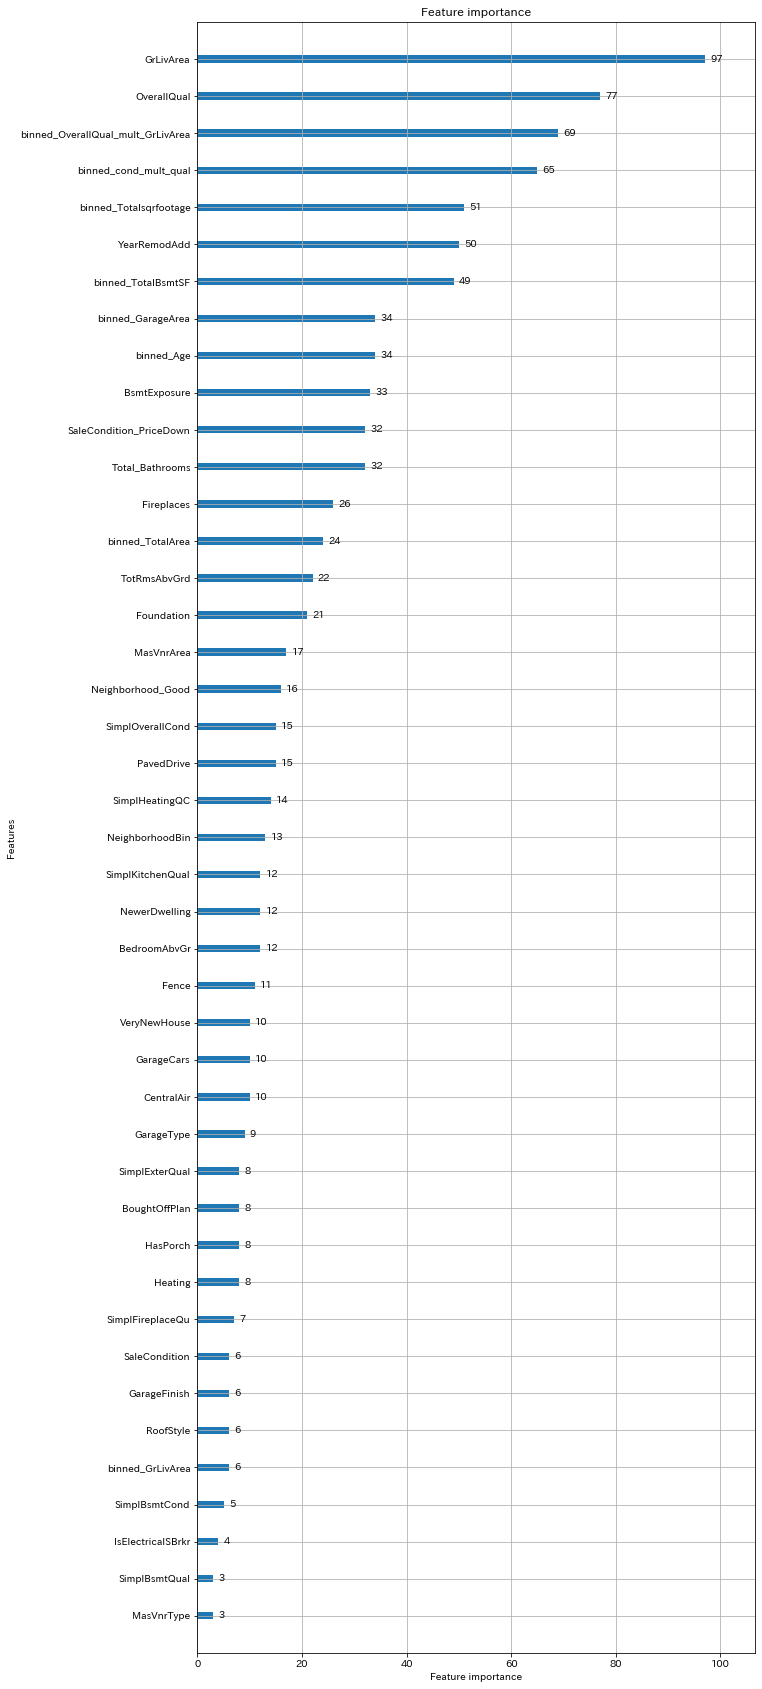

In [2431]:
lgb.plot_importance(model, figsize=(10,30))

In [2432]:
importance = pd.DataFrame(model.feature_importance(), index=X_train.columns)
importance.columns = ['importance']
importance = importance.sort_values('importance', ascending=False)
importance

,importance
GrLivArea,97
OverallQual,77
binned_OverallQual_mult_GrLivArea,69
binned_cond_mult_qual,65
binned_Totalsqrfootage,51
YearRemodAdd,50
binned_TotalBsmtSF,49
binned_Age,34
binned_GarageArea,34
BsmtExposure,33


In [617]:
len(test)

1457

In [1633]:
sub = pd.DataFrame({'Id': Id, 'SalePrice': 0})
y_sub = sum(y_preds) / len(y_preds)
y_sub = np.expm1(y_sub)
sub['SalePrice'] = y_sub
sub.to_csv('submission.csv', index=False)

## いろいろ確認

In [447]:
delta_corr_y = delta_f.corr()
delta_corr_y = pd.DataFrame(delta_corr_y['SalePrice'].sort_values(ascending=False)).reset_index()
delta_corr_y.columns = ['a', 'b']
delta_corr_y.head(30)

,a,b
0,SalePrice,1.000000
1,delta_mean_LandSlope_OverallQual,0.825777
2,delta_mean_Utilities_OverallQual,0.821382
3,delta_mean_Street_OverallQual,0.819434
4,delta_mean_Condition2_OverallQual,0.814927
5,delta_mean_BsmtFinType2_OverallQual,0.812701
6,delta_mean_LandContour_OverallQual,0.812118
7,delta_mean_LotConfig_OverallQual,0.812043
8,delta_mean_RoofMatl_OverallQual,0.811791
9,delta_mean_Functional_OverallQual,0.810314


In [488]:
delta_ef = []
for row in np.arange(30):
    if delta_corr_y.iloc[row].b != 1:
        if delta_corr_y.iloc[row].b > 0.8:
            delta_ef.append(delta_corr_y.iloc[row].a)

In [489]:
delta_ef

['delta_mean_LandSlope_OverallQual',
 'delta_mean_Utilities_OverallQual',
 'delta_mean_Street_OverallQual',
 'delta_mean_Condition2_OverallQual',
 'delta_mean_BsmtFinType2_OverallQual',
 'delta_mean_LandContour_OverallQual',
 'delta_mean_LotConfig_OverallQual',
 'delta_mean_RoofMatl_OverallQual',
 'delta_mean_Functional_OverallQual',
 'delta_mean_BldgType_OverallQual',
 'delta_mean_Heating_OverallQual',
 'delta_mean_Condition1_OverallQual']

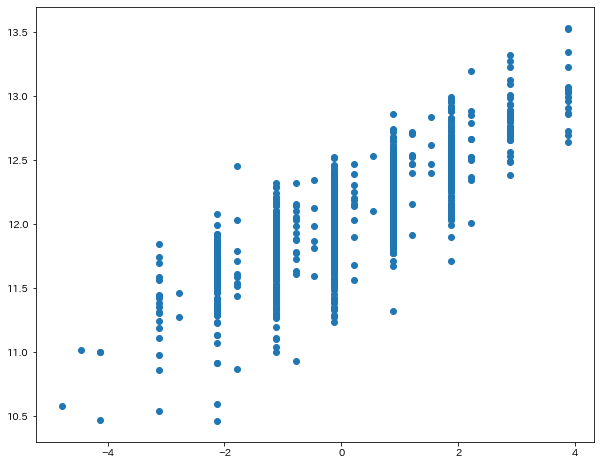

In [444]:
plt.scatter(x=delta_f['delta_mean_LandSlope_OverallQual'], y=delta_f['SalePrice'])

In [791]:
mean_corr_y = mean_f.corr()
mean_corr_y = pd.DataFrame(mean_corr_y['SalePrice'].sort_values(ascending=False)).reset_index()
mean_corr_y.columns = ['a', 'b']
mean_corr_y.head(30)

,a,b
0,SalePrice,1.000000
1,mean_Neighborhood_OverallQual,0.720794
2,mean_Neighborhood_GarageCars,0.715279
3,mean_Neighborhood_GarageArea,0.700844
4,mean_ExterQual_OverallQual,0.681916
5,mean_ExterQual_WoodDeckSF,0.681124
6,mean_ExterQual_GarageArea,0.680551
7,mean_ExterQual_GarageCars,0.678926
8,mean_Neighborhood_TotalBsmtSF,0.678247
9,mean_ExterQual_OpenPorchSF,0.677154


In [794]:
mean_ef = []
for row in np.arange(30):
    if mean_corr_y.iloc[row].b != 1:
        if mean_corr_y.iloc[row].b > 0.7:
            mean_ef.append(mean_corr_y.iloc[row].a)

In [797]:
mean_ef

['mean_Neighborhood_OverallQual',
 'mean_Neighborhood_GarageCars',
 'mean_Neighborhood_GarageArea']

In [800]:
many_corr_y = many_f.corr()
many_corr_y = pd.DataFrame(many_corr_y['SalePrice'].sort_values(ascending=False)).reset_index()
many_corr_y.columns = ['a', 'b']
many_corr_y.head(30)

,a,b
0,SalePrice,1.000000
1,1stFlrSF_div_PoolArea,0.951971
2,GarageCars_div_PoolArea,0.841011
3,OverallQual_mult_GrLivArea,0.838445
4,GrLivArea_mult_OverallQual,0.838445
5,OverallQual_mult_YearBuilt,0.827942
6,YearBuilt_mult_OverallQual,0.827942
7,OverallQual_mult_YearRemodAdd,0.825920
8,YearRemodAdd_mult_OverallQual,0.825920
9,GrLivArea_div_PoolArea,0.823449


In [803]:
many_ef = []
for row in np.arange(30):
    if many_corr_y.iloc[row].b != 1:
        if many_corr_y.iloc[row].b > 0.8:
            many_ef.append(many_corr_y.iloc[row].a)

In [804]:
many_ef

['1stFlrSF_div_PoolArea',
 'GarageCars_div_PoolArea',
 'OverallQual_mult_GrLivArea',
 'GrLivArea_mult_OverallQual',
 'OverallQual_mult_YearBuilt',
 'YearBuilt_mult_OverallQual',
 'OverallQual_mult_YearRemodAdd',
 'YearRemodAdd_mult_OverallQual',
 'GrLivArea_div_PoolArea',
 'OverallQual_div_YrSold',
 'YrSold_mult_OverallQual',
 'OverallQual_mult_YrSold',
 'GarageCars_mult_OverallQual',
 'OverallQual_mult_GarageCars',
 'OverallQual_div_YearRemodAdd',
 'OverallQual_div_GarageYrBlt',
 'OverallQual_div_YearBuilt',
 'GrLivArea_div_HalfBath',
 'GrLivArea_mult_GarageCars',
 'GarageCars_mult_GrLivArea']

In [1550]:
a = [ 'Has_no_Bsmt',
       'IsElectricalSBrkr',
       'IsGarageDetached', 'IsPavedDrive', 
       'RecentRemodel', 'VeryNewHouse',  'NewerDwelling', 'GarageStatus',
       'BsmtStatus', 'FirePlaceStatus', 'PoolStatus', 'cond_mult_qual',
       'HasPorch', 'Totalsqrfootage',
       'Total_Bathrooms', 'SaleCondition_PriceDown', 'BoughtOffPlan',
       'TotalArea', 'TotalArea1st2nd',
       'YearsSinceRemodel',
       'SimplOverallQual', 'SimplOverallCond', 'BadCond', 'SimplPoolQC',
       'SimplFireplaceQu',
       'SimplKitchenQual', 'SimplHeatingQC',
       'SimplBsmtCond',
       'SimplBsmtQual', 'SimplExterQual',
       'NeighborhoodBin', 'Neighborhood_Good']

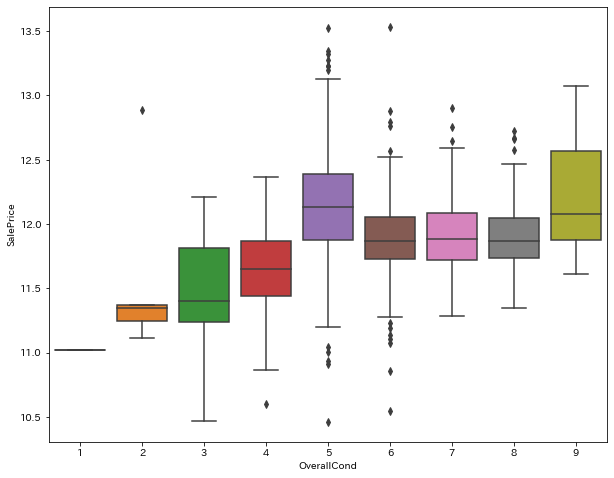

In [76]:

    sns.boxplot(x='OverallCond', y='SalePrice', data=alldata1)
    plt.show()

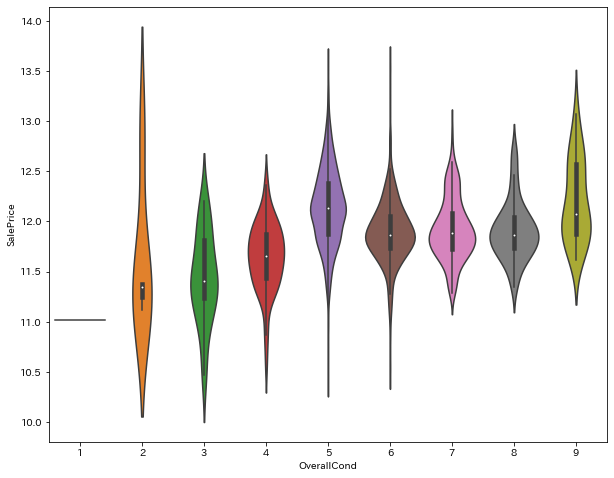

In [1470]:
sns.violinplot(x='OverallCond', y='SalePrice', data=alldata)

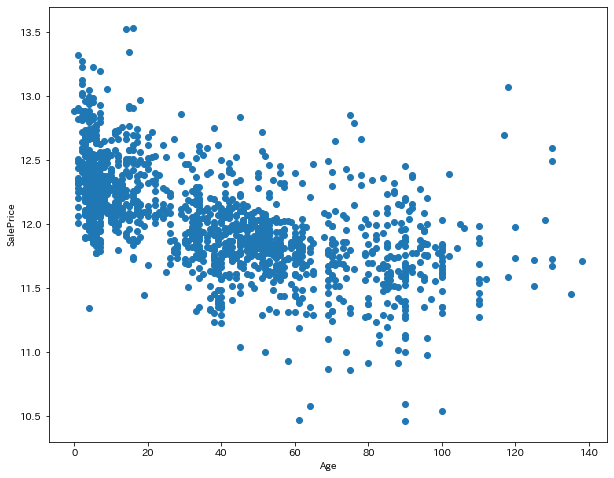

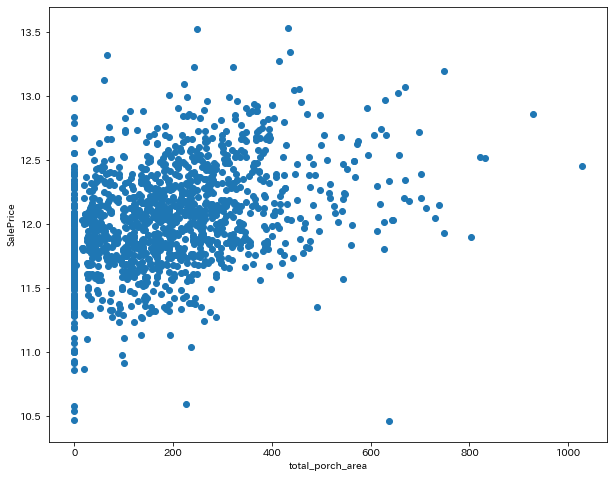

In [1267]:
for i in ['Age', 'total_porch_area']:
    plt.scatter(x=alldata[i], y=alldata['SalePrice'])
    plt.xlabel(i)
    plt.ylabel('SalePrice')
    plt.show()

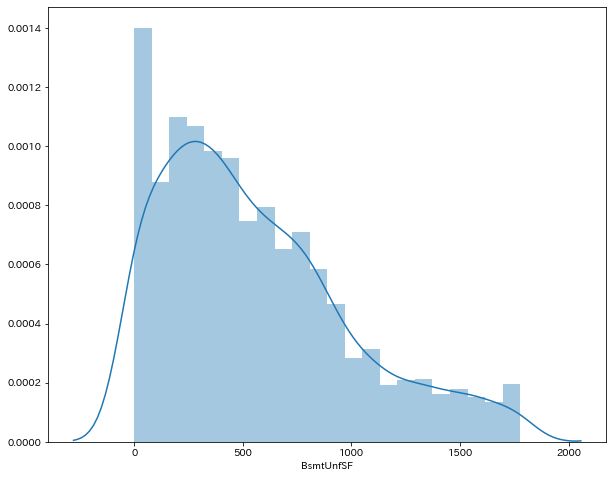

In [2256]:
sns.distplot(alldata['BsmtUnfSF'])

In [2255]:
p01 = alldata['BsmtUnfSF'].quantile(0.01)
p99 = alldata['BsmtUnfSF'].quantile(0.99)
alldata['BsmtUnfSF'] = alldata['BsmtUnfSF'].clip(p01, p99)

alldata['binned_'+ 'BsmtUnfSF'] = pd.cut(alldata['BsmtUnfSF'], 30 ,labels=False)

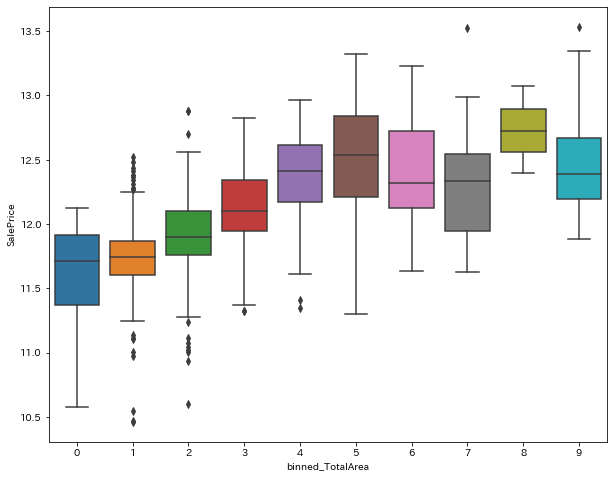

In [2272]:
sns.boxplot('binned_'+ 'TotalArea', 'SalePrice', data=alldata)

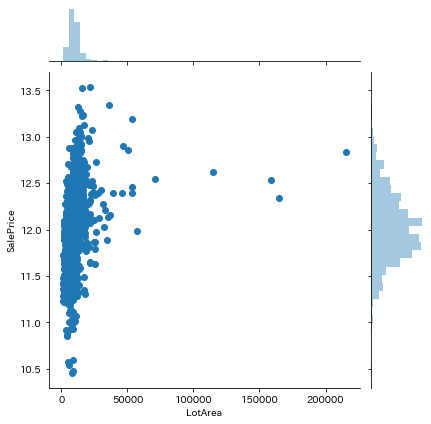

In [105]:
sns.jointplot(x='LotArea', y='SalePrice', data=alldata)